# Import Data

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import numpy as np
import gc
import seaborn as sns
import math
import pickle
import os

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from scipy.stats import randint as sp_randint
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from datetime import datetime

In [2]:
test = pd.read_csv('application_test.csv')
train = pd.read_csv('application_train.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau = pd.read_csv('bureau.csv')
ccb = pd.read_csv('credit_card_balance.csv')
ip = pd.read_csv('installments_payments.csv')
posh_cash_balance = pd.read_csv('POS_CASH_balance.csv')
pa = pd.read_csv('previous_application.csv')
ss = pd.read_csv('sample_submission.csv')

# Application Train Dataset

In [3]:
train.sample(5)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
34750       140267       0         Cash loans           F            N   
74558       186459       1         Cash loans           F            N   
1012        101171       0         Cash loans           F            N   
132456      253629       0         Cash loans           F            N   
27904       132439       0         Cash loans           M            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
34750                Y             1          157500.0    781920.0   
74558                N             0          157500.0    888840.0   
1012                 N             0          112500.0    508495.5   
132456               N             1          135000.0    314055.0   
27904                Y             0          180000.0   1078200.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
34750       42547.5  ...                 0                0                0   
74558       29506.5  ...                 0                0                0   
1012        21541.5  ...                 0                0                0   
132456      16573.5  ...                 0                0                0   
27904       38331.0  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
34750                 0                        0.0                       0.0   
74558                 0                        0.0                       0.0   
1012                  0                        0.0                       0.0   
132456                0                        0.0                       0.0   
27904                 0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
34750                          0.0                        1.0   
74558                          0.0                        0.0   
1012                           0.0                        0.0   
132456                         0.0                        0.0   
27904                          0.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
34750                         1.0                         6.0  
74558                         0.0                         2.0  
1012                          0.0                         4.0  
132456                        2.0                         1.0  
27904                         0.0                         1.0  

[5 rows x 122 columns]

## Data Preprocessing

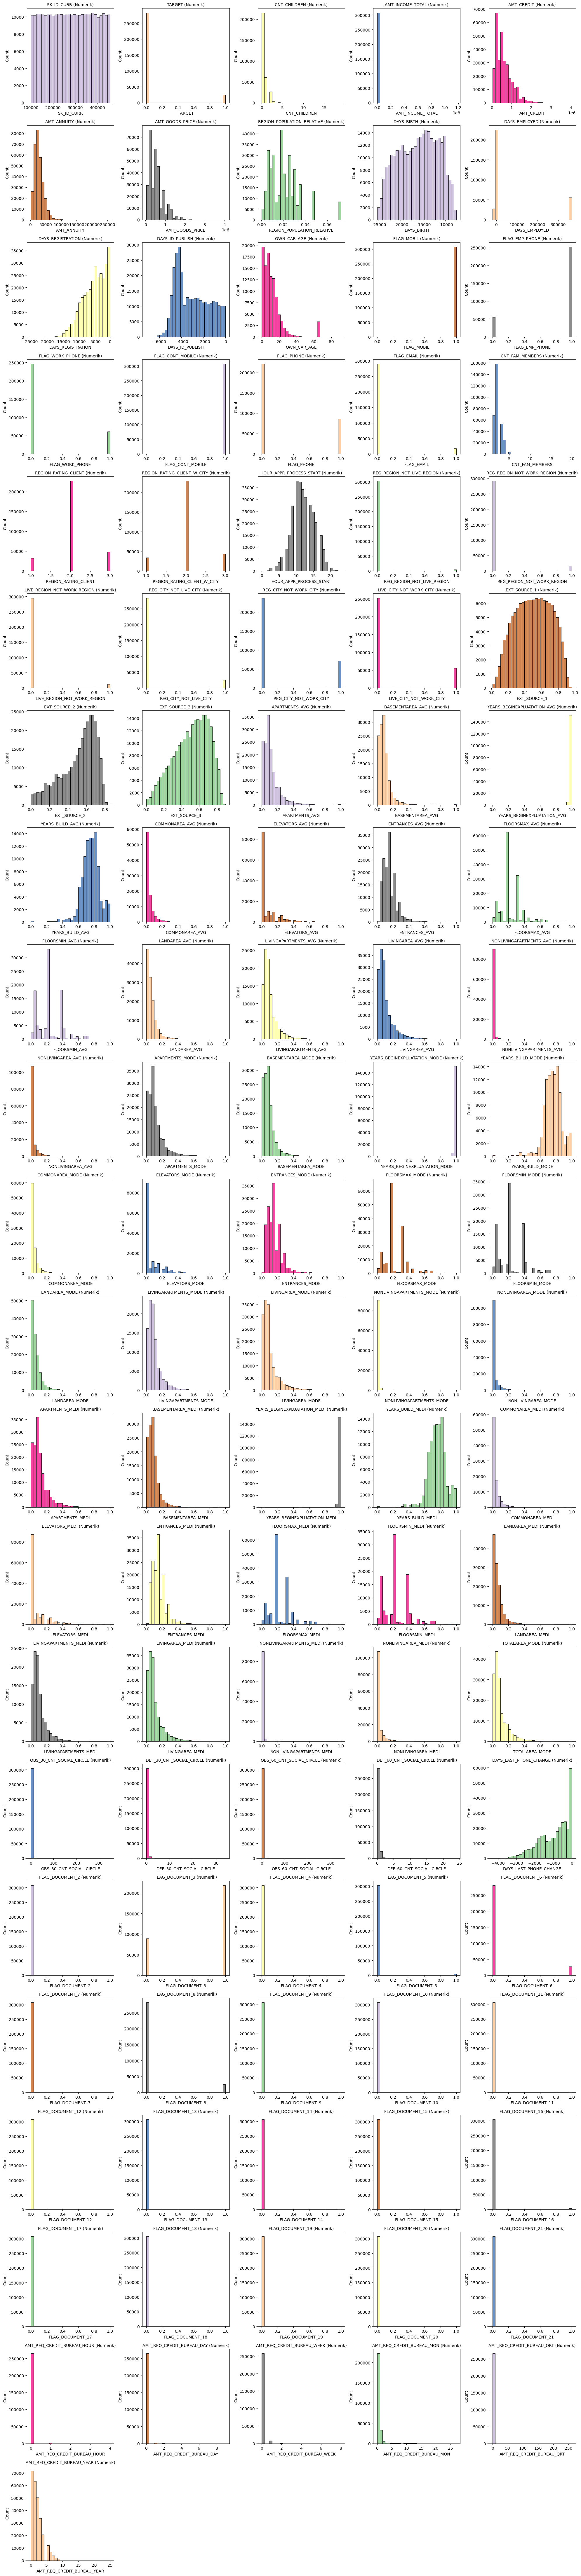

In [4]:
# Histoplot

# Menyaring kolom numerik dan kategorikal
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = train.select_dtypes(include=['object']).columns

# Menghitung jumlah total fitur untuk layout
num_cols = len(numerical_cols) + len(categorical_cols)
num_rows = (num_cols // 5) + 1

# Membuat palet warna Accent dari seaborn
palette = sns.color_palette("Accent", num_cols)

# Mengatur ukuran plot (disesuaikan dengan jumlah baris dan kolom)
plt.figure(figsize=(20, num_rows * 4))

# Membuat histogram untuk setiap kolom numerik
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(num_rows, 5, i)
    sns.histplot(train[col].dropna(), bins=30, color=palette[i % len(palette)], kde=False)
    plt.title(f'{col} (Numerik)', fontsize=10)
    plt.tight_layout()

plt.show()


In [5]:
# Mengubah feature days_birth menjadi age_years (usia)
train['age_years'] = (train['DAYS_BIRTH'] / -365).round(0)

In [6]:
train['age_years'] = train['age_years'].astype(int)

In [7]:
train[['age_years', 'DAYS_BIRTH']]

age_years  DAYS_BIRTH
0              26       -9461
1              46      -16765
2              52      -19046
3              52      -19005
4              55      -19932
...           ...         ...
307506         26       -9327
307507         57      -20775
307508         41      -14966
307509         33      -11961
307510         46      -16856

[307511 rows x 2 columns]

In [8]:
key = ['SK_ID_CURR']
categorical = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
               'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
numerical = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'age_years', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'AMT_GOODS_PRICE' ]

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 123 entries, SK_ID_CURR to age_years
dtypes: float64(65), int64(42), object(16)
memory usage: 288.6+ MB


Terdapat 122 features untuk dataset application_train dan berdasarkan hasil diskusi dalam analisa masing - masing feature, kami memutuskan untuk mengambil beberapa features penting yang berhubungan langsung dengan label 'TARGET' dimana ini akan digunakan untuk Exploratory Data Analysis (EDA). Meskipun pada proses analisis, terdapat beberapa features yang memiliki deskripsi yang kurang jelas dan tidak dapat kami konfirmasi tentang definisi features tersebut sehingga kami tidak memilih features tersebut ke dalam EDA.

## Statistics Descriptive

In [10]:
# Checking duplicate
train.duplicated().any()

np.False_

## Numerical

In [11]:
# handling Null value on Numerical data
train[numerical].isnull().sum()

AMT_INCOME_TOTAL      0
AMT_CREDIT            0
age_years             0
CNT_FAM_MEMBERS       2
CNT_CHILDREN          0
AMT_GOODS_PRICE     278
dtype: int64


Ditemukan null value pada features CNT_FAM_MEMBERS dan AMT_GOODS_PRICE pada kolom - kolom numerical.

In [12]:
train[numerical] = train[numerical].fillna(train[numerical].median())

In [13]:
train[numerical].isnull().sum()

AMT_INCOME_TOTAL    0
AMT_CREDIT          0
age_years           0
CNT_FAM_MEMBERS     0
CNT_CHILDREN        0
AMT_GOODS_PRICE     0
dtype: int64

Berdasarkan Null value pada kolom - kolom numerical, ditemukan beberapa null value yang berada di bawah 5% sehingga kami memutuskan untuk mengubah null value tersebut ke dalam median karena lebih robust dan tidak terlalu mengubah data secara keseluruhan.

In [14]:
train[numerical].describe()

AMT_INCOME_TOTAL    AMT_CREDIT      age_years  CNT_FAM_MEMBERS  \
count      3.075110e+05  3.075110e+05  307511.000000    307511.000000   
mean       1.687979e+05  5.990260e+05      43.938646         2.152664   
std        2.371231e+05  4.024908e+05      11.964047         0.910679   
min        2.565000e+04  4.500000e+04      21.000000         1.000000   
25%        1.125000e+05  2.700000e+05      34.000000         2.000000   
50%        1.471500e+05  5.135310e+05      43.000000         2.000000   
75%        2.025000e+05  8.086500e+05      54.000000         3.000000   
max        1.170000e+08  4.050000e+06      69.000000        20.000000   

        CNT_CHILDREN  AMT_GOODS_PRICE  
count  307511.000000     3.075110e+05  
mean        0.417052     5.383163e+05  
std         0.722121     3.692890e+05  
min         0.000000     4.050000e+04  
25%         0.000000     2.385000e+05  
50%         0.000000     4.500000e+05  
75%         1.000000     6.795000e+05  
max        19.000000     4.050000e+06

Berdasarkan hasil statistics descriptive untuk data train dengan kolom - kolom Numerical, berikut beberapa hasil analisa yang ditemukan:
1. AMT_INCOME_TOTAL: mean dan median memiliki selisih yang cukup berbeeda dan cenderung right-skewed karena mean lebih besar dan terlihat jumlah pendapatan tertinggi berada di 117.000.000.
2. AMT_CREDIT: memiliki nilai mean dan median yang berbeda dimana mean lebih besar daripada median (sehingga ada kecenderungan outliers dan skewed ke arah kanan).
3. age_years:Berdasarkan feature yang merepresentasikan usia ini tidak terlihat adanya keanehan dimana range usia antara 21 - 69 tahun.
4. CONT_FAM_MEMBERS: Mean dan median terlihat tidak berbeda jauh signifikan (selisih di kisaran 0.1) dan tidak tampak adanya keanehan.
5. CNT_CHILDREN: Feature ini juga tidak terlihat adanya keanehan data.
6. AMT_GOODS_PRICE: Terlihat adanya perbedaan antara mean dengan mediannya dimana mean lebih tinggi yang menunjukan grafik cenderung ke kanan (right_skewed)

analisa antar feature:
1. rata - rata pendapatan (AMT_INCOME_TOTAL) berada di sekitar 168.798, sementara rata - rata kredit (AMT_CREDIT) jauh lebih tinggi sebesar 559.026. Ini menunjukan bahwa rata - rata orang mengambil kredit yang nilainya lebih besar daripada pendapatan mereka.
2. Rata - rata jumlah anggota keluarga itu adalah 2 orang yang berarti kebanyakan peminjam itu memiliki keluarga yang kecil.
3. Berdasarkan jumlah anak, rata - rata berada di angka 0.4 atau jika dibulatkan 0. Hal ini menunjukan peminjam kebanyakan tidak memiliki seorang anak dan/atau sedikit anak.

## Mengecek keanehan value 

In [15]:
# Checking values in every features
for i in train.columns:
    print(f"{[i]} \n {train[i].unique()} \n")

['SK_ID_CURR'] 
 [100002 100003 100004 ... 456253 456254 456255] 

['TARGET'] 
 [1 0] 

['NAME_CONTRACT_TYPE'] 
 ['Cash loans' 'Revolving loans'] 

['CODE_GENDER'] 
 ['M' 'F' 'XNA'] 

['FLAG_OWN_CAR'] 
 ['N' 'Y'] 

['FLAG_OWN_REALTY'] 
 ['Y' 'N'] 

['CNT_CHILDREN'] 
 [ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14] 

['AMT_INCOME_TOTAL'] 
 [202500.  270000.   67500.  ...  96768.  546250.5 113062.5] 

['AMT_CREDIT'] 
 [ 406597.5 1293502.5  135000.  ...  181989.   743863.5 1391130. ] 

['AMT_ANNUITY'] 
 [24700.5 35698.5  6750.  ... 71986.5 58770.  77809.5] 

['AMT_GOODS_PRICE'] 
 [ 351000.  1129500.   135000.  ...  453465.   143977.5  743863.5] 

['NAME_TYPE_SUITE'] 
 ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people'] 

['NAME_INCOME_TYPE'] 
 ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave'] 

['NAME_EDUCATION_TYPE'] 
 ['Secondary / secondary special' 'Higher education' 'Inc

In [16]:
train[['CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'DAYS_BIRTH', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].sort_values(by='CNT_CHILDREN', ascending=False)

CNT_FAM_MEMBERS  CNT_CHILDREN  DAYS_BIRTH    NAME_FAMILY_STATUS  \
155369             20.0            19      -11057  Single / not married   
265784             20.0            19      -10297  Single / not married   
267998             16.0            14      -15463               Married   
176011             15.0            14      -17754             Separated   
183878             16.0            14      -20308               Married   
...                 ...           ...         ...                   ...   
26                  1.0             0      -18724                 Widow   
28                  1.0             0       -9994  Single / not married   
29                  1.0             0      -10341  Single / not married   
30                  2.0             0      -15280        Civil marriage   
31                  2.0             0      -11144        Civil marriage   

              OCCUPATION_TYPE  AMT_INCOME_TOTAL       ORGANIZATION_TYPE  
155369   Waiters/barmen staff          112500.0              Restaurant  
265784             Core staff          112500.0            Kindergarten  
267998               Managers           54000.0                  Postal  
176011                Drivers          225000.0           Self-employed  
183878                    NaN           45000.0                     XNA  
...                       ...               ...                     ...  
26              Cooking staff          112500.0  Business Entity Type 3  
28                        NaN          270000.0                Military  
29                   Laborers           90000.0  Business Entity Type 3  
30                        NaN          292500.0  Business Entity Type 3  
31      Private service staff          112500.0                Services  

[307511 rows x 7 columns]

In [17]:
from scipy import stats
import numpy as np

def handle_outliers_zscore(df, columns, z_thresh=3):

    outlier_counts = {}  # Dictionary to store the count of outliers for each column

    for col in columns:
        if col in df.columns:
            # Calculate Z-scores for each data point
            z_scores = np.abs(stats.zscore(df[col]))

            # Count the number of outliers (Z-scores greater than the threshold)
            outliers = (z_scores > z_thresh).sum()
            outlier_counts[col] = outliers

            # Print the number of outliers
            print(f"Column '{col}': {outliers} outliers based on Z-scores.")

            # Cap the values beyond the Z-threshold by replacing them with the column mean
            df[col] = np.where(z_scores > z_thresh, df[col].mean(), df[col])

            print(f"Outliers in column '{col}' have been handled based on Z-scores.\n")

    return df, outlier_counts

# Apply to the numerical columns in your dataset
numerical_columns = ['CNT_FAM_MEMBERS','CNT_CHILDREN']
train, zscore_outliers_info = handle_outliers_zscore(train, numerical_columns)

# Print out the summary of outliers handled
print("\nSummary of outliers handled (Z-score method):")
for col, count in zscore_outliers_info.items():
    print(f"Column '{col}' had {count} outliers handled.")

Column 'CNT_FAM_MEMBERS': 4007 outliers based on Z-scores.
Outliers in column 'CNT_FAM_MEMBERS' have been handled based on Z-scores.

Column 'CNT_CHILDREN': 4272 outliers based on Z-scores.
Outliers in column 'CNT_CHILDREN' have been handled based on Z-scores.


Summary of outliers handled (Z-score method):
Column 'CNT_FAM_MEMBERS' had 4007 outliers handled.
Column 'CNT_CHILDREN' had 4272 outliers handled.


In [18]:
train[numerical].describe()

AMT_INCOME_TOTAL    AMT_CREDIT      age_years  CNT_FAM_MEMBERS  \
count      3.075110e+05  3.075110e+05  307511.000000    307511.000000   
mean       1.687979e+05  5.990260e+05      43.938646         2.113036   
std        2.371231e+05  4.024908e+05      11.964047         0.836938   
min        2.565000e+04  4.500000e+04      21.000000         1.000000   
25%        1.125000e+05  2.700000e+05      34.000000         2.000000   
50%        1.471500e+05  5.135310e+05      43.000000         2.000000   
75%        2.025000e+05  8.086500e+05      54.000000         3.000000   
max        1.170000e+08  4.050000e+06      69.000000         4.000000   

        CNT_CHILDREN  AMT_GOODS_PRICE  
count  307511.000000     3.075110e+05  
mean        0.378519     5.383163e+05  
std         0.637053     3.692890e+05  
min         0.000000     4.050000e+04  
25%         0.000000     2.385000e+05  
50%         0.000000     4.500000e+05  
75%         1.000000     6.795000e+05  
max         2.000000     4.050000e+06

Kami memutuskan untuk handling outliers pada feature CNT_FAM_MEMBERS dan CNT_CHILDREN karena setelah kami cek masing - masing data pribadi orang tersebut, kami menemukan bahwa terdapat customer yang memiliki jumlah anggota keluarga sebanyak 20 orang dengan jumlah anak sebanyak 19 orang dengan posisi sebagai waiters/barmen staff di sebuah restoran dengan pendapatan 1.125.000 sedangkan secara rata-rata gaji yang berada dikisaran 1.687.979 memiliki 2 jumlah anggota keluarga tanpa memiliki anak maka dari itu, kami membuang outliers menggunakan {iqr atau z-score}

## Categorical

In [19]:
# handling Null value on Categorical data
train[categorical].isnull().sum()

NAME_CONTRACT_TYPE         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
OCCUPATION_TYPE        96391
ORGANIZATION_TYPE          0
dtype: int64

In [20]:
train[categorical].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   NAME_CONTRACT_TYPE   307511 non-null  object
 1   CODE_GENDER          307511 non-null  object
 2   FLAG_OWN_CAR         307511 non-null  object
 3   FLAG_OWN_REALTY      307511 non-null  object
 4   NAME_INCOME_TYPE     307511 non-null  object
 5   NAME_EDUCATION_TYPE  307511 non-null  object
 6   NAME_FAMILY_STATUS   307511 non-null  object
 7   NAME_HOUSING_TYPE    307511 non-null  object
 8   OCCUPATION_TYPE      211120 non-null  object
 9   ORGANIZATION_TYPE    307511 non-null  object
dtypes: object(10)
memory usage: 23.5+ MB


Berdasarkan hasil statistic descriptive untuk tipe data categorical yang sudah dipilih, kami menemukan satu feature yang memiliki null value, yaitu feature 'OCCUPATION_TYPE' dan kami memutuskan untuk drop null value tersebut.

In [21]:
train = train.dropna(subset=['OCCUPATION_TYPE'])

In [22]:
train[categorical].info()

<class 'pandas.core.frame.DataFrame'>
Index: 211120 entries, 0 to 307510
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   NAME_CONTRACT_TYPE   211120 non-null  object
 1   CODE_GENDER          211120 non-null  object
 2   FLAG_OWN_CAR         211120 non-null  object
 3   FLAG_OWN_REALTY      211120 non-null  object
 4   NAME_INCOME_TYPE     211120 non-null  object
 5   NAME_EDUCATION_TYPE  211120 non-null  object
 6   NAME_FAMILY_STATUS   211120 non-null  object
 7   NAME_HOUSING_TYPE    211120 non-null  object
 8   OCCUPATION_TYPE      211120 non-null  object
 9   ORGANIZATION_TYPE    211120 non-null  object
dtypes: object(10)
memory usage: 17.7+ MB


In [23]:
train[categorical].describe()

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
count              211120      211120       211120          211120   
unique                  2           3            2               2   
top            Cash loans           F            N               Y   
freq               189432      129282       130939          143600   

       NAME_INCOME_TYPE            NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  \
count            211120                         211120             211120   
unique                7                              5                  6   
top             Working  Secondary / secondary special            Married   
freq             133854                         147056             138000   

        NAME_HOUSING_TYPE OCCUPATION_TYPE       ORGANIZATION_TYPE  
count              211120          211120                  211120  
unique                  6              18                      58  
top     House / apartment        Laborers  Business Entity Type 3  
freq               184685           55186                   53655

## Univariate Analysis
Mencari distribusi masing - masing feature maupun target (melihat adakah grafik yang menarik seperti skewed, bimodal, outliers, nilai yang mendominasi, kategori terlalu banyak). Dan jelaksan apa saja yang harus di follow up saat data preprocessing (contoh: feature X sangat outliers sehingga perlu menggunakan box-cox atau yeo jonson)

1. Histogram secara keseluruhan feature untuk melihat distribusi data dan outliers (numerical)
2. boxplot secara keseluruhan feature untuk melihat distribusi data dan outliers (numerical)
3. Countplot masing - masing feature untuk mencari nilai yang mendominasi (categorical)

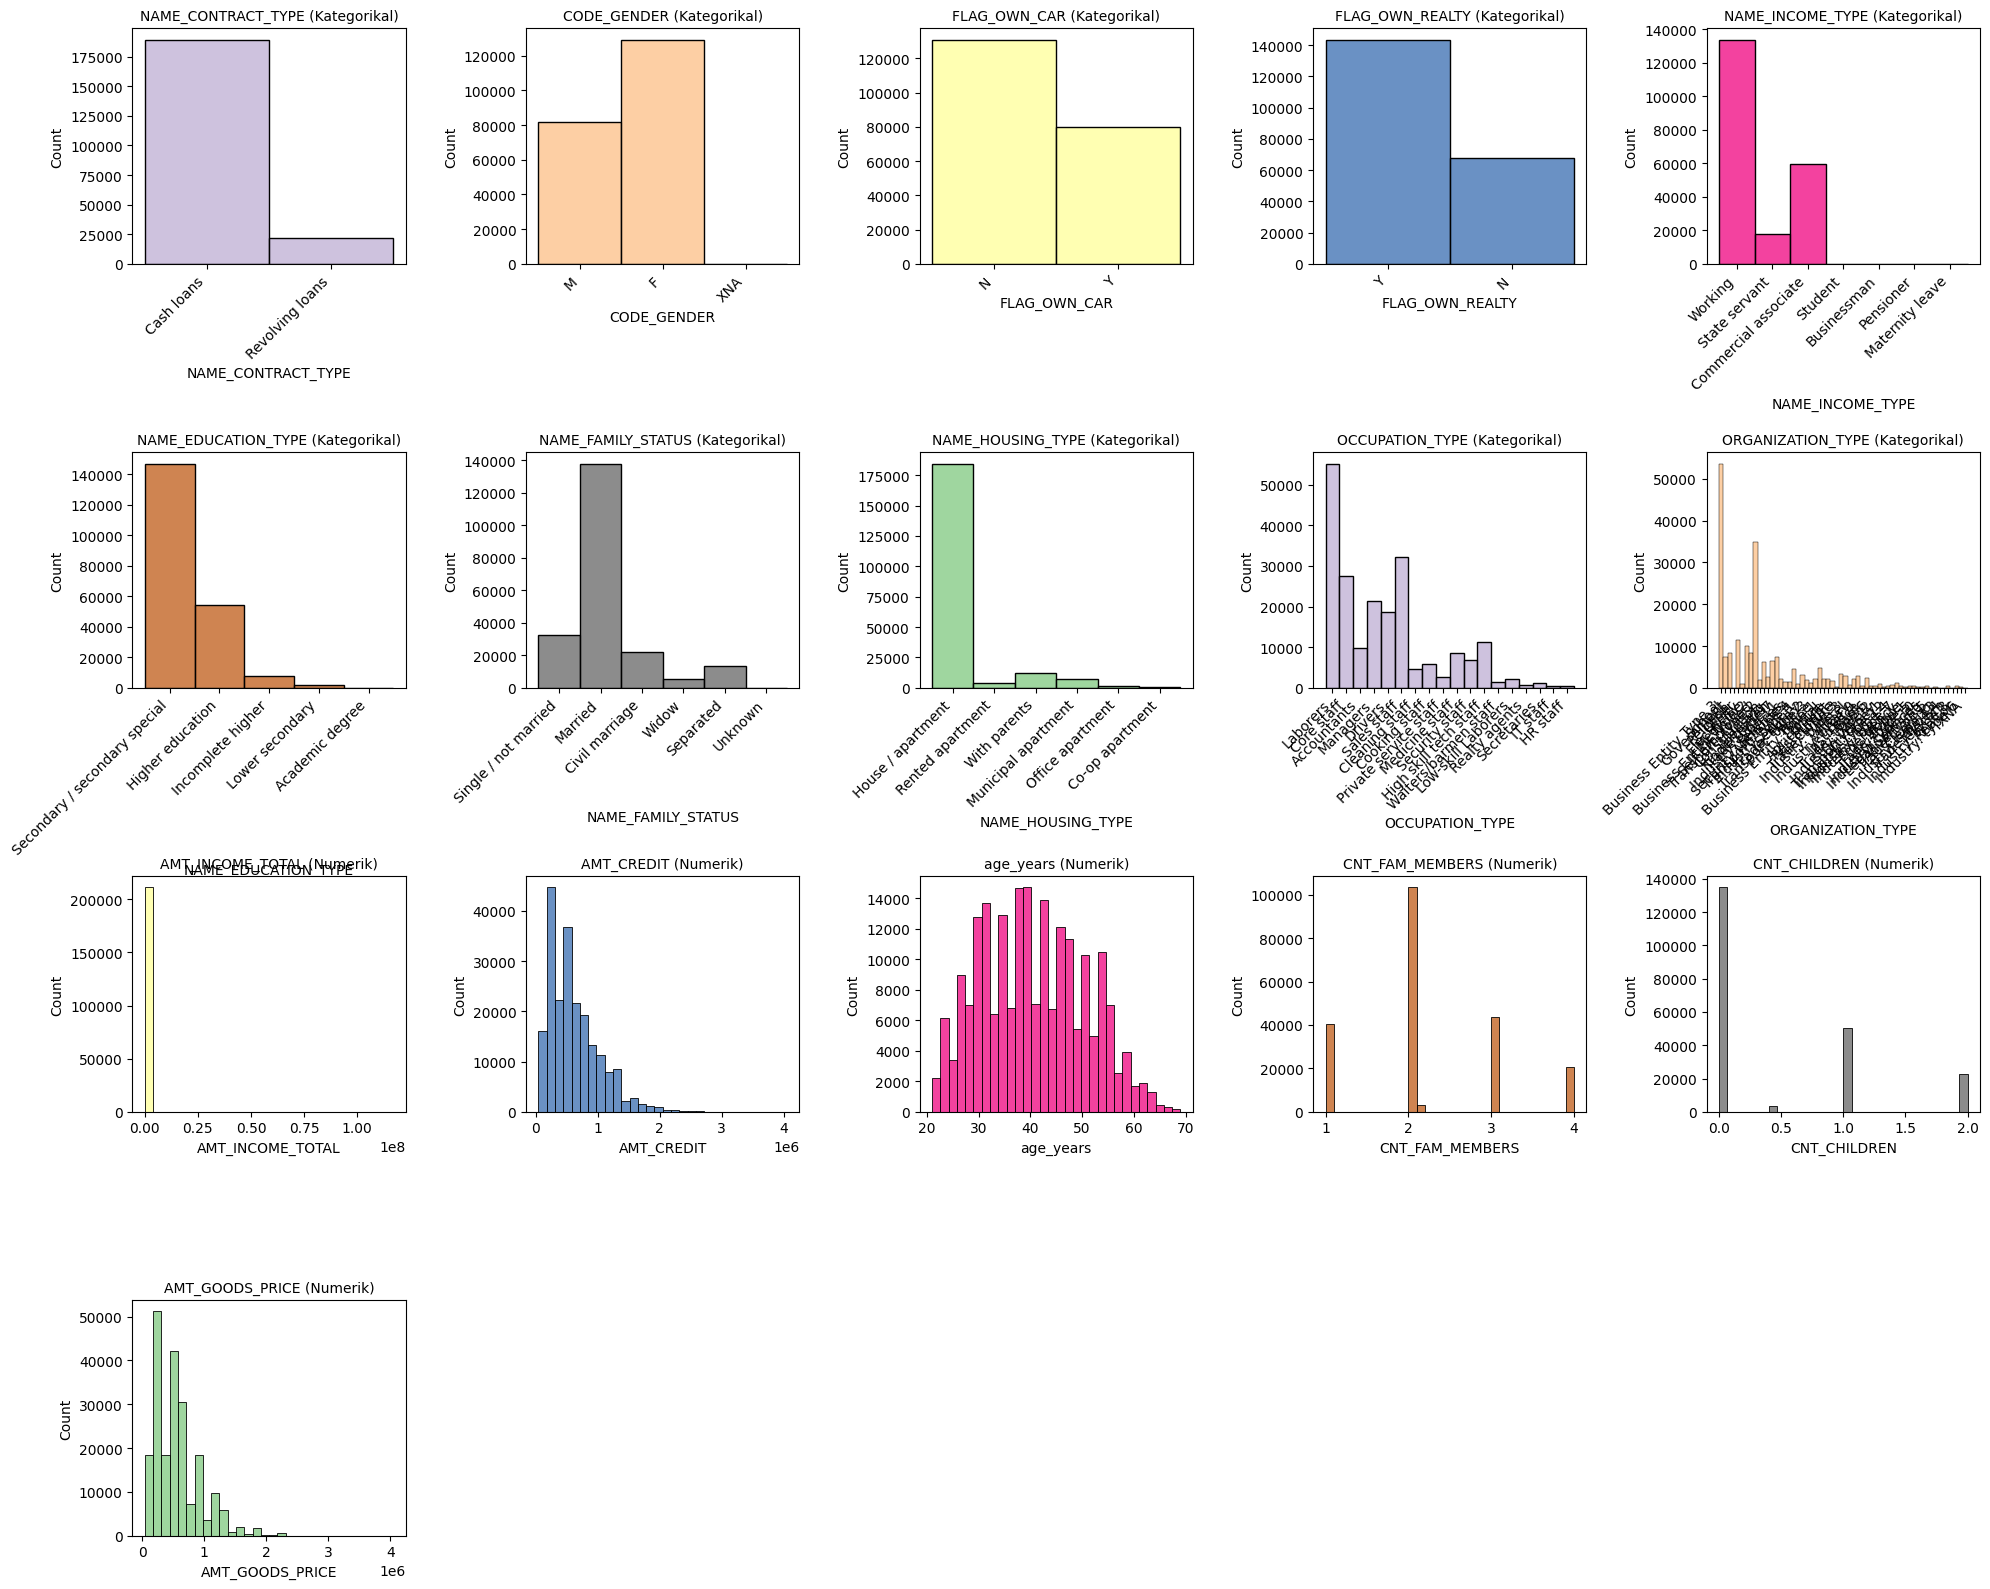

In [24]:
# Menggabungkan kolom kategorikal dan numerik
all_cols = categorical + numerical

# Menghitung jumlah kolom dan baris untuk layout
num_cols = len(all_cols)
num_rows = (num_cols // 5) + 1

# Membuat palet warna Accent
palette = sns.color_palette("Accent", num_cols)

# Mengatur ukuran plot
plt.figure(figsize=(20, num_rows * 4))

# Membuat histogram untuk setiap kolom
for i, col in enumerate(all_cols, 1):
    plt.subplot(num_rows, 5, i)

    if col in categorical:
        sns.histplot(train[col], color=palette[i % len(palette)])
        plt.title(f'{col} (Kategorikal)', fontsize=10)
        plt.xticks(rotation=45, ha='right')
    else:
        sns.histplot(train[col].dropna(), bins=30, color=palette[i % len(palette)])
        plt.title(f'{col} (Numerik)', fontsize=10)

    plt.tight_layout()

# Mengatur jarak antar subplots
plt.subplots_adjust(hspace=0.8)
plt.show()

**Variabel Kategorikal:**

- CODE_GENDER: Sebagian besar pelanggan adalah Female.
- FLAG_OWN_CAR: Sebagian besar pelanggan memiliki mobil.
- FLAG_OWN_REALTY: Sebagian besar pelanggan memiliki properti.
- NAME_EDUCATION_TYPE: Sebagian besar pelanggan memiliki pendidikan secondary/secondary special.
- NAME_FAMILY_STATUS: Status keluarga yang paling umum adalah married.
- NAME_HOUSING_TYPE: Jenis perumahan yang paling umum adalah house/apartement.
- OCCUPATION_TYPE: Pekerjaan yang paling umum adalah laborers.
- ORGANIZATION_TYPE: Jenis organisasi yang paling umum adalah business entity.

**Variabel Numerik:**

- AMT_INCOME_TOTAL: Sebagian besar pelanggan memiliki pendapatan di bawah rata-rata, dengan sedikit sekali pelanggan yang memiliki pendapatan sangat tinggi. - Distribusi cenderung miring ke kanan.
- AMT_CREDIT: Jumlah kredit yang diajukan bervariasi cukup besar, dengan beberapa pelanggan mengajukan kredit yang sangat besar.
- DAYS_BIRTH: Usia pelanggan bervariasi, dengan sebagian besar pelanggan berusia di bawah 50 tahun.
- CNT_FAM_MEMBERS: Jumlah anggota keluarga umumnya kecil.
- CNT_CHILDREN: Sebagian besar pelanggan memiliki sedikit atau tidak ada anak.
- AMT_GOODS_PRICE: Harga barang yang dibeli cenderung berkorelasi dengan jumlah kredit yang diajukan.

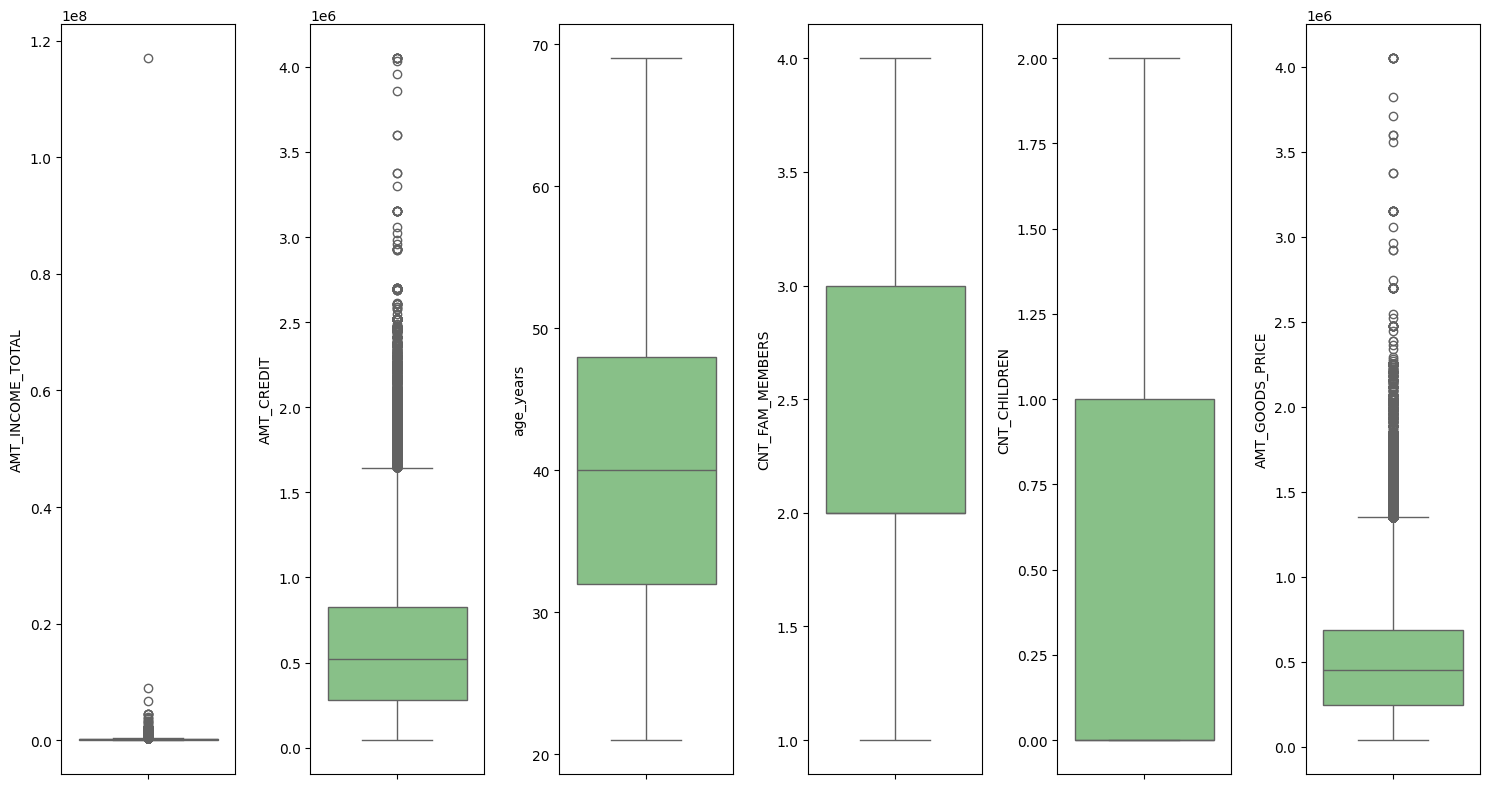

In [25]:
# Boxplot

plt.figure(figsize=(15, 8))
for col in range(0, len(numerical)):
    plt.subplot(1, len(numerical), col+1)
    sns.boxplot(y=train[numerical[col]], palette='Accent', orient='v')
    plt.tight_layout()

-AMT_INCOME_TOTAL terdapat 1 data yang memiliki kemungkinan outlier sangat besar, karena jauh melampaui data lainnya

-AMT_CREDIT memiliki beberapa kemungkinan outliers, terutama yang di atas **3500000**

-DAYS_BIRTH data yang terdistribusi cukup konsisten

-CNT_FAM_MEMBERS, terdapat 1 data yang cukup mencolok dengan 20 anggota keluarga

-CNT_CHILDREN, terdapat beberapa kemungkinan outliers, terutama yang memiliki lebih dari 10 anak

-AMT_GOODS_PRICE terdapat beberapa kemungkinan outliers, namun masih bisa dipertimbangkan sebagai suatu kewajaran

## Multivariate Analysis & Business Insight

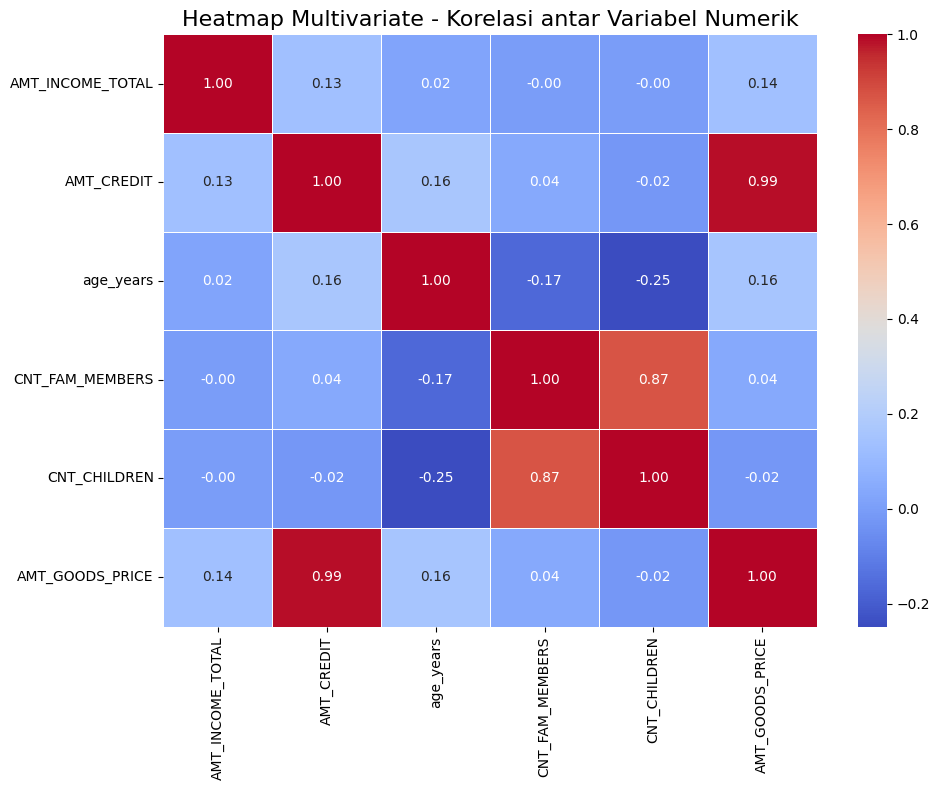

In [26]:
# Menghitung korelasi
NUMS = ['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_BIRTH', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'AMT_GOODS_PRICE' ]
correlation_matrix = train[numerical].corr()
# correlation_matrix = train[NUMS].corr()

# Membuat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Heatmap Multivariate - Korelasi antar Variabel Numerik', fontsize=16)
plt.tight_layout()
plt.show()

Pada multivariate analysis ini kami menggunakan heatmap untuk feature - feature yang sudah kami seleksi dan terlihat bahwa terdapat beberapa feature yang memiliki korelasi yang sangat kuat, antara lain:
1. Korelasi Kuat Positif (0.8 - 1.0):
- AMT_CREDIT dan AMT_GOODS_PRICE (0.99): Ini menunjukkan bahwa jumlah kredit sangat berkorelasi dengan harga barang, yang masuk akal jika kredit digunakan untuk membeli barang tertentu.
- CNT_FAM_MEMBERS dan CNT_CHILDREN (0.85): Jumlah anggota keluarga berkorelasi kuat dengan jumlah anak, yang logis karena anak-anak adalah bagian dari anggota keluarga.

2. Korelasi Moderat Positif (0.3 - 0.7):
- DAYS_BIRTH dan CNT_CHILDREN (0.34): Ada korelasi positif moderat antara usia (dalam hari) dan jumlah anak.
- DAYS_BIRTH dan CNT_FAM_MEMBERS (0.28): Korelasi serupa juga terlihat antara usia dan jumlah anggota keluarga.

3. Korelasi Lemah Positif (0.0 - 0.3):
- AMT_INCOME_TOTAL memiliki korelasi lemah positif dengan AMT_CREDIT dan AMT_GOODS_PRICE (keduanya 0.16).
- CNT_FAM_MEMBERS dan AMT_CREDIT (0.07): Korelasi sangat lemah antara jumlah anggota keluarga dan jumlah kredit.

4. Korelasi Lemah Negatif (-0.3 - 0.0):
- DAYS_BIRTH dan AMT_CREDIT (-0.06): Korelasi sangat lemah negatif antara usia dan jumlah kredit.
- DAYS_BIRTH dan AMT_GOODS_PRICE (-0.05): Korelasi sangat lemah negatif antara usia dan harga barang.

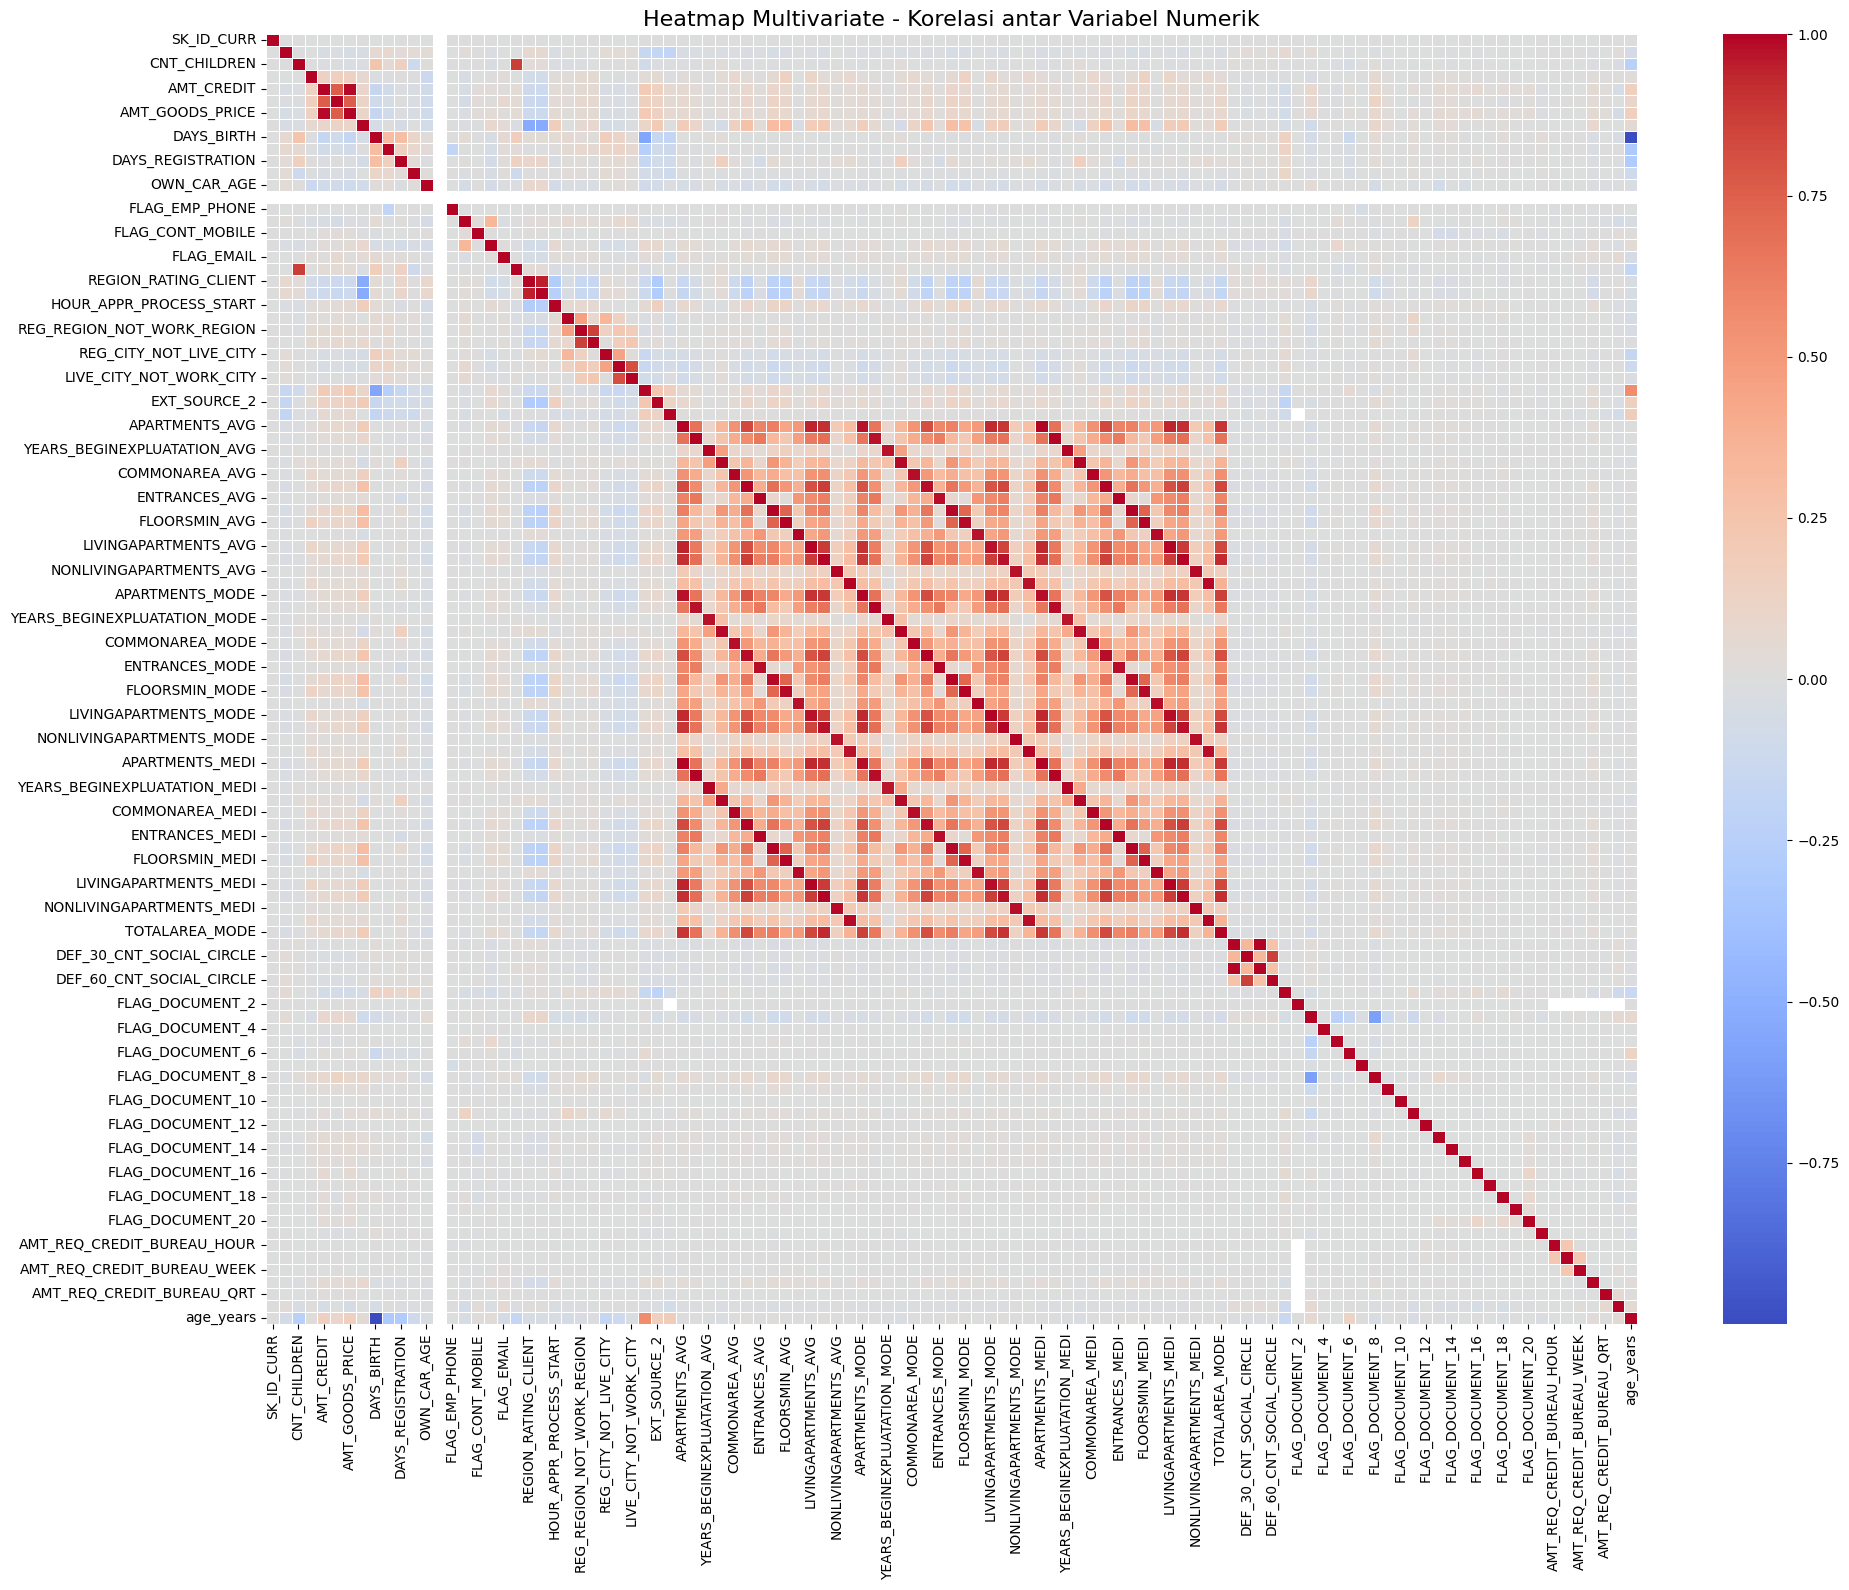

Top 10 Korelasi Tertinggi:
YEARS_BUILD_MEDI          YEARS_BUILD_AVG             0.998646
YEARS_BUILD_AVG           YEARS_BUILD_MEDI            0.998646
OBS_60_CNT_SOCIAL_CIRCLE  OBS_30_CNT_SOCIAL_CIRCLE    0.998485
OBS_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE    0.998485
FLOORSMIN_AVG             FLOORSMIN_MEDI              0.997376
FLOORSMIN_MEDI            FLOORSMIN_AVG               0.997376
FLOORSMAX_MEDI            FLOORSMAX_AVG               0.997171
FLOORSMAX_AVG             FLOORSMAX_MEDI              0.997171
ENTRANCES_AVG             ENTRANCES_MEDI              0.996978
ENTRANCES_MEDI            ENTRANCES_AVG               0.996978
dtype: float64


In [27]:
# Memilih kolom numerik
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns

# Menghitung korelasi
correlation_matrix = train[numeric_columns].corr()

# Membuat heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Heatmap Multivariate - Korelasi antar Variabel Numerik', fontsize=16)
plt.tight_layout()
plt.show()

# Menampilkan korelasi tertinggi (opsional)
print("Top 10 Korelasi Tertinggi:")
corr_unstack = correlation_matrix.unstack()
corr_unstack = corr_unstack.sort_values(kind="quicksort", ascending=False)
print(corr_unstack[corr_unstack < 1].head(10))

## Perbandingan proporsi customer gagal bayar vs tidak

In [28]:
train['TARGET'].value_counts()

TARGET
0    192573
1     18547
Name: count, dtype: int64

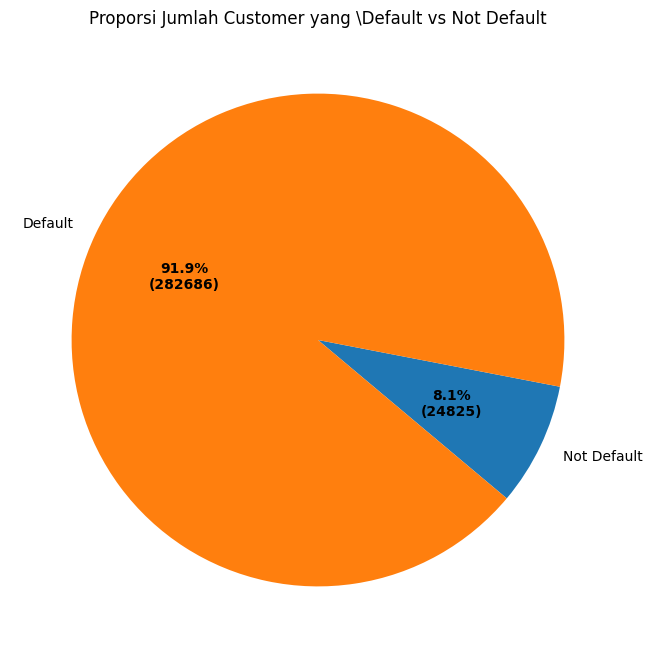

Jumlah payment difficultiess: 24825, (8.1%)
Jumlah all other case: 282686, (91.9%)


In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data
test_train = pd.read_csv('application_train.csv')

y_value_counts = test_train['TARGET'].value_counts()

# Menyiapkan data untuk pie chart
recipe = ["Not Default", "Default"]
data = [y_value_counts[1], y_value_counts[0]]

# Membuat pie chart
fig, ax = plt.subplots(figsize=(10, 8))
sns.set_palette("Accent")
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val:d})'
    return my_autopct

wedges, texts, autotexts = ax.pie(data, 
                                  labels=recipe,
                                  autopct=make_autopct(data),
                                  startangle=-40)
                                  

# Mengatur properti teks
plt.setp(autotexts, size=10, weight="bold")

ax.set_title("Proporsi Jumlah Customer yang \Default vs Not Default")

plt.show()

# Mencetak informasi tambahan
print(f"Jumlah payment difficultiess: {y_value_counts[1]}, ({y_value_counts[1]/(y_value_counts[1]+y_value_counts[0])*100:.1f}%)")
print(f"Jumlah all other case: {y_value_counts[0]}, ({y_value_counts[0]/(y_value_counts[1]+y_value_counts[0])*100:.1f}%)")

Berdasarkan hasil visualisasi pie chart di atas, dapat disimpulkan bahwa sebanyak 24.825 (8.1%) nasabah mengalami kesulitan pembayaran (payment difficulties) dan 91,9% adalah case lain (all other cases) yang salah satunya adalah nasabah yang tidak mengalami kesulitan pembayaran.

## NAME_CONTRACT_TYPE
Membandingkan customer yang mengajukan pinjaman secara cash vs revolved

Summary Cash Loans:
         capable     AMT_CREDIT           AMT_INCOME_TOTAL            \
                           mean    median             mean    median   
0        Capable  649951.341737  545040.0    176942.813072  157500.0   
1  Tidak capable  578741.129141  521280.0    173022.069731  153000.0   

  SK_ID_CURR  
       count  
0     172137  
1      17295  

Summary Revolving Loans:
         capable     AMT_CREDIT           AMT_INCOME_TOTAL            \
                           mean    median             mean    median   
0        Capable  324709.703464  270000.0    170258.670383  135000.0   
1  Tidak capable  256467.651757  202500.0    143310.899760  121500.0   

  SK_ID_CURR  
       count  
0      20436  
1       1252  


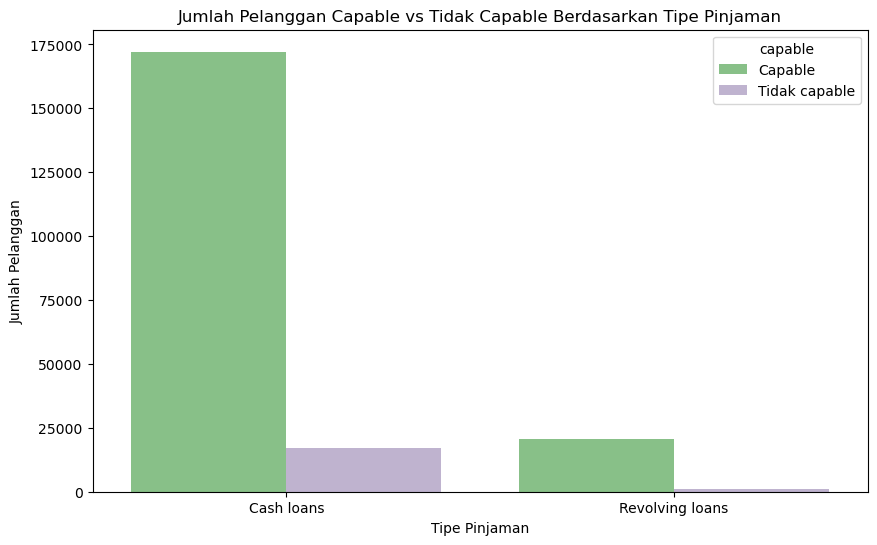

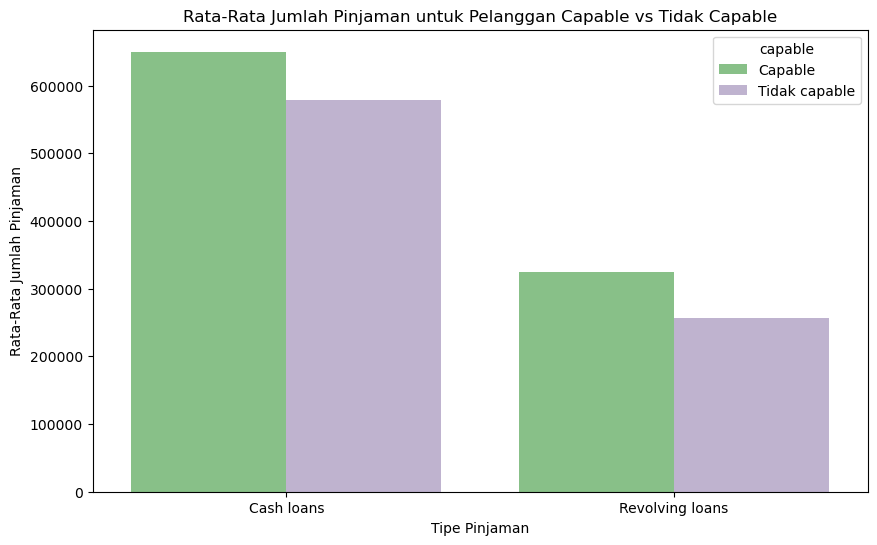

In [ ]:
# Filter data berdasarkan tipe pinjaman
cash_loans = train[train['NAME_CONTRACT_TYPE'] == 'Cash loans']
revolving_loans = train[train['NAME_CONTRACT_TYPE'] == 'Revolving loans']

# Menambahkan kolom yang menunjukkan apakah pelanggan capable atau tidak (0: capable, 1: tidak capable)
cash_loans['capable'] = cash_loans['TARGET'].apply(lambda x: 'Tidak capable' if x == 1 else 'Capable')
revolving_loans['capable'] = revolving_loans['TARGET'].apply(lambda x: 'Tidak capable' if x == 1 else 'Capable')

# Membuat summary statistik untuk membandingkan
cash_summary = cash_loans.groupby('capable').agg({
    'AMT_CREDIT': ['mean', 'median'],
    'AMT_INCOME_TOTAL': ['mean', 'median'],
    'SK_ID_CURR': 'count'
}).reset_index()

revolving_summary = revolving_loans.groupby('capable').agg({
    'AMT_CREDIT': ['mean', 'median'],
    'AMT_INCOME_TOTAL': ['mean', 'median'],
    'SK_ID_CURR': 'count'
}).reset_index()

# Menampilkan hasil
print("Summary Cash Loans:")
print(cash_summary)

print("\nSummary Revolving Loans:")
print(revolving_summary)

# Menghitung jumlah pelanggan yang capable dan tidak capable untuk tiap jenis pinjaman
cash_count = cash_loans['capable'].value_counts().reset_index()
cash_count.columns = ['capable', 'count']
cash_count['loan_type'] = 'Cash loans'

revolving_count = revolving_loans['capable'].value_counts().reset_index()
revolving_count.columns = ['capable', 'count']
revolving_count['loan_type'] = 'Revolving loans'

# Menggabungkan data untuk membuat barplot
count_data = pd.concat([cash_count, revolving_count])

# Membuat barplot jumlah pelanggan capable dan tidak capable
plt.figure(figsize=(10, 6))
sns.barplot(data=count_data, x='loan_type', y='count', hue='capable')
sns.set_palette("Accent")
plt.title('Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Tipe Pinjaman')
plt.xlabel('Tipe Pinjaman')
plt.ylabel('Jumlah Pelanggan')
plt.show()

# Membuat grafik rata-rata jumlah pinjaman untuk pelanggan capable dan tidak capable
cash_avg_credit = cash_loans.groupby('capable')['AMT_CREDIT'].mean().reset_index()
cash_avg_credit['loan_type'] = 'Cash loans'

revolving_avg_credit = revolving_loans.groupby('capable')['AMT_CREDIT'].mean().reset_index()
revolving_avg_credit['loan_type'] = 'Revolving loans'

# Menggabungkan data untuk membuat barplot
avg_credit_data = pd.concat([cash_avg_credit, revolving_avg_credit])

# Membuat barplot rata-rata jumlah pinjaman
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_credit_data, x='loan_type', y='AMT_CREDIT', hue='capable')
plt.title('Rata-Rata Jumlah Pinjaman untuk Pelanggan Capable vs Tidak Capable')
plt.xlabel('Tipe Pinjaman')
plt.ylabel('Rata-Rata Jumlah Pinjaman')
plt.show()

Berdasarkan grafik "Rata-Rata Jumlah Pinjaman untuk Pelanggan Capable vs Tidak Capable", berikut adalah beberapa insight penting:

1. Jenis Pinjaman:
- Grafik membandingkan dua jenis pinjaman: Cash loans dan Revolving loans.
- Cash loans memiliki rata-rata jumlah pinjaman yang jauh lebih tinggi dibandingkan Revolving loans untuk kedua kategori pelanggan.

2. Perbedaan Capable vs Tidak Capable: <br>

    a. Untuk Cash loans:
- Pelanggan Capable memiliki rata-rata pinjaman sekitar 650,000 (unit mata uang tidak disebutkan).
- Pelanggan Tidak Capable memiliki rata-rata pinjaman sekitar 580,000. <br>

    b. Untuk Revolving loans:
- Pelanggan Capable memiliki rata-rata pinjaman sekitar 330,000.
- Pelanggan Tidak Capable memiliki rata-rata pinjaman sekitar 260,000.

3. Pola Konsistensi:
- Baik untuk Cash loans maupun Revolving loans, pelanggan yang Capable cenderung memiliki rata-rata pinjaman yang lebih tinggi dibandingkan pelanggan yang Tidak Capable.

4. Selisih Pinjaman:
- Selisih rata-rata pinjaman antara Capable dan Tidak Capable lebih besar pada Cash loans dibandingkan Revolving loans.

5. Preferensi Produk:
- Cash loans memiliki rata-rata pinjaman yang jauh lebih tinggi, menunjukkan bahwa produk ini mungkin lebih populer atau digunakan untuk kebutuhan yang memerlukan dana lebih besar.

6. Risiko dan Kapasitas:
- Meskipun pelanggan Tidak Capable memiliki rata-rata pinjaman yang lebih rendah, mereka masih mendapatkan akses ke pinjaman yang cukup substansial, terutama untuk Cash loans.

7. Strategi Pinjaman:
- Bank atau lembaga keuangan mungkin menggunakan strategi pemberian pinjaman yang berbeda untuk pelanggan Capable dan Tidak Capable, dengan memberikan jumlah yang lebih tinggi kepada pelanggan Capable.

8. Potensi Pengembangan Produk:
- Ada perbedaan signifikan antara rata-rata pinjaman Cash loans dan Revolving loans, yang mungkin menunjukkan kebutuhan atau preferensi pelanggan yang berbeda untuk kedua produk ini.

9. Manajemen Risiko:
- Pemberian pinjaman yang lebih tinggi kepada pelanggan Capable menunjukkan pendekatan manajemen risiko yang lebih konservatif, namun masih ada eksposur risiko yang signifikan pada pelanggan Tidak Capable.

10. Peluang Bisnis:
- Ada potensi untuk meningkatkan jumlah pinjaman Revolving loans, terutama untuk pelanggan Capable, jika diidentifikasi bahwa produk ini memiliki risiko yang lebih rendah atau margin yang lebih tinggi.

## CODE_GENDER
Membandingkan customers berdasarkan gender

In [ ]:
train[categorical].info()

<class 'pandas.core.frame.DataFrame'>
Index: 211120 entries, 0 to 307510
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   NAME_CONTRACT_TYPE   211120 non-null  object
 1   CODE_GENDER          211120 non-null  object
 2   FLAG_OWN_CAR         211120 non-null  object
 3   FLAG_OWN_REALTY      211120 non-null  object
 4   NAME_INCOME_TYPE     211120 non-null  object
 5   NAME_EDUCATION_TYPE  211120 non-null  object
 6   NAME_FAMILY_STATUS   211120 non-null  object
 7   NAME_HOUSING_TYPE    211120 non-null  object
 8   OCCUPATION_TYPE      211120 non-null  object
 9   ORGANIZATION_TYPE    211120 non-null  object
dtypes: object(10)
memory usage: 17.7+ MB


In [ ]:
train['CODE_GENDER'].isnull().any()

False

In [ ]:
train['CODE_GENDER']

0         M
1         F
2         M
3         F
4         M
         ..
307504    F
307506    M
307508    F
307509    F
307510    F
Name: CODE_GENDER, Length: 211120, dtype: object

In [ ]:
train['CODE_GENDER'].value_counts()/len(train['CODE_GENDER'])*100

CODE_GENDER
F      61.236264
M      38.762789
XNA     0.000947
Name: count, dtype: float64

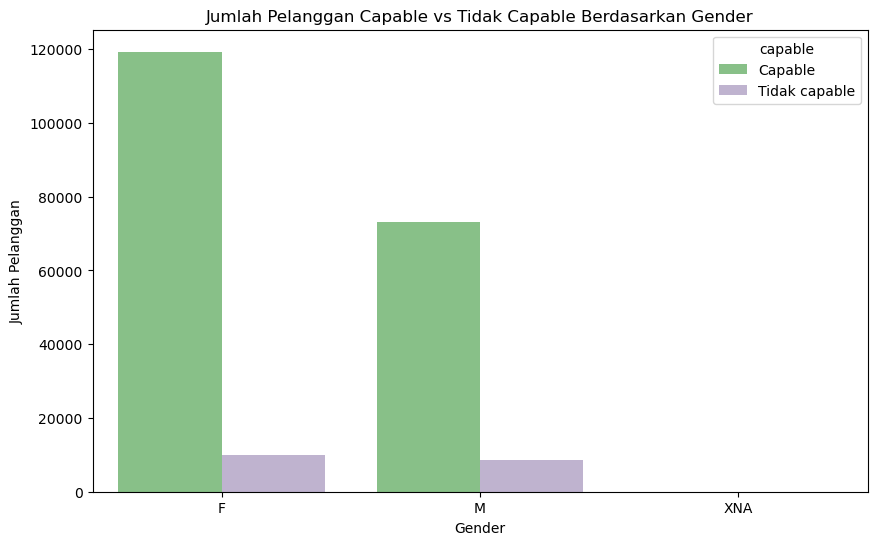

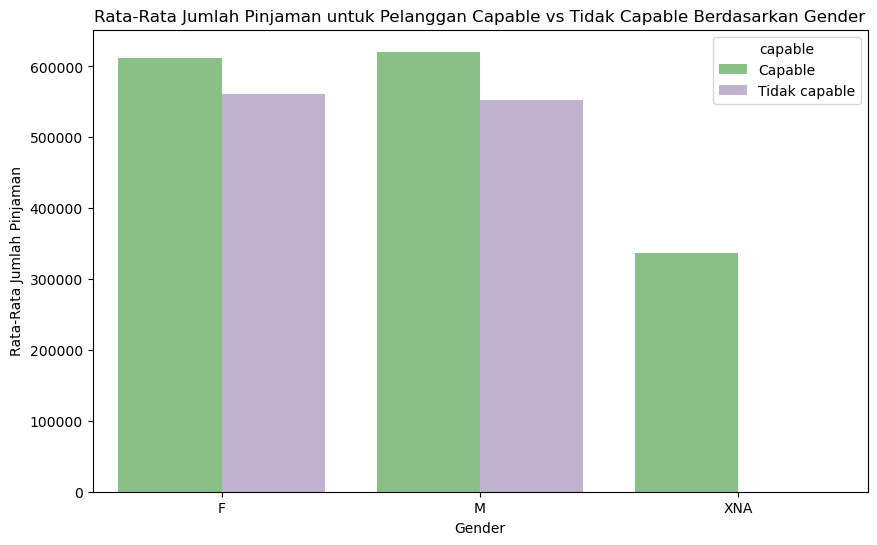

In [ ]:
# Menambahkan kolom yang menunjukkan apakah pelanggan capable atau tidak (0: capable, 1: tidak capable)
train['capable'] = train['TARGET'].apply(lambda x: 'Tidak capable' if x == 1 else 'Capable')

# Menghitung jumlah pelanggan yang capable dan tidak capable berdasarkan gender
gender_count = train.groupby(['CODE_GENDER', 'capable'])['SK_ID_CURR'].count().reset_index()
gender_count.columns = ['gender', 'capable', 'count']

# Membuat barplot jumlah pelanggan capable dan tidak capable berdasarkan gender
plt.figure(figsize=(10, 6))
sns.barplot(data=gender_count, x='gender', y='count', hue='capable')
sns.set_palette("Accent")
plt.title('Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Gender')
plt.xlabel('Gender')
plt.ylabel('Jumlah Pelanggan')
plt.show()

# Menghitung rata-rata jumlah pinjaman (AMT_CREDIT) untuk pelanggan capable dan tidak capable berdasarkan gender
gender_avg_credit = train.groupby(['CODE_GENDER', 'capable'])['AMT_CREDIT'].mean().reset_index()

# Membuat barplot rata-rata jumlah pinjaman untuk pelanggan capable dan tidak capable berdasarkan gender
plt.figure(figsize=(10, 6))
sns.barplot(data=gender_avg_credit, x='CODE_GENDER', y='AMT_CREDIT', hue='capable')
sns.set_palette("Accent")
plt.title('Rata-Rata Jumlah Pinjaman untuk Pelanggan Capable vs Tidak Capable Berdasarkan Gender')
plt.xlabel('Gender')
plt.ylabel('Rata-Rata Jumlah Pinjaman')
plt.show()


Berdasarkan grafik "Rata-Rata Jumlah Pinjaman untuk Pelanggan Capable vs Tidak Capable Berdasarkan Gender", berikut adalah beberapa insight penting:

1. Kategori Gender:
- Grafik menampilkan tiga kagetori gender: F (female), M (Male), dan XNA (tidak diketahui)

2. Perbedaan Capable vs Tidak Capable:
- Untuk semua kategori gender, nasabah capable memiliki rata - rata jumlah pinjaman yang lebih tinggi dari pada nasabah yang tidak capable.

3. Perbedaan gender:
- Secara rata - rata, laki - laki memiliki jumlah pinjaman yang lebih tinggi baik itu capable maupun tidak capable namun selisih dengan Perempuan tidak terlalu jauh signifikan.
- Secara jumlah nasabahnya, perempuan memiliki jumlah nasabah yang sangat banyak dibandingkan gender lainnya untuk mereka yang capable, disatu sisi, jumlah nasabah yang tidak capable hampir seimbang dengan jumlah tidak capable nasabah laki - laki.
- XNA hanya memiliki jumlah yang capable saja dibandingkan yang tidak capable

4. Peluang bisnis:
- Jumlah nasabah HomeCredit berdasarkan Gender itu sebanyak 61.2% didominasi oleh perempuan , sebanyak 38.8% adalah pria, dan sisanya sebesar 0.001 adalah XNA. Hal ini menunjukan bahwa ada kecenderungan bias terhadap nasabah perempuan atau banyak perempuan yang senang menggunakan HomeCredit dibandingkan laki - laki.

## FLAG_OWN_CAR
Membandingkan Customers berdasarkan kepemilikan kendaraan

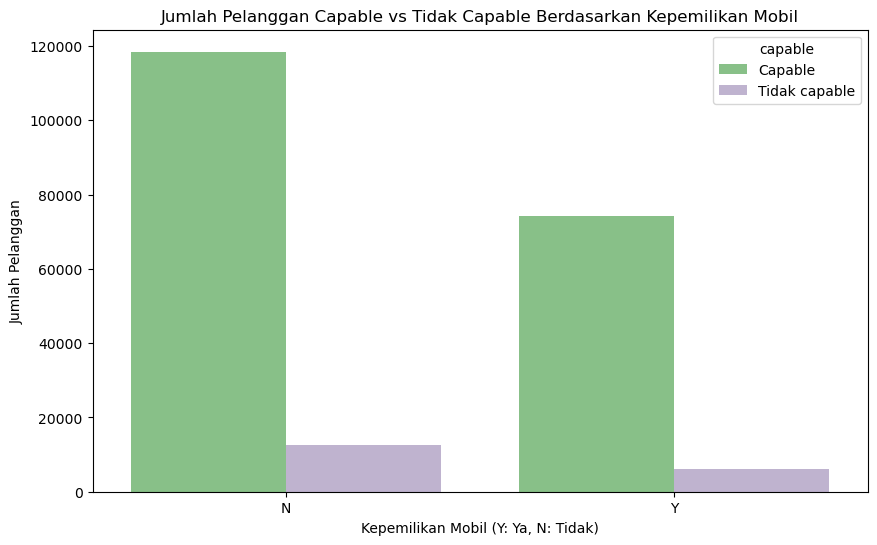

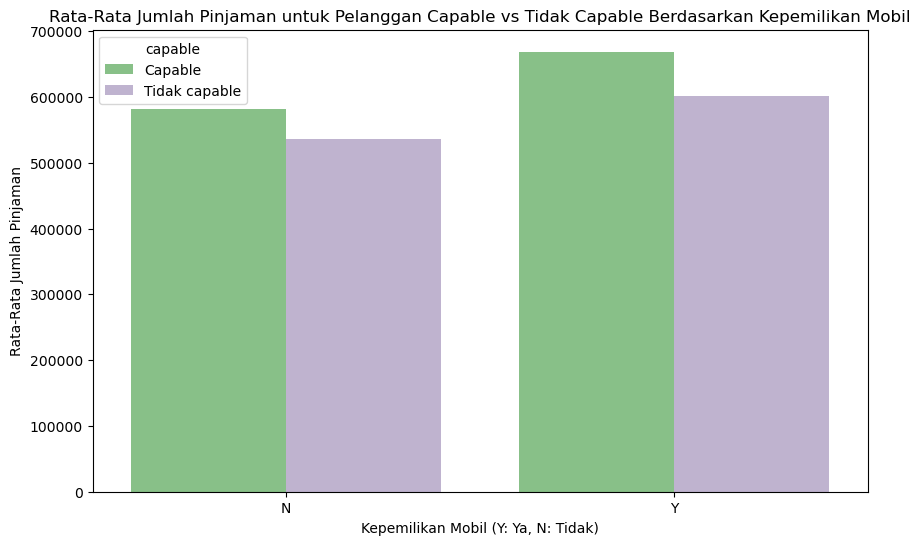

In [ ]:
# Menambahkan kolom yang menunjukkan apakah pelanggan capable atau tidak (0: capable, 1: tidak capable)
train['capable'] = train['TARGET'].apply(lambda x: 'Tidak capable' if x == 1 else 'Capable')

# Menghitung jumlah pelanggan yang capable dan tidak capable berdasarkan kepemilikan mobil (FLAG_OWN_CAR)
car_count = train.groupby(['FLAG_OWN_CAR', 'capable'])['SK_ID_CURR'].count().reset_index()
car_count.columns = ['own_car', 'capable', 'count']

# Membuat barplot jumlah pelanggan capable dan tidak capable berdasarkan kepemilikan mobil
plt.figure(figsize=(10, 6))
sns.barplot(data=car_count, x='own_car', y='count', hue='capable', palette='Accent')
sns.set_palette("Accent")
plt.title('Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Kepemilikan Mobil')
plt.xlabel('Kepemilikan Mobil (Y: Ya, N: Tidak)')
plt.ylabel('Jumlah Pelanggan')
plt.show()

# Menghitung rata-rata jumlah pinjaman (AMT_CREDIT) untuk pelanggan capable dan tidak capable berdasarkan kepemilikan mobil
car_avg_credit = train.groupby(['FLAG_OWN_CAR', 'capable'])['AMT_CREDIT'].mean().reset_index()

# Membuat barplot rata-rata jumlah pinjaman untuk pelanggan capable dan tidak capable berdasarkan kepemilikan mobil
plt.figure(figsize=(10, 6))
sns.barplot(data=car_avg_credit, x='FLAG_OWN_CAR', y='AMT_CREDIT', hue='capable', palette='Accent')
sns.set_palette("Accent")
plt.title('Rata-Rata Jumlah Pinjaman untuk Pelanggan Capable vs Tidak Capable Berdasarkan Kepemilikan Mobil')
plt.xlabel('Kepemilikan Mobil (Y: Ya, N: Tidak)')
plt.ylabel('Rata-Rata Jumlah Pinjaman')
plt.show()


### Observasi:

1. **Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Kepemilikan Mobil**:
   - Sebagian besar pemohon pinjaman **tidak memiliki mobil** (ditandai dengan 0 pada grafik).
   - Namun, tidak ada perbedaan yang signifikan dalam status pembayaran pinjaman antara pelanggan yang memiliki dan tidak memiliki mobil. Baik yang memiliki mobil maupun yang tidak, proporsi pelanggan **capable** (mampu membayar) jauh lebih besar daripada yang **tidak capable** (tidak mampu membayar).
   - Dengan demikian, kepemilikan mobil tampaknya bukan faktor penentu yang kuat dalam mempengaruhi kemampuan pembayaran pinjaman.

2. **Rata-Rata Jumlah Pinjaman untuk Pelanggan Capable vs Tidak Capable Berdasarkan Kepemilikan Mobil**:
   - Rata-rata jumlah pinjaman untuk pelanggan **capable** sedikit lebih tinggi dibandingkan pelanggan **tidak capable**.
   - Baik pelanggan yang memiliki mobil maupun yang tidak, **jumlah pinjaman yang mereka ambil relatif sama**, dengan perbedaan kecil antara kategori capable dan tidak capable.
   - Oleh karena itu, fitur kepemilikan mobil tidak terlalu signifikan dalam membedakan jumlah pinjaman yang diambil oleh pelanggan.

Kesimpulannya, **kepemilikan mobil** bukanlah fitur yang sangat berguna untuk memprediksi kemampuan pembayaran pinjaman ataupun menentukan jumlah pinjaman yang diambil pelanggan.

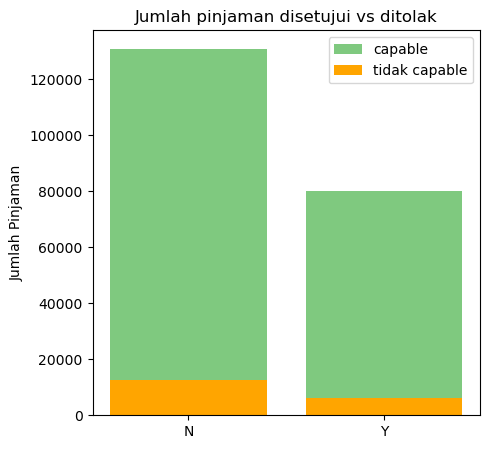

  FLAG_OWN_CAR  TARGET   total       Avg
0            N   12485  130939  0.095350
1            Y    6062   80181  0.075604
  FLAG_OWN_CAR  TARGET   total       Avg
0            N   12485  130939  0.095350
1            Y    6062   80181  0.075604


In [ ]:
# Fungsi untuk membuat stacked bar plot
def stack_plot(data, xtick, col2='TARGET', col3='total'):
    ind = np.arange(data.shape[0])

    # Mengatur ukuran gambar berdasarkan jumlah kategori unik
    if len(data[xtick].unique()) < 5:
        plt.figure(figsize=(5, 5))
    elif 5 <= len(data[xtick].unique()) < 10:
        plt.figure(figsize=(7, 7))
    else:
        plt.figure(figsize=(15, 15))

    # Membuat baris bertumpuk (stacked bar plot)
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values, color='orange')

    plt.ylabel('Jumlah Pinjaman')
    sns.set_palette("Accent")
    plt.title('Jumlah pinjaman disetujui vs ditolak')
    plt.xticks(ticks=ind, rotation=0, labels=list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('capable', 'tidak capable'))
    plt.show()

# Fungsi untuk membuat univariate bar plot
def univariate_barplots(data, col1, col2='TARGET', top=False):
    # Menghitung jumlah pinjaman yang ditolak dan total pinjaman
    temp = pd.DataFrame(data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Total pinjaman
    temp['total'] = pd.DataFrame(data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    # Rata-rata dari kolom target
    temp['Avg'] = pd.DataFrame(data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']

    temp.sort_values(by=['total'], inplace=True, ascending=False)

    # Jika top = True, ambil hanya beberapa baris teratas
    if top:
        temp = temp[0:top]

    # Membuat stacked bar plot
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))  # Menampilkan 5 baris teratas
    print("="*50)
    print(temp.tail(5))  # Menampilkan 5 baris terbawah

# Menerapkan fungsi pada kolom FLAG_OWN_CAR
univariate_barplots(train, 'FLAG_OWN_CAR', 'TARGET', False)


### Observasi:

1. **Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Kepemilikan Mobil**:
   - Sebagian besar pemohon pinjaman **tidak memiliki mobil** (ditandai dengan angka 0 pada sumbu x), dengan jumlah pemohon **capable** (mampu membayar pinjaman) yang jauh lebih besar dibandingkan dengan pemohon **tidak capable** (tidak mampu membayar pinjaman).
   - Pemohon yang **memiliki mobil** (ditandai dengan angka 1 pada sumbu x) juga didominasi oleh pelanggan **capable**, meskipun proporsi **tidak capable** sedikit lebih rendah dibandingkan dengan yang tidak memiliki mobil.

2. **Rata-Rata Kemampuan Pembayaran Berdasarkan Kepemilikan Mobil**:
   - Rata-rata pemohon yang tidak memiliki mobil memiliki tingkat **capable** sebesar **8,5%**.
   - Untuk pemohon yang memiliki mobil, rata-rata **capable** adalah **7,2%**.

Kesimpulannya, meskipun ada perbedaan dalam proporsi pemohon yang mampu membayar antara pemilik mobil dan bukan pemilik mobil, **kepemilikan mobil** tidak menunjukkan dampak signifikan terhadap kemampuan pelanggan untuk membayar pinjaman.

## FLAG_OWN_REALTY
Membandingkan Customers berdasarkan Real Estate Ownership

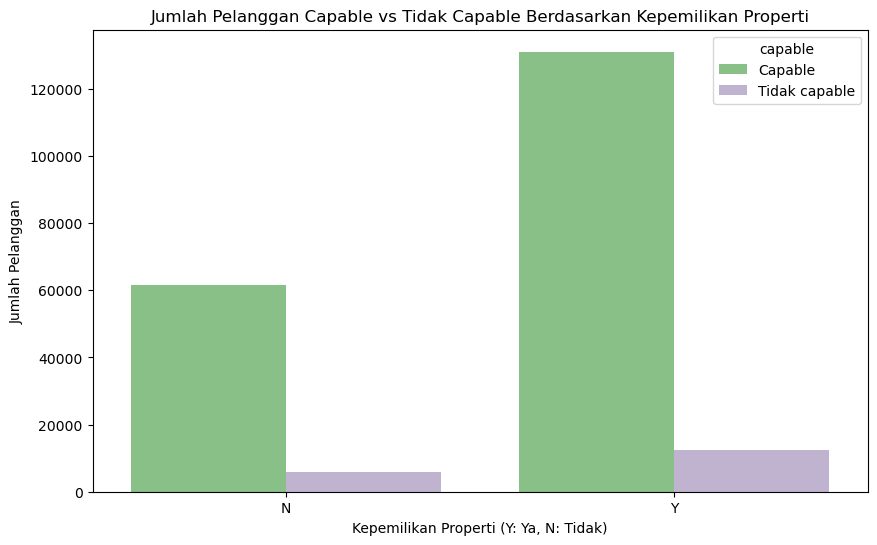

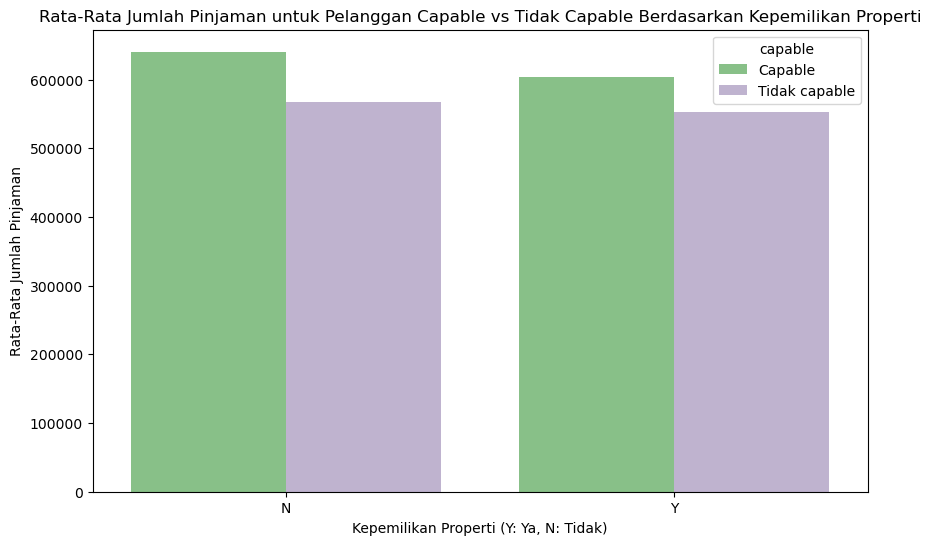

In [ ]:
# Menambahkan kolom yang menunjukkan apakah pelanggan capable atau tidak (0: capable, 1: tidak capable)
train['capable'] = train['TARGET'].apply(lambda x: 'Tidak capable' if x == 1 else 'Capable')

# Menghitung jumlah pelanggan yang capable dan tidak capable berdasarkan kepemilikan properti (FLAG_OWN_REALTY)
realty_count = train.groupby(['FLAG_OWN_REALTY', 'capable'])['SK_ID_CURR'].count().reset_index()
realty_count.columns = ['own_realty', 'capable', 'count']

# Membuat barplot jumlah pelanggan capable dan tidak capable berdasarkan kepemilikan properti
plt.figure(figsize=(10, 6))
sns.barplot(data=realty_count, x='own_realty', y='count', hue='capable', palette='Accent')
plt.title('Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Kepemilikan Properti')
plt.xlabel('Kepemilikan Properti (Y: Ya, N: Tidak)')
plt.ylabel('Jumlah Pelanggan')
plt.show()

# Menghitung rata-rata jumlah pinjaman (AMT_CREDIT) untuk pelanggan capable dan tidak capable berdasarkan kepemilikan properti
realty_avg_credit = train.groupby(['FLAG_OWN_REALTY', 'capable'])['AMT_CREDIT'].mean().reset_index()

# Membuat barplot rata-rata jumlah pinjaman untuk pelanggan capable dan tidak capable berdasarkan kepemilikan properti
plt.figure(figsize=(10, 6))
sns.barplot(data=realty_avg_credit, x='FLAG_OWN_REALTY', y='AMT_CREDIT', hue='capable', palette='Accent')
plt.title('Rata-Rata Jumlah Pinjaman untuk Pelanggan Capable vs Tidak Capable Berdasarkan Kepemilikan Properti')
plt.xlabel('Kepemilikan Properti (Y: Ya, N: Tidak)')
plt.ylabel('Rata-Rata Jumlah Pinjaman')
plt.show()


### Observasi:

1. **Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Kepemilikan Properti**:
   - Sebagian besar pemohon pinjaman memiliki properti (ditandai dengan 'Y' pada grafik).
   - Baik pelanggan yang memiliki properti maupun yang tidak, jumlah pelanggan yang **capable** (mampu membayar pinjaman) jauh lebih besar dibandingkan dengan yang **tidak capable** (tidak mampu membayar pinjaman).
   - Kepemilikan properti tidak menunjukkan perbedaan signifikan dalam mempengaruhi kemampuan pembayaran pinjaman.

2. **Rata-Rata Jumlah Pinjaman untuk Pelanggan Capable vs Tidak Capable Berdasarkan Kepemilikan Properti**:
   - Rata-rata jumlah pinjaman untuk pelanggan **capable** dan **tidak capable** hampir sama, baik untuk mereka yang memiliki properti maupun yang tidak.
   - Kepemilikan properti tidak mempengaruhi secara signifikan jumlah pinjaman yang diambil oleh pelanggan.

Kesimpulannya, **kepemilikan properti** tidak memiliki pengaruh yang signifikan terhadap kemampuan pelanggan untuk membayar pinjaman atau jumlah pinjaman yang mereka ambil.

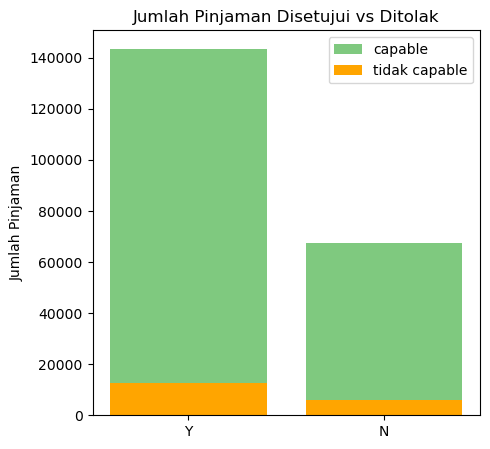

  FLAG_OWN_REALTY  TARGET   total       Avg
1               Y   12534  143600  0.087284
0               N    6013   67520  0.089055
  FLAG_OWN_REALTY  TARGET   total       Avg
1               Y   12534  143600  0.087284
0               N    6013   67520  0.089055


In [ ]:
# Fungsi untuk membuat stacked bar plot
def stack_plot(data, xtick, col2='TARGET', col3='total'):
    ind = np.arange(data.shape[0])

    if len(data[xtick].unique()) < 5:
        plt.figure(figsize=(5, 5))
    elif 5 <= len(data[xtick].unique()) < 10:
        plt.figure(figsize=(7, 7))
    else:
        plt.figure(figsize=(15, 15))

    # Membuat stacked bar plot
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values, color='orange')

    plt.ylabel('Jumlah Pinjaman')
    plt.title('Jumlah Pinjaman Disetujui vs Ditolak')
    plt.xticks(ticks=ind, rotation=0, labels=list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('capable', 'tidak capable'))
    plt.show()

# Fungsi untuk membuat univariate bar plot
def univariate_barplots(data, col1, col2='TARGET', top=False):
    # Menghitung jumlah pelanggan capable (TARGET=1) dan total pinjaman
    temp = pd.DataFrame(data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Total pinjaman
    temp['total'] = pd.DataFrame(data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    # Rata-rata kolom target
    temp['Avg'] = pd.DataFrame(data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']

    temp.sort_values(by=['total'], inplace=True, ascending=False)

    # Membatasi jika ada top data
    if top:
        temp = temp[0:top]

    # Membuat stacked bar plot
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))  # Menampilkan 5 data teratas
    print("="*50)
    print(temp.tail(5))  # Menampilkan 5 data terbawah

# Menggunakan dataset train sebagai pengganti train_data
univariate_barplots(train, 'FLAG_OWN_REALTY', 'TARGET', False)


### Observasi:

1. **Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Kepemilikan Properti**:
   - Sebagian besar pemohon pinjaman **memiliki properti** (ditandai dengan 'Y' pada grafik), dengan jumlah pemohon **capable** (mampu membayar pinjaman) yang jauh lebih besar dibandingkan dengan pemohon **tidak capable** (tidak mampu membayar pinjaman).
   - Untuk pemohon yang **tidak memiliki properti** (ditandai dengan 'N'), jumlah pemohon **capable** juga lebih besar daripada yang **tidak capable**, meskipun dalam jumlah yang lebih kecil secara keseluruhan dibandingkan mereka yang memiliki properti.

2. **Rata-Rata Kemampuan Pembayaran Berdasarkan Kepemilikan Properti**:
   - Pemohon yang **memiliki properti** memiliki tingkat **capable** sebesar **7,96%**, yang sedikit lebih rendah dibandingkan dengan pemohon yang **tidak memiliki properti**, yaitu **8,32%**.
   - Meskipun ada perbedaan kecil, rata-rata pemohon yang memiliki properti tetap mendominasi dalam jumlah keseluruhan pemohon pinjaman.

Kesimpulannya, **kepemilikan properti** tidak memiliki pengaruh signifikan terhadap kemampuan pembayaran pinjaman, meskipun jumlah pemohon yang memiliki properti jauh lebih besar dibandingkan mereka yang tidak memiliki properti.

## NAME_HOUSING_TYPE
Membandingkan Customers berdasarkan Housing Type

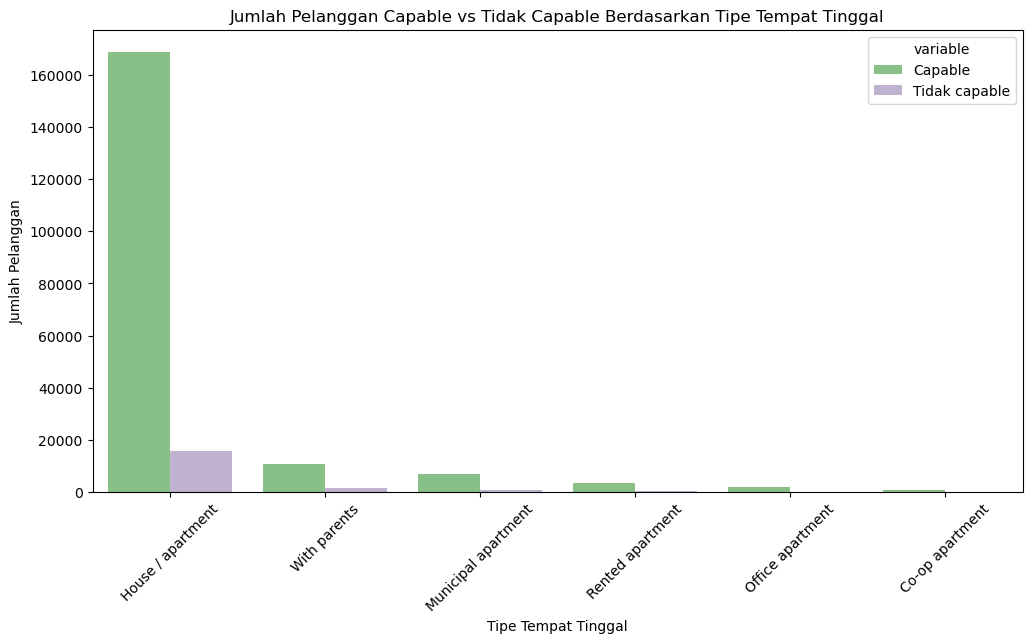

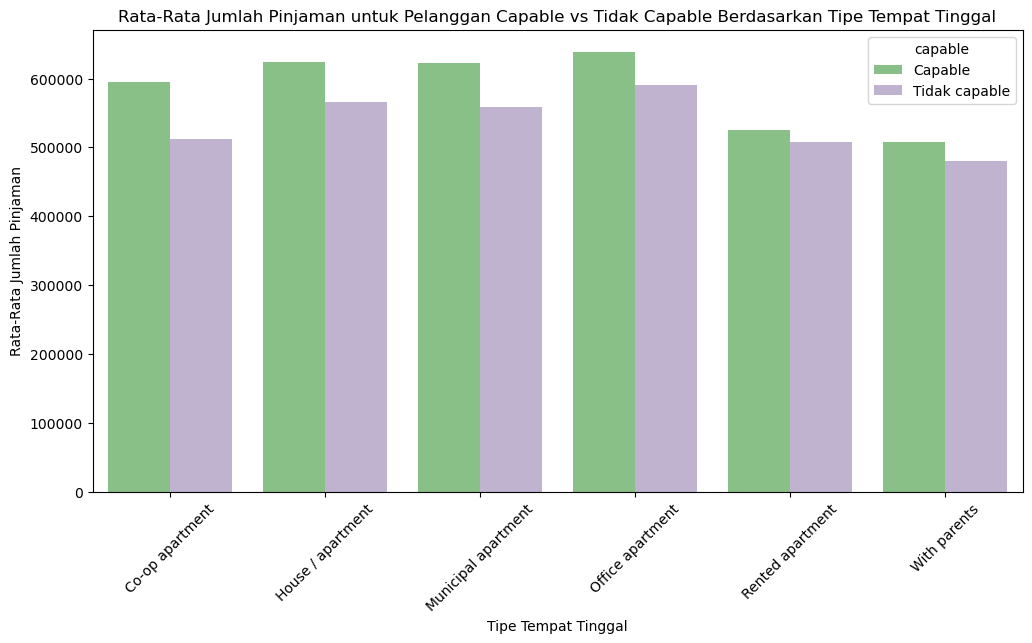

In [ ]:
# Menambahkan kolom yang menunjukkan apakah pelanggan capable atau tidak (0: capable, 1: tidak capable)
train['capable'] = train['TARGET'].apply(lambda x: 'Tidak capable' if x == 1 else 'Capable')

# Menghitung jumlah pelanggan yang capable dan tidak capable berdasarkan tipe tempat tinggal (NAME_HOUSING_TYPE)
housing_count = train.groupby(['NAME_HOUSING_TYPE', 'capable'])['SK_ID_CURR'].count().reset_index()
housing_count.columns = ['housing_type', 'capable', 'count']

# Pivot the data to have 'Capable' and 'Tidak capable' as columns
housing_count_pivot = housing_count.pivot(index='housing_type', columns='capable', values='count')
housing_count_pivot.columns.name = None
housing_count_pivot = housing_count_pivot.reset_index()

# Sort by the 'Capable' column in descending order
housing_count_pivot = housing_count_pivot.sort_values('Capable', ascending=False)

# Create the sorted bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=housing_count_pivot.melt(id_vars='housing_type'), 
            x='housing_type', y='value', hue='variable', palette='Accent')
plt.title('Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Tipe Tempat Tinggal')
plt.xlabel('Tipe Tempat Tinggal')
plt.ylabel('Jumlah Pelanggan')
plt.xticks(rotation=45)
plt.show()

# Menghitung rata-rata jumlah pinjaman (AMT_CREDIT) untuk pelanggan capable dan tidak capable berdasarkan tipe tempat tinggal
housing_avg_credit = train.groupby(['NAME_HOUSING_TYPE', 'capable'])['AMT_CREDIT'].mean().reset_index()
housing_avg_credit.columns = ['housing_type', 'capable', 'value']

housing_avg_credit_pivot = housing_avg_credit.pivot(index='housing_type', columns='capable', values='value')
housing_avg_credit_pivot.columns.name = None
housing_avg_credit_pivot = housing_avg_credit_pivot.reset_index()

# Membuat barplot rata-rata jumlah pinjaman untuk pelanggan capable dan tidak capable berdasarkan tipe tempat tinggal
plt.figure(figsize=(12, 6))
sns.barplot(data=housing_avg_credit, x='housing_type', y='value', hue='capable', palette='Accent')
plt.title('Rata-Rata Jumlah Pinjaman untuk Pelanggan Capable vs Tidak Capable Berdasarkan Tipe Tempat Tinggal')
plt.xlabel('Tipe Tempat Tinggal')
plt.ylabel('Rata-Rata Jumlah Pinjaman')
plt.xticks(rotation=45)
plt.show()


### Observasi:

1. **Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Tipe Tempat Tinggal**:
   - Sebagian besar pemohon pinjaman tinggal di **House / apartment**. Kategori ini memiliki jumlah pelanggan **capable** (mampu membayar pinjaman) yang jauh lebih besar dibandingkan dengan yang **tidak capable**.
   - Kategori tempat tinggal lainnya, seperti **Co-op apartment**, **Municipal apartment**, **Office apartment**, dan **Rented apartment**, memiliki jumlah pemohon yang jauh lebih sedikit, tetapi pola yang sama terlihat di mana jumlah pelanggan **capable** lebih tinggi daripada yang **tidak capable**.
   - Meskipun jumlah pemohon dari kategori tempat tinggal selain **House / apartment** relatif kecil, mereka tetap menunjukkan kecenderungan yang sama terkait kemampuan pembayaran.

2. **Rata-Rata Jumlah Pinjaman untuk Pelanggan Capable vs Tidak Capable Berdasarkan Tipe Tempat Tinggal**:
   - Secara umum, **rata-rata jumlah pinjaman** yang diberikan kepada pelanggan **capable** dan **tidak capable** serupa untuk semua kategori tipe tempat tinggal.
   - Tidak ada perbedaan yang mencolok dalam jumlah pinjaman yang diambil oleh pelanggan berdasarkan tipe tempat tinggal mereka, baik untuk yang **capable** maupun yang **tidak capable**.
   
Kesimpulannya, meskipun **House / apartment** merupakan kategori tempat tinggal yang paling umum di antara pemohon pinjaman, tipe tempat tinggal tidak menunjukkan perbedaan signifikan dalam kemampuan pelanggan untuk membayar pinjaman ataupun dalam jumlah pinjaman yang mereka ambil.

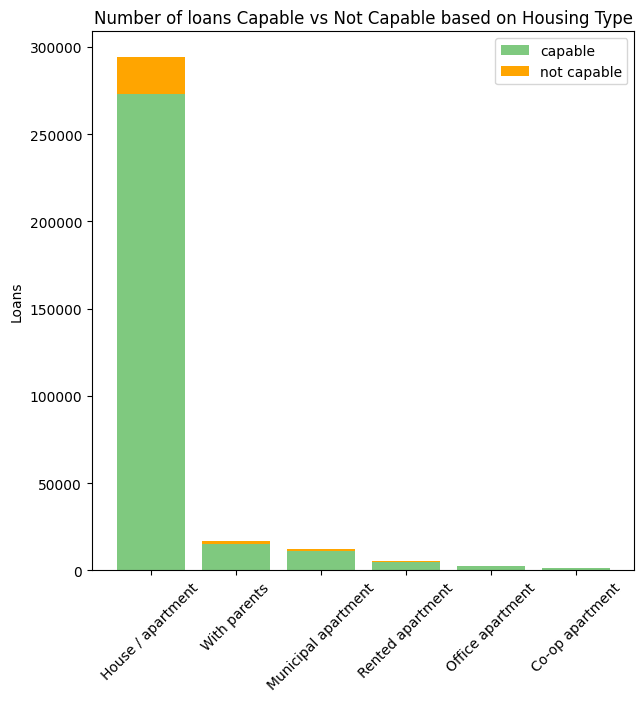

     NAME_HOUSING_TYPE  TARGET   total       Avg
1    House / apartment   21272  272868  0.077957
5         With parents    1736   14840  0.116981
2  Municipal apartment     955   11183  0.085397
4     Rented apartment     601    4881  0.123131
3     Office apartment     172    2617  0.065724
     NAME_HOUSING_TYPE  TARGET  total       Avg
5         With parents    1736  14840  0.116981
2  Municipal apartment     955  11183  0.085397
4     Rented apartment     601   4881  0.123131
3     Office apartment     172   2617  0.065724
0      Co-op apartment      89   1122  0.079323


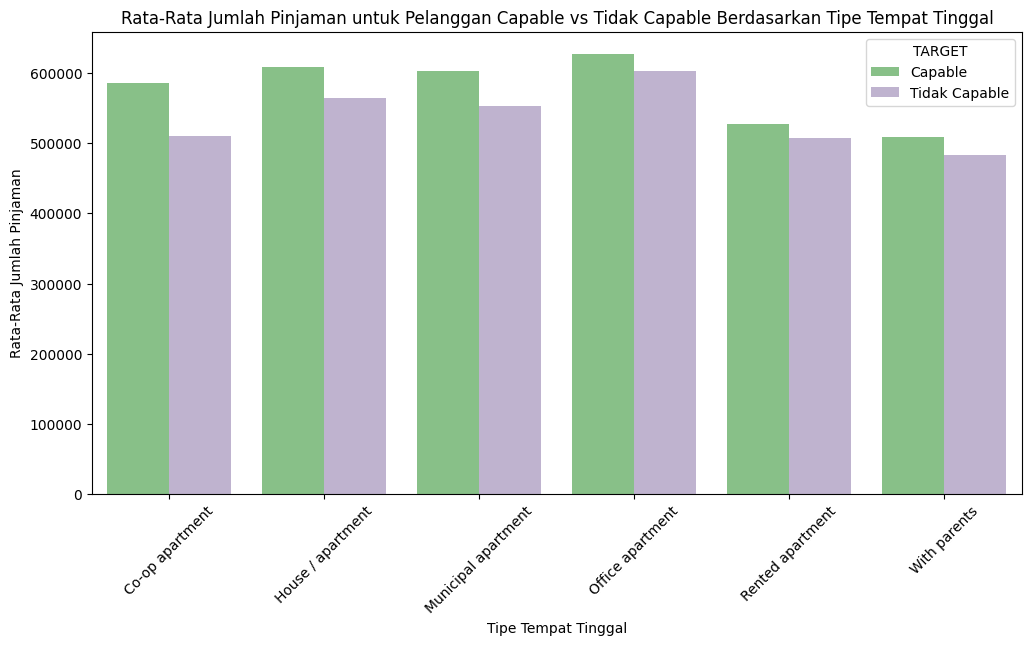

In [ ]:
# Fungsi untuk membuat stacked bar plot
def stack_plot(data, xtick, col2='TARGET', col3='total'):
    ind = np.arange(data.shape[0])

    if len(data[xtick].unique()) < 5:
        plt.figure(figsize=(5, 5))
    elif 5 <= len(data[xtick].unique()) < 10:
        plt.figure(figsize=(7, 7))
    else:
        plt.figure(figsize=(15, 15))

    # Membuat stacked bar plot
    p1 = plt.bar(ind, data[col3].values, label='capable')
    p2 = plt.bar(ind, data[col2].values, bottom=data[col3].values, color='orange', label='not capable')

    plt.ylabel('Loans')
    plt.title('Number of loans Capable vs Not Capable based on Housing Type')
    plt.xticks(ticks=ind, rotation=45, labels=list(data[xtick].values))
    plt.legend()
    plt.show()

# Fungsi untuk membuat univariate bar plot
def univariate_barplots(data, col1, col2='TARGET', top=False):
    # Menghitung jumlah pelanggan capable (TARGET=1) dan total pinjaman
    temp = pd.DataFrame(data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Total pinjaman
    temp['total'] = pd.DataFrame(data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    # Rata-rata kolom target
    temp['Avg'] = pd.DataFrame(data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']

    temp.sort_values(by=['total'], inplace=True, ascending=False)

    # Membatasi jika ada top data
    if top:
        temp = temp[0:top]

    # Membuat stacked bar plot
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))  # Menampilkan 5 data teratas
    print("="*50)
    print(temp.tail(5))  # Menampilkan 5 data terbawah

# Contoh pengaplikasian pada kolom NAME_HOUSING_TYPE
univariate_barplots(train, 'NAME_HOUSING_TYPE', 'TARGET', False)

# Membandingkan rata-rata jumlah pinjaman untuk setiap tipe tempat tinggal
housing_avg_credit = train.groupby(['NAME_HOUSING_TYPE', 'TARGET'])['AMT_CREDIT'].mean().reset_index()
housing_avg_credit['TARGET'] = housing_avg_credit['TARGET'].map({0: 'Capable', 1: 'Tidak Capable'})

# Membuat barplot rata-rata jumlah pinjaman untuk pelanggan capable dan tidak capable berdasarkan tipe tempat tinggal
plt.figure(figsize=(12, 6))
sns.barplot(data=housing_avg_credit, x='NAME_HOUSING_TYPE', y='AMT_CREDIT', hue='TARGET', palette='Accent')
plt.title('Rata-Rata Jumlah Pinjaman untuk Pelanggan Capable vs Tidak Capable Berdasarkan Tipe Tempat Tinggal')
plt.xlabel('Tipe Tempat Tinggal')
plt.ylabel('Rata-Rata Jumlah Pinjaman')
plt.xticks(rotation=45)
plt.show()


### Observasi:

1. **Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Tipe Tempat Tinggal**:
   - Mayoritas pemohon pinjaman tinggal di **house/apartment** dengan jumlah pelanggan **capable** yang jauh lebih besar dibandingkan dengan pelanggan **tidak capable**.
   - Tipe tempat tinggal **with parents** dan **municipal apartment** juga memiliki jumlah pemohon yang signifikan, dengan perbandingan pelanggan **capable** yang lebih besar, meskipun proporsi **tidak capable** lebih tinggi dibandingkan tipe tempat tinggal lainnya.
   - Tipe tempat tinggal lainnya seperti **rented apartment**, **office apartment**, dan **co-op apartment** memiliki jumlah pemohon yang jauh lebih sedikit, namun tren serupa terlihat dengan lebih banyak pelanggan **capable** dibandingkan **tidak capable**.

2. **Rata-Rata Kemampuan Pembayaran Berdasarkan Tipe Tempat Tinggal**:
   - Rata-rata pelanggan yang tinggal di **rented apartment** dan **with parents** memiliki tingkat **tidak capable** yang lebih tinggi dibandingkan tipe tempat tinggal lainnya, masing-masing sebesar **12.31%** dan **11.69%**.
   - Pelanggan yang tinggal di **house/apartment** memiliki tingkat **tidak capable** yang relatif rendah, yaitu sekitar **7.79%**.
   - Tipe tempat tinggal seperti **municipal apartment** dan **office apartment** juga menunjukkan rata-rata yang lebih rendah dalam hal tingkat **tidak capable**, yaitu masing-masing **8.53%** dan **6.57%**.

Kesimpulannya, **tipe tempat tinggal** memiliki pengaruh yang cukup signifikan terhadap kemampuan pembayaran pinjaman, dengan pemohon yang tinggal di **rented apartment** dan **with parents** cenderung memiliki risiko lebih tinggi untuk tidak mampu membayar pinjaman.

## NAME_FAMILY_STATUS

In [ ]:
def eda_univariate_family_status(data_t):
    # 1. Statistik Deskriptif
    print("Statistik Deskriptif untuk Status Keluarga:")
    family_status_counts = data_t['NAME_FAMILY_STATUS'].value_counts()
    total_count = family_status_counts.sum()

    # Cetak statistik deskriptif dalam bentuk tabel
    print(family_status_counts)

    # 2. Persentase dan Distribusi
    print("\nPersentase Kategori 'NAME_FAMILY_STATUS':")
    percentages = (family_status_counts / total_count) * 100
    for category, percentage in percentages.items():
        print(f"- '{category}': {percentage:.1f}%")

    # 3. Visualisasi Frekuensi Status Keluarga
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=family_status_counts.index,
        y=family_status_counts.values,
        palette="coolwarm",
        order=family_status_counts.index
    )
    plt.title('Frequency of Family Status', fontsize=18, weight='bold')
    plt.xlabel('Family Status', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, max(family_status_counts.values) * 1.1)

    # Tambahkan label jumlah dan persentase di atas bar
    for i, count in enumerate(family_status_counts):
        percentage = percentages[i]
        plt.text(i, count + 500, f'{count}\n({percentage:.1f}%)', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # 4. Observasi Berdasarkan Data
    print("\nObservasi Berdasarkan Data:")
    print("Bar Chart yang disediakan memvisualisasikan frekuensi status keluarga di antara individu dalam dataset Home Credit.")
    print(f"Grafik ini menunjukkan bahwa sebagian besar individu ({percentages['Married']:.1f}%) berstatus 'Married', dengan total sebanyak {family_status_counts['Married']} orang.")
    print("Sebaliknya, kategori lainnya seperti 'Single/not married', 'Civil marriage', 'Separated', dan 'Widow' memiliki frekuensi yang jauh lebih rendah.")
    print(f"- 'Single/not married' mencakup {percentages['Single / not married']:.1f}%, dengan total {family_status_counts['Single / not married']} orang.")
    print(f"- 'Civil marriage' mencakup {percentages['Civil marriage']:.1f}%, dengan total {family_status_counts['Civil marriage']} orang.")
    print(f"- 'Separated' mencakup {percentages['Separated']:.1f}%, dengan total {family_status_counts['Separated']} orang.")
    print(f"- 'Widow' mencakup {percentages['Widow']:.1f}%, dengan total {family_status_counts['Widow']} orang.")


Statistik Deskriptif untuk Status Keluarga:
NAME_FAMILY_STATUS
Married                 138000
Single / not married     32451
Civil marriage           21981
Separated                13239
Widow                     5447
Unknown                      2
Name: count, dtype: int64

Persentase Kategori 'NAME_FAMILY_STATUS':
- 'Married': 65.4%
- 'Single / not married': 15.4%
- 'Civil marriage': 10.4%
- 'Separated': 6.3%
- 'Widow': 2.6%
- 'Unknown': 0.0%


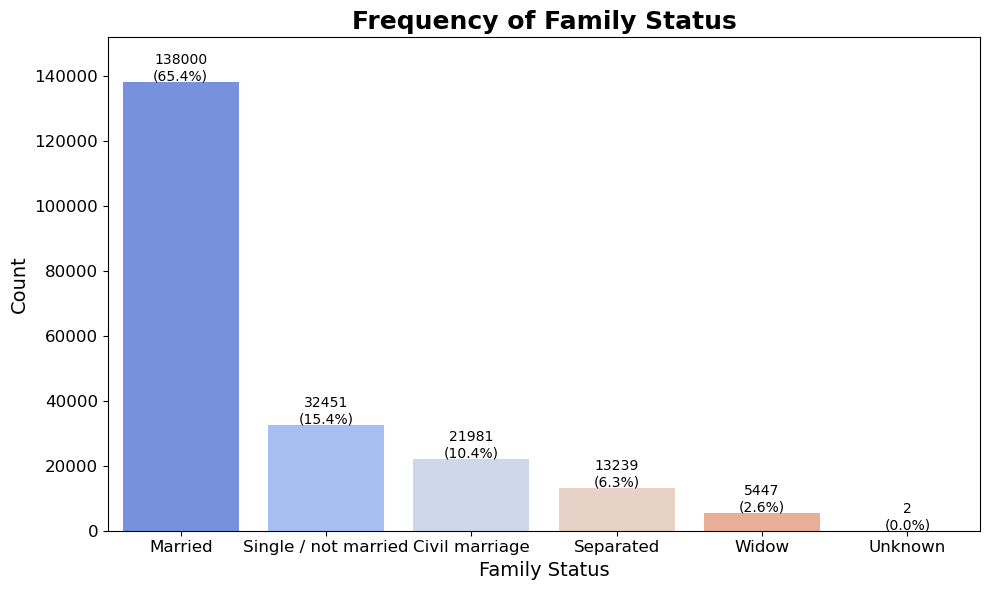


Observasi Berdasarkan Data:
Bar Chart yang disediakan memvisualisasikan frekuensi status keluarga di antara individu dalam dataset Home Credit.
Grafik ini menunjukkan bahwa sebagian besar individu (65.4%) berstatus 'Married', dengan total sebanyak 138000 orang.
Sebaliknya, kategori lainnya seperti 'Single/not married', 'Civil marriage', 'Separated', dan 'Widow' memiliki frekuensi yang jauh lebih rendah.
- 'Single/not married' mencakup 15.4%, dengan total 32451 orang.
- 'Civil marriage' mencakup 10.4%, dengan total 21981 orang.
- 'Separated' mencakup 6.3%, dengan total 13239 orang.
- 'Widow' mencakup 2.6%, dengan total 5447 orang.


In [ ]:
eda_univariate_family_status(train)

## CNT_FAM_MEMBERS

In [ ]:
def eda_univariate_family_members(data_t):
  # Ensure CNT_FAM_MEMBERS is integer type
  data_t['CNT_FAM_MEMBERS'] = data_t['CNT_FAM_MEMBERS'].astype(int)

  # 1. Descriptive Statistics
  desc_stats = data_t['CNT_FAM_MEMBERS'].describe()
  print("Descriptive Statistics for CNT_FAM_MEMBERS:")
  print(desc_stats)

  # Set up the figure
  plt.figure(figsize=(18, 8))

  # 2. Histogram
  plt.subplot(1, 2, 1)
  max_members = int(data_t['CNT_FAM_MEMBERS'].max())
  bins = range(1, max_members + 2)
  sns.histplot(data_t['CNT_FAM_MEMBERS'], bins=bins, kde=False, color='skyblue', edgecolor='black')  # Added KDE
  plt.title('Histogram of Family Members', fontsize=16)
  plt.xlabel('Number of Family Members', fontsize=14)
  plt.ylabel('Count', fontsize=14)
  plt.xticks(range(1, max_members + 1))

  # 3. Bar plot
  # Count the occurrences of each category in CNT_FAM_MEMBERS and sort in descending order
  cnt_fam_counts = data_t['CNT_FAM_MEMBERS'].value_counts().sort_values(ascending=False)
  total_families = cnt_fam_counts.sum()
  cnt_fam_percentages = (cnt_fam_counts / total_families) * 100

  # Create the subplot for the second plot
  plt.subplot(1, 2, 2)

  # Create the bar plot
  ax = sns.barplot(x=cnt_fam_counts.index, y=cnt_fam_percentages, palette='coolwarm', dodge=False, order=cnt_fam_counts.index)

  # Customize plot titles and labels
  plt.title('Distribution of Families by Number of Members', fontsize=16)
  plt.xlabel('Number of Family Members', fontsize=14)
  plt.ylabel('Percentage of Families', fontsize=14)
  plt.xticks(rotation=0)

  # Format y-axis as percentage
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}%"))

  # Add value labels on top of bars
  for i, (count, percentage) in enumerate(zip(cnt_fam_counts, cnt_fam_percentages)):
      ax.text(i, percentage, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

  # Add gridlines
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  # Improve layout
  plt.tight_layout()
  plt.show()


Descriptive Statistics for CNT_FAM_MEMBERS:
count    211120.000000
mean          2.211714
std           0.862981
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: CNT_FAM_MEMBERS, dtype: float64


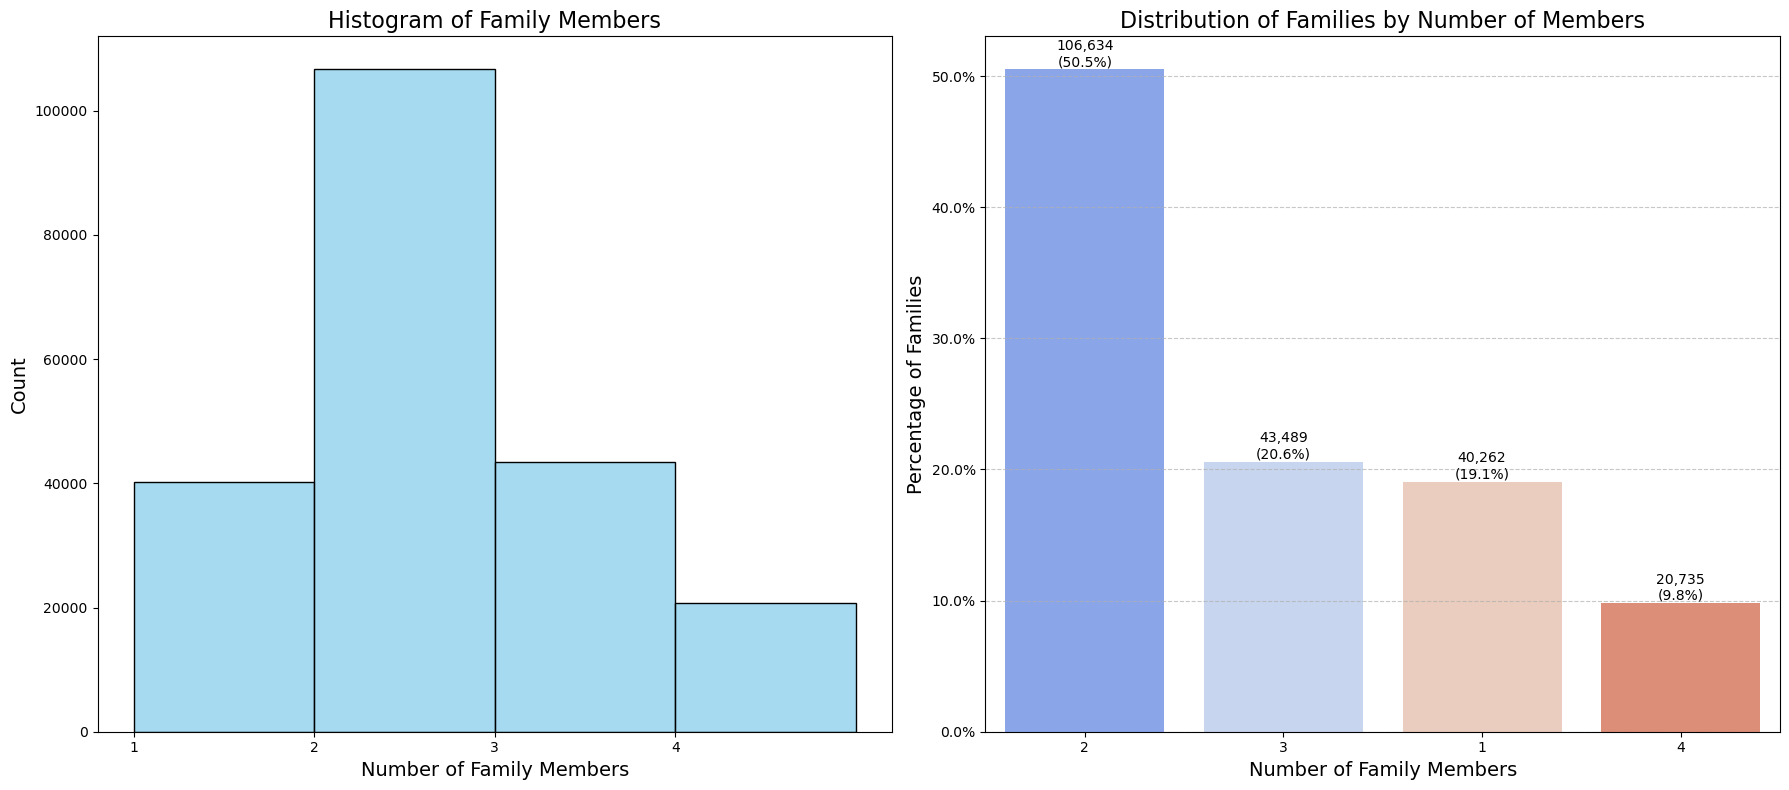

In [ ]:
eda_univariate_family_members(train)

Berdasarkan hasil grafik di atas, terdapat beberapa insight penting antara lain:
- Rata - rata jumlah anggota keluarga peminjam terbanyak adalah 2 orang per keluarga sebesar 50.5% dari total keseluruhan jumlah nasabah.
- Semakin banyak jumlah anggota keluarga, maka semakin kecil jumlah nasabah yang melakukan pinjaman. Hal ini dikarenakan banyaknya jumlah anggota keluarga dapat memberatkan mereka karena adanya tanggungan yang harus mereka lakukan.

## CNT_CHILDREN

In [ ]:
def eda_univariate_children(data_t):
  data_t['CNT_CHILDREN_DISPLAY'] = np.where(data_t['CNT_CHILDREN'] > 3, '4+',
                                      np.where(data_t['CNT_CHILDREN'] == 0, 'No Children',
                                              data_t['CNT_CHILDREN'].astype(str)))

  fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=120)  # Meningkatkan resolusi dengan dpi

  # 1. Bar Plot: Frekuensi jumlah anak dengan pengelompokan dan pengurutan
  bar_counts = data_t['CNT_CHILDREN_DISPLAY'].value_counts().reindex(['No Children', '1', '2', '3', '4+'], fill_value=0)
  bar_counts = bar_counts.sort_values(ascending=False)  # Urutkan dari yang terbesar
  bar_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[0])
  axes[0].set_title('Families by Number of Children', fontsize=16)
  axes[0].set_xlabel('Number of Children', fontsize=14)
  axes[0].set_ylabel('Count', fontsize=14)
  axes[0].grid(True, axis='y', linestyle='--', alpha=0.7)
  axes[0].tick_params(axis='x', rotation=0, labelsize=12)

  # Tambahkan anotasi di atas setiap bar
  for i in range(len(bar_counts)):
      axes[0].text(i, bar_counts.iloc[i] + 500, bar_counts.iloc[i], ha='center', fontsize=12)

  # 2. Histogram dan KDE: Visualisasi distribusi jumlah anak
  sns.histplot(data=data_t, x='CNT_CHILDREN', bins=20, color='lightgreen', ax=axes[1], stat="density", alpha=0.6, edgecolor='black')
  axes[1].set_title('Distribution of Number of Children', fontsize=16)
  axes[1].set_xlabel('Number of Children', fontsize=14)
  axes[1].set_ylabel('Density', fontsize=14)
  axes[1].grid(True, axis='y', linestyle='--', alpha=0.7)

  # Set sumbu x menjadi diskrit sesuai dengan data
  axes[1].set_xticks(np.arange(0, 21, 1))  # Set sumbu x dari 0 hingga 20
  axes[1].set_xlim(-1, 4)  # Set batas sumbu x

  # Adjust layout for better spacing
  plt.tight_layout()

  # Show the plots
  plt.show()

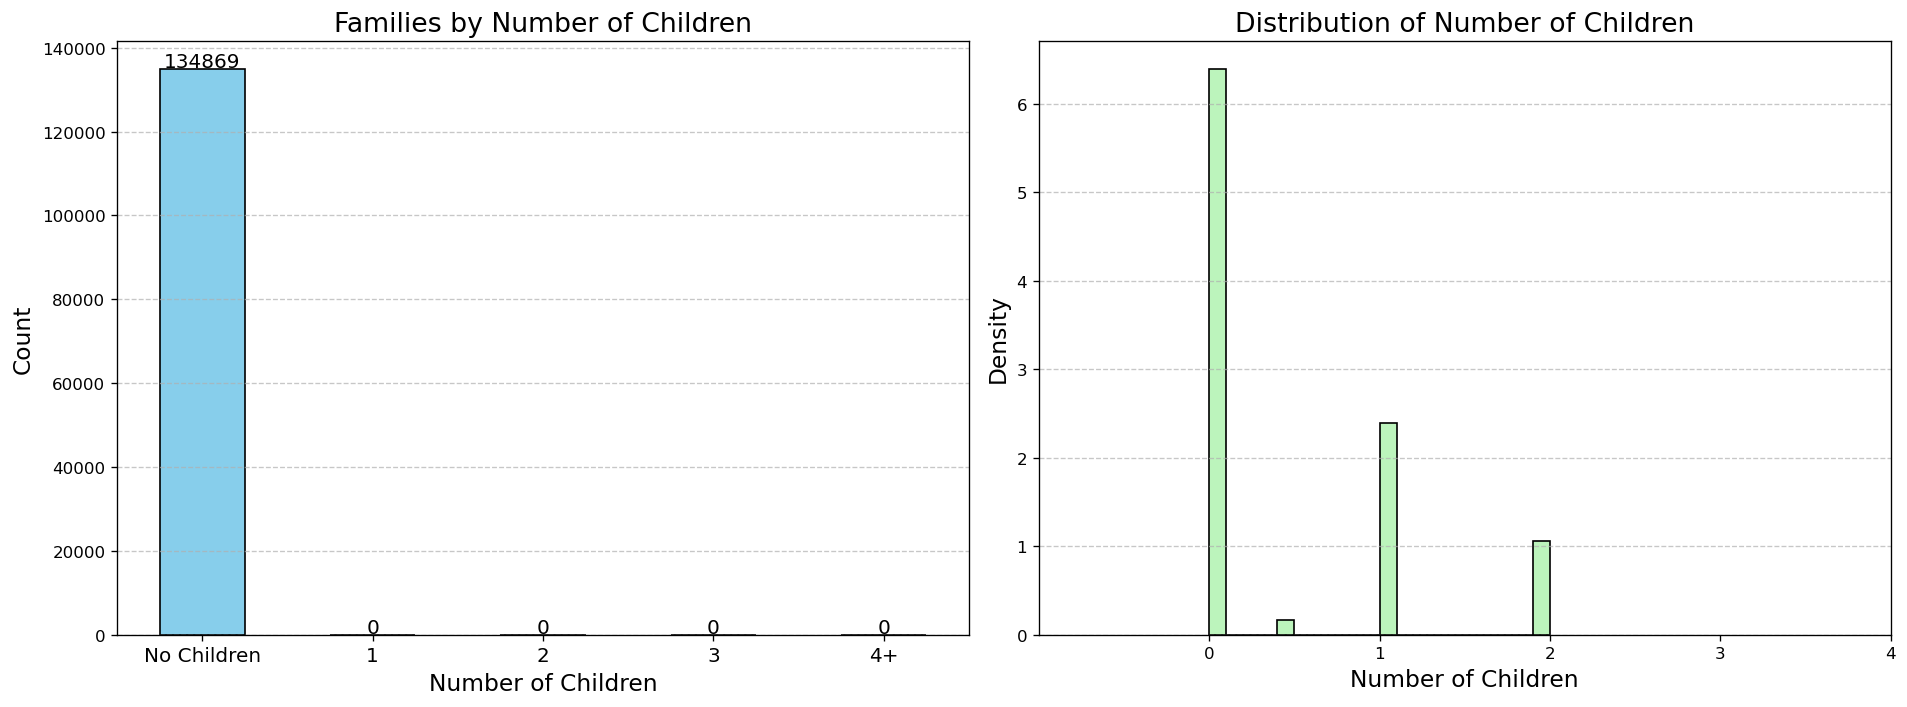

In [ ]:
eda_univariate_children(train)

Dilanjut pada grafik jumlah anak, dapat dilihat distribusi paling banyak adalah nasabah yang tidak memiliki anak sehingga dapat disimpulkan semakin kecil jumlah anggota keluarga dan anak, maka semakin tinggi kemungkinan nasabah untuk melakukan pinjaman ke HomeCredit.

## NAME_INCOME_TYPE

In [ ]:
income_type_counts = train['NAME_INCOME_TYPE'].value_counts()

income_type_grouped = {
    'Working': income_type_counts['Working'],
    'Commercial associate': income_type_counts['Commercial associate'],
    'State servant': income_type_counts['State servant'],
    'Student': income_type_counts['Student'],
    'Businessman': income_type_counts['Businessman'],
    'Pensioner': income_type_counts['Pensioner'],
    'Maternity leave': income_type_counts['Maternity leave']
}
income_type_grouped

income_type_grouped_list = list(income_type_grouped.keys())

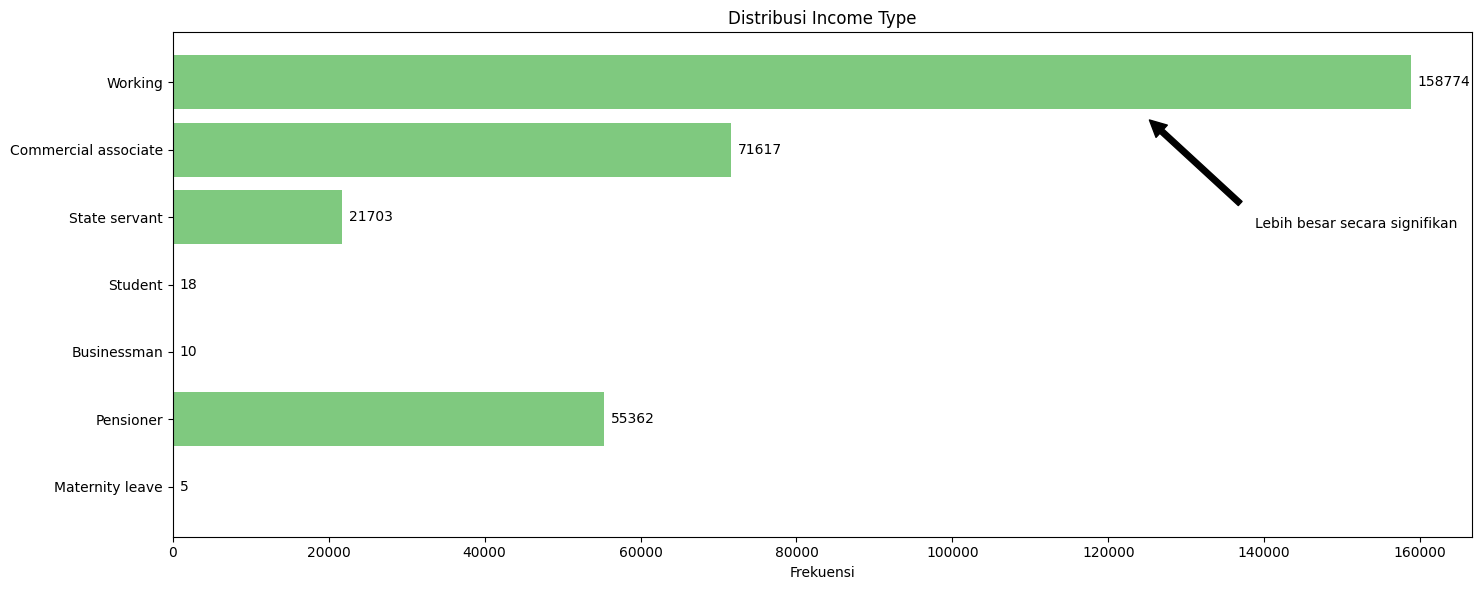

In [ ]:
income_type_labels = income_type_grouped_list
income_type_sizes = income_type_grouped.values()

fig, ax = plt.subplots(figsize = (15, 6))

it1 = ax.barh(income_type_labels,
              income_type_sizes,
              align = 'center')

ax.set_yticks(range(len(income_type_labels)))
ax.set_yticklabels(income_type_labels)
ax.invert_yaxis()
ax.set_xlabel('Frekuensi')
ax.set_title('Distribusi Income Type')

for cont in ax.containers:
    ax.bar_label(cont, padding = 5)

highlight_index = 0
highlight_bar = it1[highlight_index]
ax.annotate('Lebih besar secara signifikan',
            xy=(highlight_bar.get_width() - 35000, highlight_bar.get_y() + 0.8),
            xytext=(highlight_bar.get_width() - 20000, highlight_bar.get_y() + 2.5),
            arrowprops=dict(facecolor='black', shrink=0.1),
            va='center')

plt.tight_layout()
plt.show()

### Interpretasi
1. Berdasarkan grafik di atas, distribusi dari data "Income Type" nasabah homecredit paling banyak di kategori "Working", yang bisa diartikan bahwa mayoritas dari nasabah mendapatkan penghasilannya dari kegiatan bekerja.
2. Kategori "Working" memiliki selisih data yang sangat jauh dibanding kategori lainnya
3. Kategori "Unemployed", "Student", "Businessman", dan "Maternity leave" memiliki frekuensi yang sangat kecil sehingga dikelompokkan ke dalam kategori baru yaitu "Other Income Types"ve

In [ ]:
train['Capability'] = train['TARGET'].apply(lambda x: 'Not Capable' if x == 1 else 'Capable')

income_type_capability = train.groupby(['NAME_INCOME_TYPE', 'Capability'])['SK_ID_CURR'].count().reset_index()
income_type_capability.columns = ['Income Type', 'Capability', 'Count']

income_type_capability_sorted = income_type_capability.sort_values(by='Count', ascending=False)

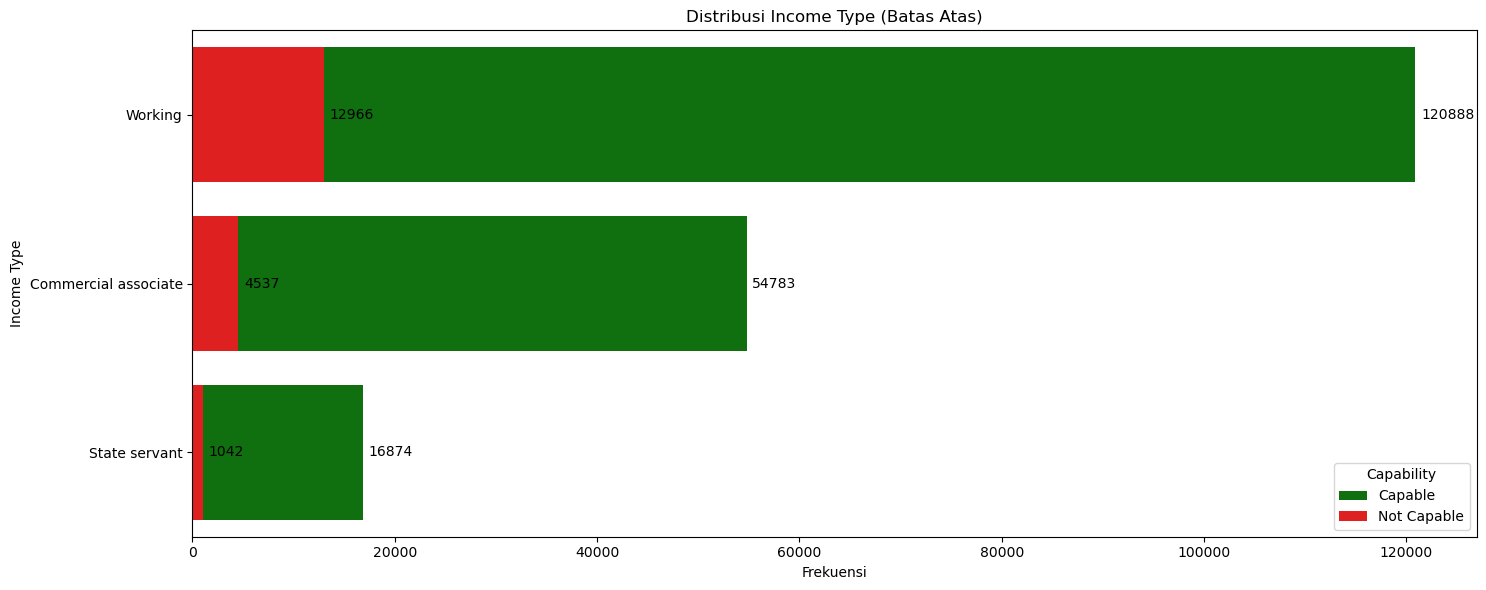

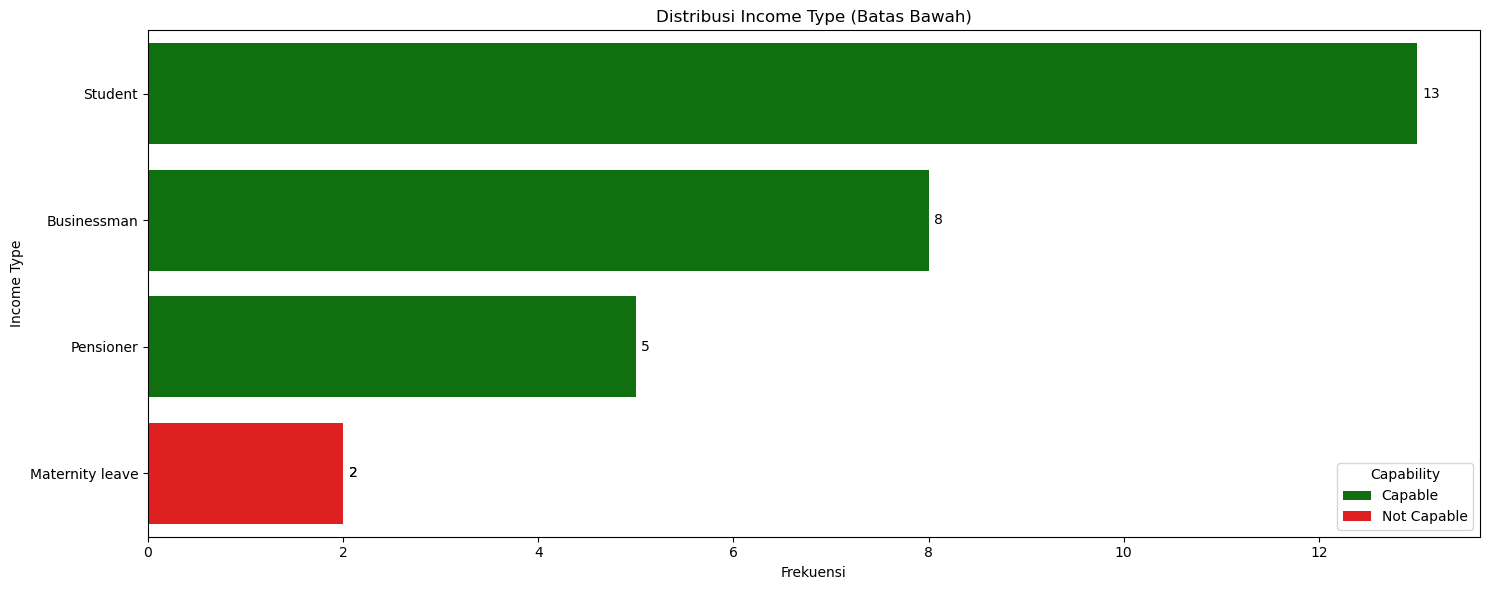

In [ ]:
it2 = income_type_capability_sorted

aggregated_it2 = it2.groupby('Income Type').sum().reset_index()

aggregated_it2['Percentage Not Capable'] = aggregated_it2.apply(
    lambda row: it2[(it2['Income Type'] == row['Income Type']) & (it2['Capability'] == 'Not Capable')]['Count'].sum() / row['Count'] * 100,
    axis = 1)

threshold = 20

high_income_types = aggregated_it2[aggregated_it2['Count'] > threshold]['Income Type']
low_income_types = aggregated_it2[aggregated_it2['Count'] <= threshold]['Income Type']

it2_high = it2[it2['Income Type'].isin(high_income_types)]
it2_low = it2[it2['Income Type'].isin(low_income_types)]

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(
    data=it2_high,
    y='Income Type',
    x='Count',
    hue='Capability',
    dodge=False,
    ax=ax,
    palette={'Capable': 'green', 'Not Capable': 'red'}
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=4)

ax.legend(title='Capability')
ax.set_xlabel('Frekuensi')
ax.set_title('Distribusi Income Type (Batas Atas)')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(
    data=it2_low,
    y='Income Type',
    x='Count',
    hue='Capability',
    dodge=False,
    ax=ax,
    palette={'Capable': 'green', 'Not Capable': 'red'}
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=4)

ax.legend(title='Capability')
ax.set_xlabel('Frekuensi')
ax.set_title('Distribusi Income Type (Batas Bawah)')
plt.tight_layout()
plt.show()

### Interpretasi
1. Berdasarkan grafik di atas, secara umum  tidak ada perbedaan antara distribusi data "Income Type" baik nasabah yang termasuk ke dalam kriteria "Capable" ataupun "Not Capable
2. Kategori "Student" dan "Businessman" tidak memiliki nasabah yang tergolong "Not Capable" yang berarti mereka tidak memiliki permasalahan dalam pembayaran kredit
3. Kategori "Maternity leave" dan "Unemployed" memiliki persentase nasabah yang "Not Capable" paling tinggi, yaitu sebesar 40% dan 36% secara berurutan
2. Data "Income Type" kemungkinan tidak berkorelasi terhadap penentuan seorang nasabah "Capable" atau "Not Capable"

## OCCUPATION_TYPE

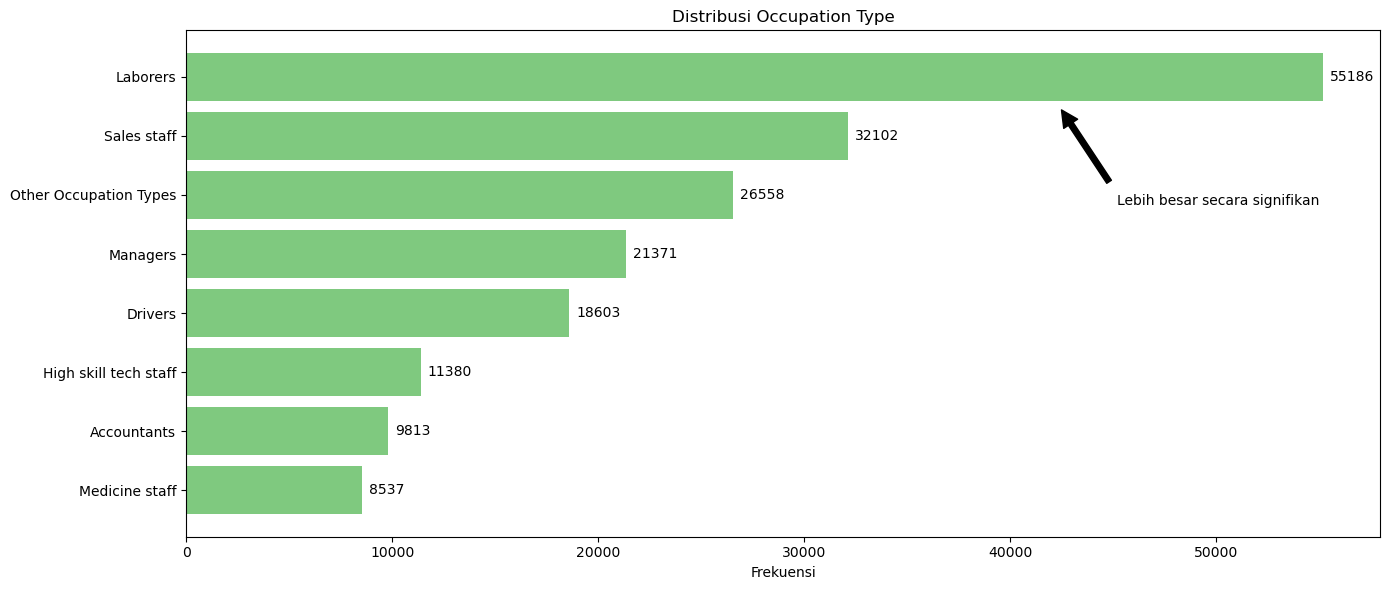

In [ ]:
occupation_type_counts = train['OCCUPATION_TYPE'].value_counts()

occupation_type_grouped = {
    'Laborers': occupation_type_counts['Laborers'],
    'Sales staff': occupation_type_counts['Sales staff'],
    'Managers': occupation_type_counts['Managers'],
    'Drivers': occupation_type_counts['Drivers'],
    'High skill tech staff': occupation_type_counts['High skill tech staff'],
    'Accountants': occupation_type_counts['Accountants'],
    'Medicine staff': occupation_type_counts['Medicine staff'],
    'Other Occupation Types': occupation_type_counts['Security staff'] + occupation_type_counts['Cooking staff'] + occupation_type_counts['Cleaning staff'] + occupation_type_counts['Private service staff'] + occupation_type_counts['Low-skill Laborers'] + occupation_type_counts['Waiters/barmen staff'] + occupation_type_counts['Secretaries'] + occupation_type_counts['Realty agents'] + occupation_type_counts['HR staff'] + occupation_type_counts['IT staff']
}
occupation_type_grouped

sorted_occupation_type_grouped_data = dict(sorted(occupation_type_grouped.items(), key=lambda item: item[1], reverse=True))

occupation_type_grouped_list = list(sorted_occupation_type_grouped_data.keys())

occupation_type_labels = occupation_type_grouped_list
occupation_type_sizes = sorted_occupation_type_grouped_data.values()

fig, ax = plt.subplots(figsize=(14, 6))

ot1 = ax.barh(occupation_type_labels,
        occupation_type_sizes,
        align = 'center')

ax.set_yticks(range(len(occupation_type_labels)))
ax.set_yticklabels(occupation_type_labels)
ax.invert_yaxis()
ax.set_xlabel('Frekuensi')
ax.set_title('Distribusi Occupation Type')

for cont in ax.containers:
    ax.bar_label(cont, padding = 5)

highlight_index = 0
highlight_bar = ot1[highlight_index]
ax.annotate('Lebih besar secara signifikan', 
            xy=(highlight_bar.get_width() - 13000, highlight_bar.get_y() + 0.8),
            xytext=(highlight_bar.get_width() - 10000, highlight_bar.get_y() + 2.5),
            arrowprops=dict(facecolor='black', shrink=0.1),
            va='center')

plt.tight_layout()
plt.show()

### Interpretasi
1. Berdasarkan grafik di atsa, kategori "Laborers" atau buruh merupakan kategori yang memiliki frekuensi terbanya jauh lebih besar dibandingkan kategori lainnyak pada data "Occupation Type
2. Kategori "Other Occupation Types" terlihat masih banyak, tetapi akan bisa dilihat berdasarkan klasifikasi "Capability"-nya pada bagian selanjutnya

In [ ]:
# Klasifikasi berdasarkan Capability
occupation_type_capability = train.groupby(['OCCUPATION_TYPE', 'Capability'])['SK_ID_CURR'].count().reset_index()
occupation_type_capability.columns = ['OCCUPATION_TYPE', 'Capability', 'Count']

occupation_type_capability_sorted = occupation_type_capability.sort_values(by='Count', ascending=False)

occupation_type_capability_sorted.columns = ['Occupation Type', 'Capability', 'Count']

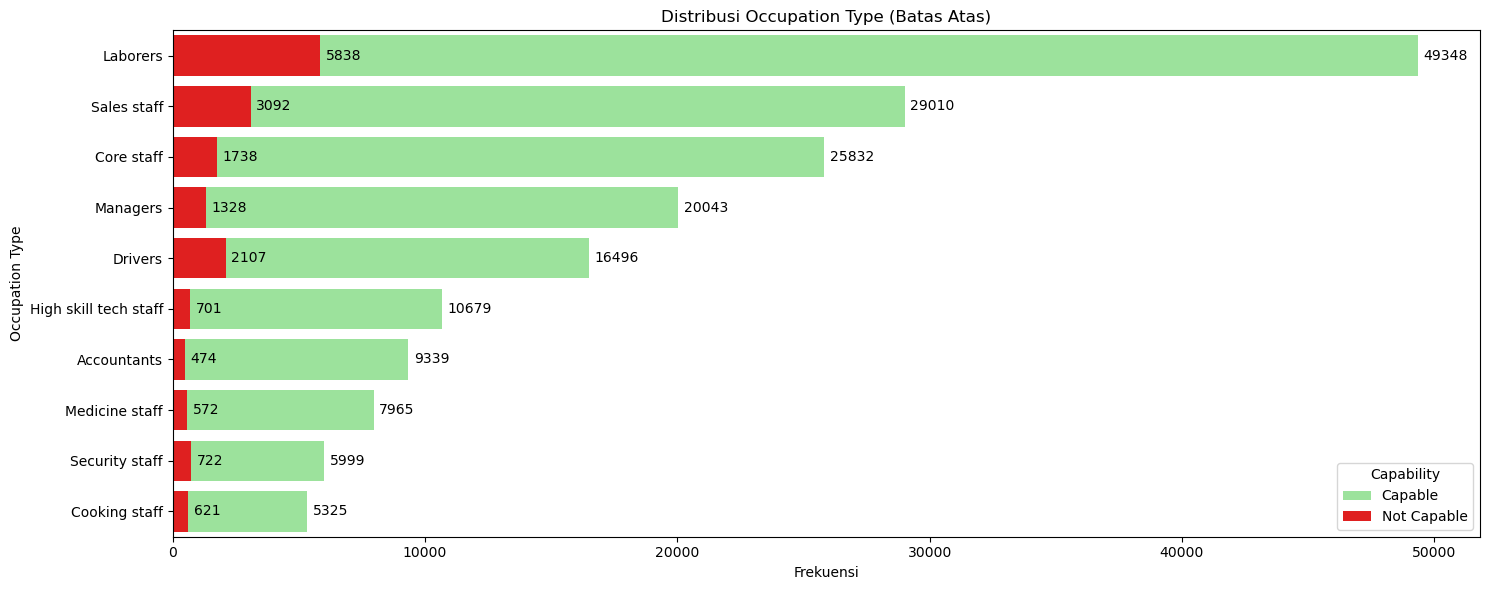

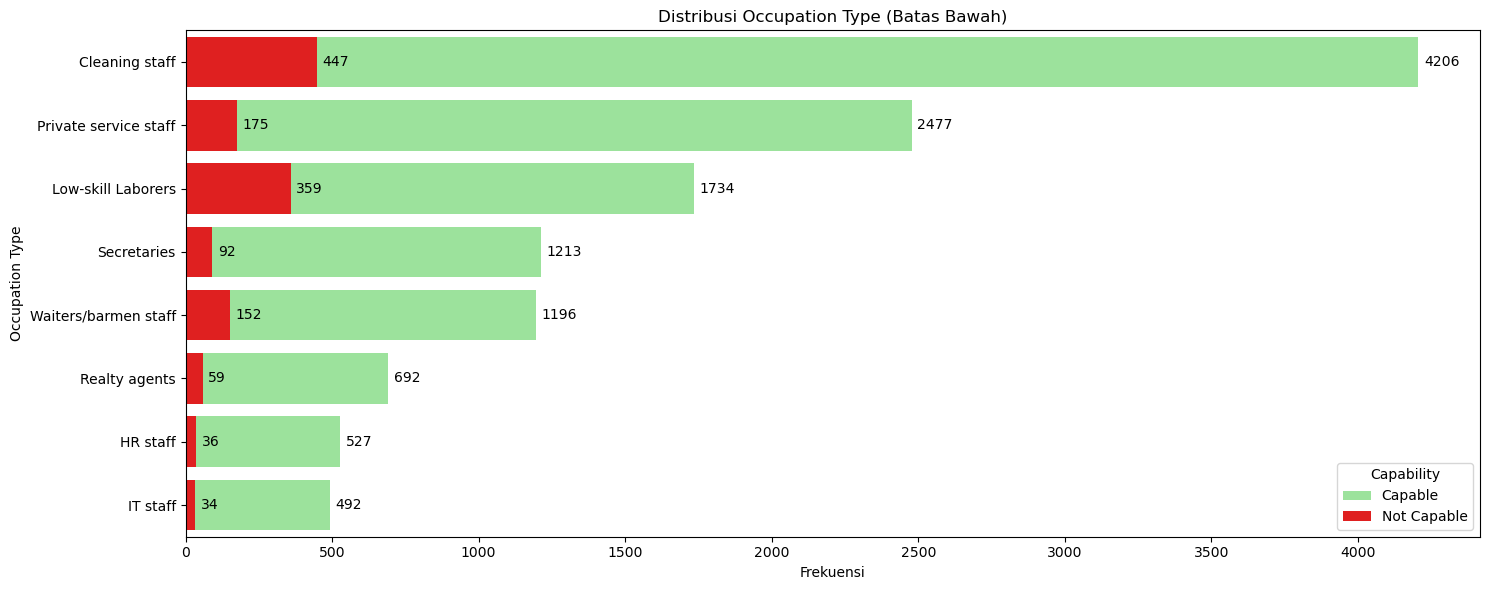

In [ ]:
ot2 = occupation_type_capability_sorted

aggregated_ot2 = ot2.groupby('Occupation Type').sum().reset_index()

threshold = 5000

high_occupation_types = aggregated_ot2[aggregated_ot2['Count'] > threshold]['Occupation Type']
low_occupation_types = aggregated_ot2[aggregated_ot2['Count'] <= threshold]['Occupation Type']

ot2_high = ot2[ot2['Occupation Type'].isin(high_occupation_types)]
ot2_low = ot2[ot2['Occupation Type'].isin(low_occupation_types)]

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(
    data=ot2_high,
    y='Occupation Type',
    x='Count',
    hue='Capability',
    dodge=False,
    ax=ax,
    palette={'Capable': 'lightgreen', 'Not Capable': 'red'}
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=4)

ax.legend(title='Capability')
ax.set_xlabel('Frekuensi')
ax.set_title('Distribusi Occupation Type (Batas Atas)')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(
    data=ot2_low,
    y='Occupation Type',
    x='Count',
    hue='Capability',
    dodge=False,
    ax=ax,
    palette={'Capable': 'lightgreen', 'Not Capable': 'red'}
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=4)
  
ax.legend(title='Capability')
ax.set_xlabel('Frekuensi')
ax.set_title('Distribusi Occupation Type (Batas Bawah)')

plt.tight_layout()
plt.show()

In [ ]:
aggregated_ot2['Percentage Not Capable'] = aggregated_ot2.apply(
    lambda row: ot2[(ot2['Occupation Type'] == row['Occupation Type']) & (ot2['Capability'] == 'Not Capable')]['Count'].sum() / row['Count'] * 100,
    axis=1
)

aggregated_ot2_data = ['Occupation Type', 'Percentage Not Capable']
sorted_aggregated_ot2 = aggregated_ot2[aggregated_ot2_data].sort_values(by='Percentage Not Capable', ascending=False).reset_index()

print(sorted_aggregated_ot2)

    index        Occupation Type  Percentage Not Capable
0       9     Low-skill Laborers               17.152413
1       4                Drivers               11.326130
2      17   Waiters/barmen staff               11.275964
3      16         Security staff               10.742449
4       8               Laborers               10.578770
5       2          Cooking staff               10.443996
6      14            Sales staff                9.631799
7       1         Cleaning staff                9.606705
8      13          Realty agents                7.856192
9      15            Secretaries                7.049808
10     11         Medicine staff                6.700246
11     12  Private service staff                6.598793
12      7               IT staff                6.463878
13      5               HR staff                6.394316
14      3             Core staff                6.303954
15     10               Managers                6.214028
16      6  High skill tech staf

### Interpretasi
1. Berdasarkan grafik di atas, secara umum,  tidak ada perbedaan antara distribusi data "Occupation Type" baik nasabah yang termasuk ke dalam kriteria "Capable" ataupun "Not Capable"
2. Kategori "Low-skill Laborers" merupakan kategori yang memiliki persentase "Not Capable" paling tinggi di antara semua kategori, yaitu sebesar 17%
3. Kategori "Accountants" merupakan kategori yang memiliki persentase "Not Capable" paling rendah di antara semua kategori, yaitu sebesar 4,8%
4. Data "Occupation Type" kemungkinan tidak berkorelasi terhadap penentuan seorang nasabah "Capable" atau "Not Capable"dari tipe - tipe pekerjaan nasabah, sebanyak 30.1% adalah Laborers atau buruh, disusul dengan Sales Staff sebanyak 17.5% dari keseluruhan, kemudian Managers 11.6%, dan pekerjaan dengan percentage terkecil yaitu Medicine Staff sebesar 4.7%. Namun Medicine Staff bukanlah pekerjaan terendah, karena dibawah Medicine staff itu jumlahnya sangat kecil sehingga kami gabungkan menjadi "Other Occupation Types".

## AMT_INCOME_TOTAL 

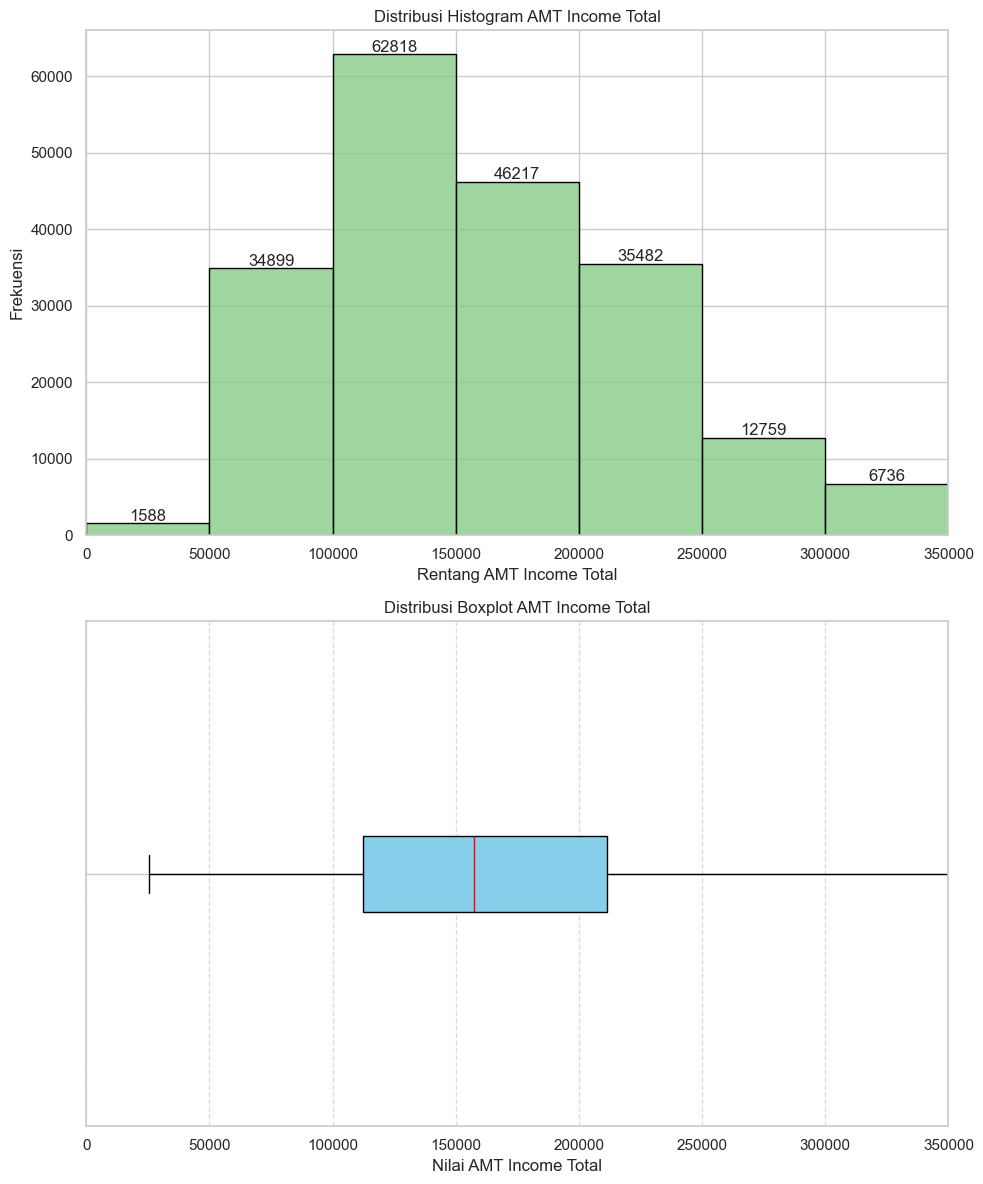

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ait_data = train[['AMT_INCOME_TOTAL', 'Capability']]
capable_data = ait_data[ait_data['Capability'] == 'Capable']['AMT_INCOME_TOTAL']
not_capable_data = ait_data[ait_data['Capability'] == 'Not Capable']['AMT_INCOME_TOTAL']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

hist = sns.histplot(data=ait_data,
                    x='AMT_INCOME_TOTAL',
                    bins=[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000],
                    edgecolor='black',
                    ax=ax1)

ax1.set_xlim(0, 350000)

for p in hist.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.0f}',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='center', xytext=(0, 5),
                 textcoords='offset points')

ax1.set_xlabel('Rentang AMT Income Total')
ax1.set_ylabel('Frekuensi')
ax1.set_title('Distribusi Histogram AMT Income Total')

# Boxplot
ax2.boxplot(ait_data['AMT_INCOME_TOTAL'],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))

ax2.set_xlim(0, 350000)
ax2.set_yticklabels([])
ax2.set_xlabel('Nilai AMT Income Total')
ax2.set_title('Distribusi Boxplot AMT Income Total')
ax2.grid(True, axis='x', linestyle='--', alpha=0.7)

ax2.set_xlabel('Nilai AMT Income Total')
ax2.set_title('Distribusi Boxplot AMT Income Total')

plt.tight_layout()
plt.show()


In [ ]:
train[['AMT_INCOME_TOTAL']].nunique()

AMT_INCOME_TOTAL    2016
dtype: int64

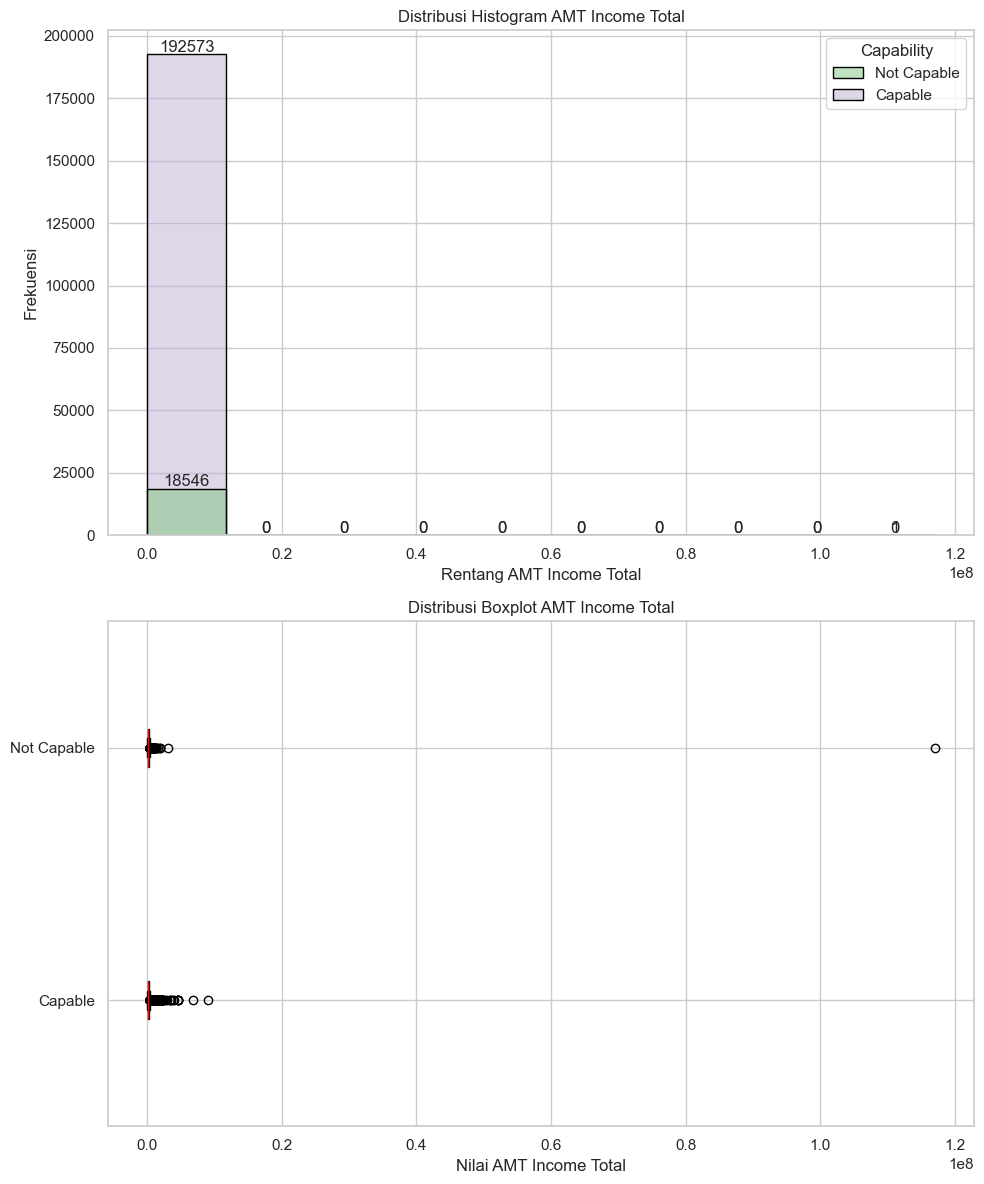

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ait_data = train[['AMT_INCOME_TOTAL', 'Capability']]
capable_data = ait_data[ait_data['Capability'] == 'Capable']['AMT_INCOME_TOTAL']
not_capable_data = ait_data[ait_data['Capability'] == 'Not Capable']['AMT_INCOME_TOTAL']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

hist = sns.histplot(data=ait_data,
                    x='AMT_INCOME_TOTAL',
                    bins=10,
                    hue='Capability',
                    edgecolor='black',
                    ax=ax1)

for p in hist.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.0f}',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='center', xytext=(0, 5),
                 textcoords='offset points')

ax1.set_xlabel('Rentang AMT Income Total')
ax1.set_ylabel('Frekuensi')
ax1.set_title('Distribusi Histogram AMT Income Total')

ax2.boxplot([capable_data, not_capable_data],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'),
            labels=['Capable', 'Not Capable'])

ax2.set_xlabel('Nilai AMT Income Total')
ax2.set_title('Distribusi Boxplot AMT Income Total')

plt.tight_layout()
plt.show()


In [ ]:
bins = pd.cut(ait_data['AMT_INCOME_TOTAL'], bins=10)

total_counts = ait_data.groupby(bins)['Capability'].count()
not_capable_counts = ait_data[ait_data['Capability'] == 'Not Capable'].groupby(bins)['Capability'].count()

percentage_not_capable = (not_capable_counts / total_counts) * 100

percentage_df = pd.DataFrame({
    'Income Range': total_counts.index.astype(str),
    'Total Count': total_counts.values,
    'Not Capable Count': not_capable_counts.values,
    'Percentage Not Capable': percentage_not_capable.values
}).fillna(0) 

sorted_percentage_df = percentage_df.sort_values(by='Percentage Not Capable', ascending=False).reset_index(drop=True)

print(sorted_percentage_df)

                 Income Range  Total Count  Not Capable Count  \
0  (105302565.0, 117000000.0]            1                  1   
1     (-91324.35, 11723085.0]       211119              18546   
2    (11723085.0, 23420520.0]            0                  0   
3    (23420520.0, 35117955.0]            0                  0   
4    (35117955.0, 46815390.0]            0                  0   
5    (46815390.0, 58512825.0]            0                  0   
6    (58512825.0, 70210260.0]            0                  0   
7    (70210260.0, 81907695.0]            0                  0   
8    (81907695.0, 93605130.0]            0                  0   
9   (93605130.0, 105302565.0]            0                  0   

   Percentage Not Capable  
0              100.000000  
1                8.784619  
2                0.000000  
3                0.000000  
4                0.000000  
5                0.000000  
6                0.000000  
7                0.000000  
8                0.000000  
9   

### Interpretasi
1. Berdasarkan histogram data capability "AMT Income Total" di atas, terlihat bahwa tidak ada penumpukan data "Not Capable" pada berbagai rentang di histogram dan boxplot
3. Berdasarkan data persentase "Not Capable", nilai paling tinggi berada di rentang 88020-119205 dengan persentase 8,5%, meskipun tidak ada perbedaan signifikan di antara semua rentang
2. Data "AMT Income Total" kemungkinan tidak berkorelasi dalam penentuan kapabilitas nasabah

## ORGANIZATION_TYPE

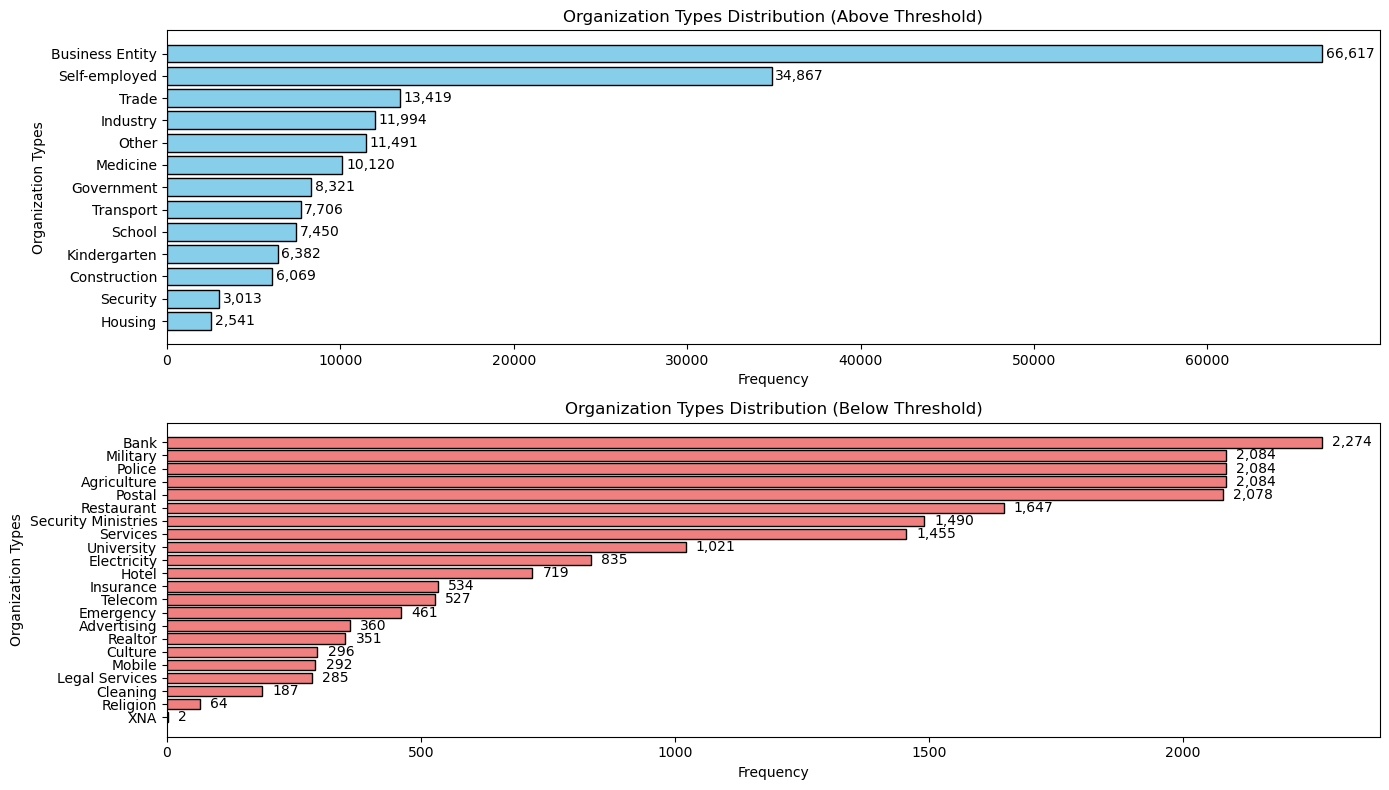

In [ ]:
organization_type_counts = train['ORGANIZATION_TYPE'].value_counts()

organization_type_categories = {
    'Business Entity': ['Business Entity Type 1', 'Business Entity Type 2', 'Business Entity Type 3'],
    'Trade': ['Trade: type 1', 'Trade: type 2', 'Trade: type 3', 'Trade: type 4', 'Trade: type 5', 'Trade: type 6', 'Trade: type 7'],
    'Industry': ['Industry: type 1', 'Industry: type 2', 'Industry: type 3', 'Industry: type 4', 'Industry: type 5', 'Industry: type 6', 'Industry: type 7', 'Industry: type 8', 'Industry: type 9', 'Industry: type 10', 'Industry: type 11', 'Industry: type 12', 'Industry: type 13'],
    'Transport': ['Transport: type 1', 'Transport: type 2', 'Transport: type 3', 'Transport: type 4']
}

organization_type_categories_data = {}
for category, keys in organization_type_categories.items():
    organization_type_categories_data[category] = sum(organization_type_counts[key] for key in keys if key in organization_type_counts)

# Add remaining data to categorized_data
for key, value in organization_type_counts.items():
    if not any(key in keys for keys in organization_type_categories.values()):
        organization_type_categories_data[key] = value

threshold = 2500

above_threshold = {k: v for k, v in organization_type_categories_data.items() if v > threshold}
below_threshold = {k: v for k, v in organization_type_categories_data.items() if v <= threshold}

sorted_above_threshold = {key:value for key, value in sorted(above_threshold.items(), key=lambda my_dict: my_dict[1], reverse=True)}
sorted_below_threshold = {key:value for key, value in sorted(below_threshold.items(), key=lambda my_dict: my_dict[1], reverse=True)}

above_keys = list(sorted_above_threshold.keys())
above_values = list(sorted_above_threshold.values())
below_keys = list(sorted_below_threshold.keys())
below_values = list(sorted_below_threshold.values())

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
otb1 = plt.barh(above_keys, above_values, color='skyblue', edgecolor='black')

plt.xlabel('Frequency')
plt.ylabel('Organization Types')
plt.title('Organization Types Distribution (Above Threshold)')
plt.gca().invert_yaxis()

for bar in otb1:
    plt.text(bar.get_width() + 200, bar.get_y() + bar.get_height()/2, f'{bar.get_width():,.0f}', va='center')

plt.subplot(2, 1, 2)
otb2 = plt.barh(below_keys, below_values, color='lightcoral', edgecolor='black')

plt.xlabel('Frequency')
plt.ylabel('Organization Types')
plt.title('Organization Types Distribution (Below Threshold)')
plt.gca().invert_yaxis()

for bar in otb2:
    plt.text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2, f'{bar.get_width():,.0f}', va='center')

plt.tight_layout()
plt.show()

# Interpretasi
- Berdasarkan grafik di atas, kategori "Business Entity" merupakan kategori yang paling dominan dengan nilai 66617, jauh lebih banyak dibandingkan kategori lain.
- Grafik dibagi menjadi dua agar mempermudah melihat data yang memiliki nilai lebih kecil (threshold < 2500)

In [ ]:
# Klasifikasi berdasarkan Capability
organization_type_capability = train.groupby(['ORGANIZATION_TYPE', 'Capability'])['SK_ID_CURR'].count().reset_index()


organization_type_capability_sorted = organization_type_capability.sort_values(by='SK_ID_CURR', ascending=False)
organization_type_capability_sorted.columns = ['Organization Type', 'Capability', 'Count']

organization_type_capability_counts = organization_type_capability_sorted.value_counts()
organization_type_capability_counts

Organization Type    Capability   Count
Advertising          Capable      335      1
Services             Capable      1357     1
Self-employed        Capable      31317    1
Security Ministries  Not Capable  68       1
                     Capable      1422     1
                                          ..
Industry: type 12    Capable      302      1
Industry: type 11    Not Capable  181      1
                     Capable      2000     1
Industry: type 10    Not Capable  7        1
XNA                  Capable      2        1
Name: count, Length: 115, dtype: int64

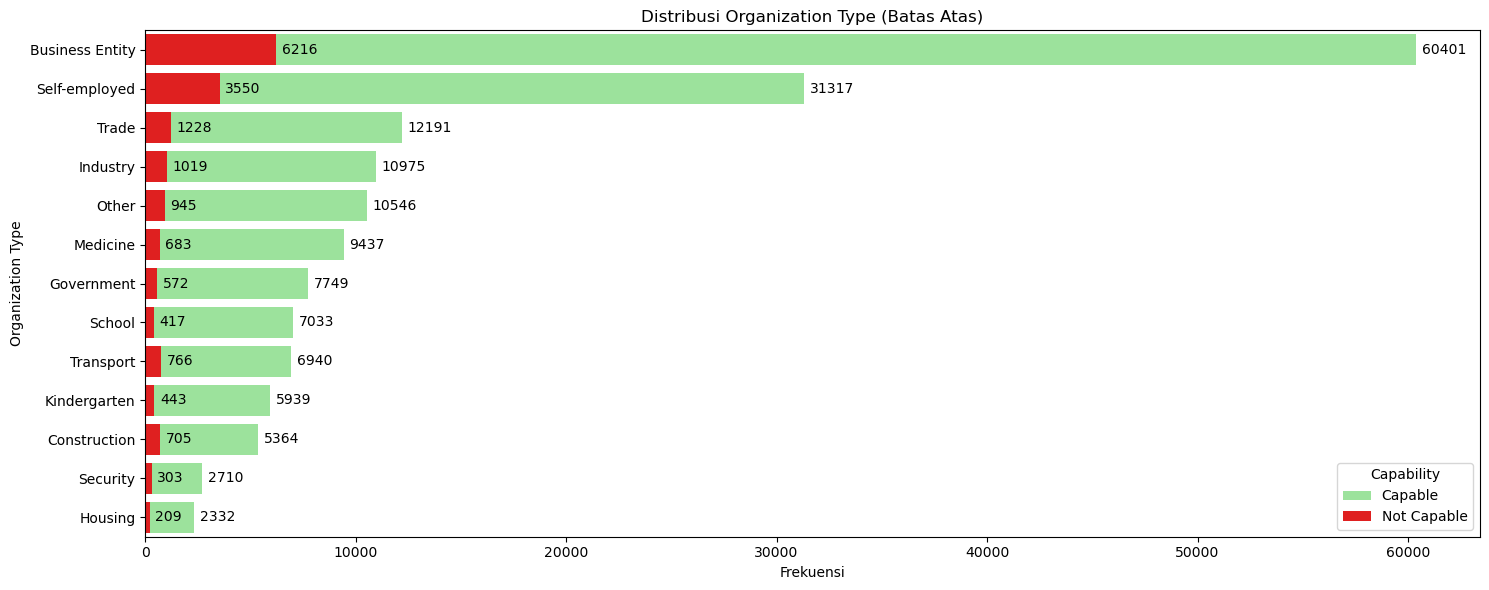

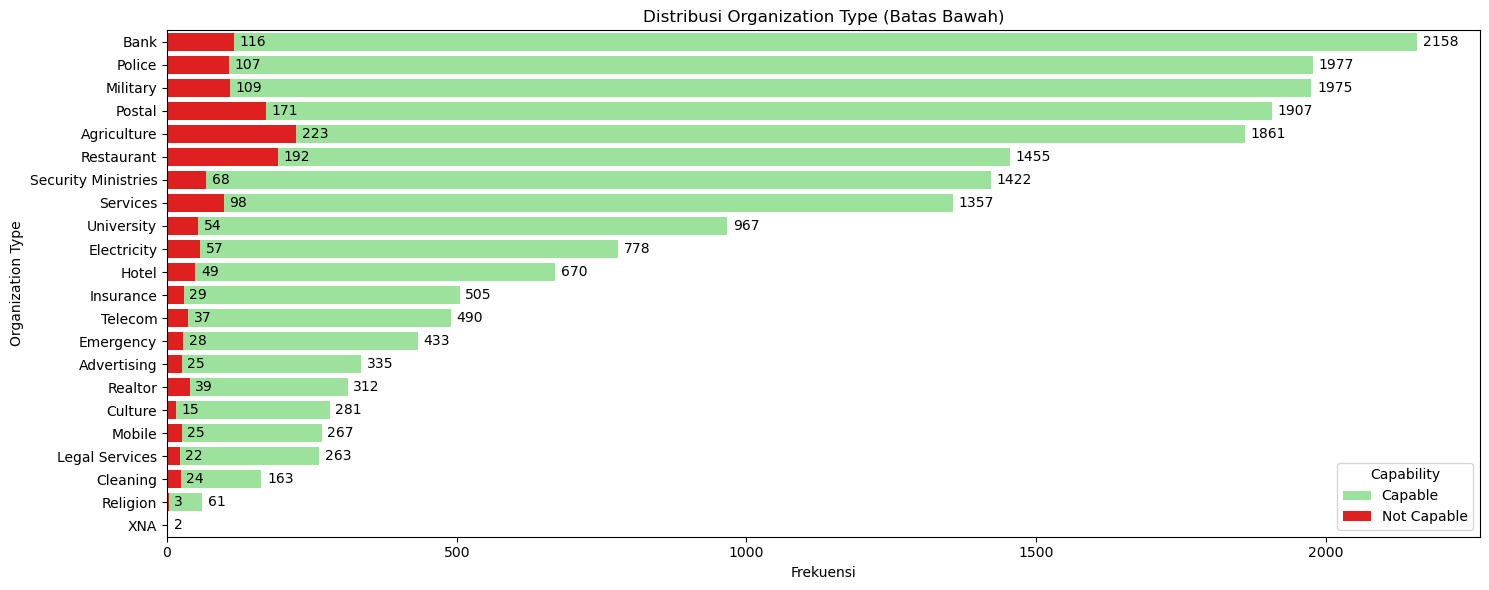

In [ ]:
organization_type_capability = train.groupby(['ORGANIZATION_TYPE', 'Capability'])['SK_ID_CURR'].count().reset_index()

organization_type_capability_sorted = organization_type_capability.sort_values(by='SK_ID_CURR', ascending=False)
organization_type_capability_sorted.columns = ['Organization Type', 'Capability', 'Count']

organization_type_categories = {
    'Business Entity': ['Business Entity Type 1', 'Business Entity Type 2', 'Business Entity Type 3'],
    'Trade': ['Trade: type 1', 'Trade: type 2', 'Trade: type 3', 'Trade: type 4', 'Trade: type 5', 'Trade: type 6', 'Trade: type 7'],
    'Industry': ['Industry: type 1', 'Industry: type 2', 'Industry: type 3', 'Industry: type 4', 'Industry: type 5', 'Industry: type 6', 'Industry: type 7', 'Industry: type 8', 'Industry: type 9', 'Industry: type 10', 'Industry: type 11', 'Industry: type 12', 'Industry: type 13'],
    'Transport': ['Transport: type 1', 'Transport: type 2', 'Transport: type 3', 'Transport: type 4']
}

for category, keys in organization_type_categories.items():
    for key in keys:
        organization_type_capability_sorted.loc[organization_type_capability_sorted['Organization Type'] == key, 'Organization Type'] = category

aggregated_orgt2 = organization_type_capability_sorted.groupby(['Organization Type', 'Capability']).sum().reset_index()

threshold = 2500

high_organization_types = aggregated_orgt2.groupby('Organization Type')['Count'].sum().reset_index()
high_organization_types = high_organization_types[high_organization_types['Count'] > threshold]['Organization Type']
low_organization_types = aggregated_orgt2.groupby('Organization Type')['Count'].sum().reset_index()
low_organization_types = low_organization_types[low_organization_types['Count'] <= threshold]['Organization Type']

orgt2_high = aggregated_orgt2[aggregated_orgt2['Organization Type'].isin(high_organization_types)]
orgt2_low = aggregated_orgt2[aggregated_orgt2['Organization Type'].isin(low_organization_types)]

orgt2_high = orgt2_high.sort_values(by='Count', ascending=False)
orgt2_low = orgt2_low.sort_values(by='Count', ascending=False)

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(
    data=orgt2_high,
    y='Organization Type',
    x='Count',
    hue='Capability',
    dodge=False,
    ax=ax,
    palette={'Capable': 'lightgreen', 'Not Capable': 'red'}
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=4)

ax.legend(title='Capability')
ax.set_xlabel('Frekuensi')
ax.set_title('Distribusi Organization Type (Batas Atas)')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(
    data=orgt2_low,
    y='Organization Type',
    x='Count',
    hue='Capability',
    dodge=False,
    ax=ax,
    palette={'Capable': 'lightgreen', 'Not Capable': 'red'}
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=4)

ax.legend(title='Capability')
ax.set_xlabel('Frekuensi')
ax.set_title('Distribusi Organization Type (Batas Bawah)')
plt.tight_layout()
plt.show()


In [ ]:
total_counts = organization_type_capability_sorted.groupby('Organization Type')['Count'].sum().reset_index()

not_capable_counts = organization_type_capability_sorted[organization_type_capability_sorted['Capability'] == 'Not Capable'].groupby('Organization Type')['Count'].sum().reset_index()

merged_counts = pd.merge(total_counts, not_capable_counts, on='Organization Type', how='left', suffixes=('_Total', '_Not_Capable'))

merged_counts['Percentage_Not_Capable'] = (merged_counts['Count_Not_Capable'] / merged_counts['Count_Total']) * 100

merged_counts['Percentage_Not_Capable'] = merged_counts['Percentage_Not_Capable'].fillna(0)

sorted_merged_counts = merged_counts.sort_values(by='Percentage_Not_Capable', ascending=False)

print(sorted_merged_counts[['Organization Type', 'Percentage_Not_Capable']])

      Organization Type  Percentage_Not_Capable
4              Cleaning               12.834225
24           Restaurant               11.657559
5          Construction               11.616411
22              Realtor               11.111111
1           Agriculture               10.700576
28        Self-employed               10.181547
26             Security               10.056422
32            Transport                9.940306
3       Business Entity                9.330952
31                Trade                9.151204
18               Mobile                8.561644
12             Industry                8.495915
21               Postal                8.229066
11              Housing                8.225108
19                Other                8.223827
15       Legal Services                7.719298
30              Telecom                7.020873
0           Advertising                6.944444
14         Kindergarten                6.941398
9            Government                6

### Interpretasi

1. Berdasarkan grafik di atas, secara umum,  tidak ada perbedaan antara distribusi data "Organization Type" baik nasabah yang termasuk ke dalam kriteria "Capable" ataupun "Not Capable"
2. Kategori "Restaurant" merupakan kategori yang memiliki persentase "Not Capable" paling banyak di antara semua kategori, yaitu sebesar 11%
3. Kategori "Security Ministries" merupakan kategori yang memiliki persentase "Not Capable" paling rendah di antara semua kategori, yaitu sebesar 4,8%
4. Data "Organization Type" kemungkinan tidak berkorelasi terhadap penentuan seorang nasabah "Capable" atau "Not Capable"

## age_years

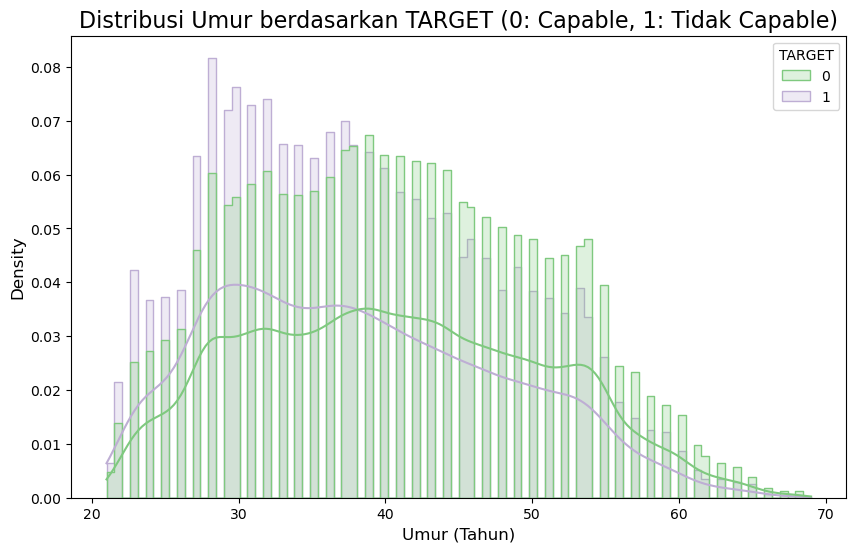

In [ ]:
# Ukuran plot
plt.figure(figsize=(10, 6))

# Membuat visualisasi hubungan antara umur dan TARGET
sns.histplot(data=train, x='age_years', hue='TARGET', kde=True, element='step', stat='density', common_norm=False)

# Menambahkan judul dan label sumbu
plt.title('Distribusi Umur berdasarkan TARGET (0: Capable, 1: Tidak Capable)', fontsize=16)
plt.xlabel('Umur (Tahun)', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Menampilkan plot
plt.show()

1. Baik nasabah yang lancar membayar maupun yang gagal bayar, distribusi usia mereka cenderung terpusat pada rentang usia produktif (sekitar 25-45 tahun). Ini menunjukkan bahwa sebagian besar peminjam berada dalam kelompok usia ini.
Sedangkan persentase nasabah yang sangat muda atau sangat tua relatif lebih sedikit.
2. Pada rentang usia yang lebih muda (dibawah 30 tahun), persentase nasabah yang gagal bayar cenderung lebih tinggi. Ini mungkin mengindikasikan bahwa nasabah muda cenderung memiliki stabilitas finansial yang lebih rendah atau kurang pengalaman dalam mengelola keuangan.

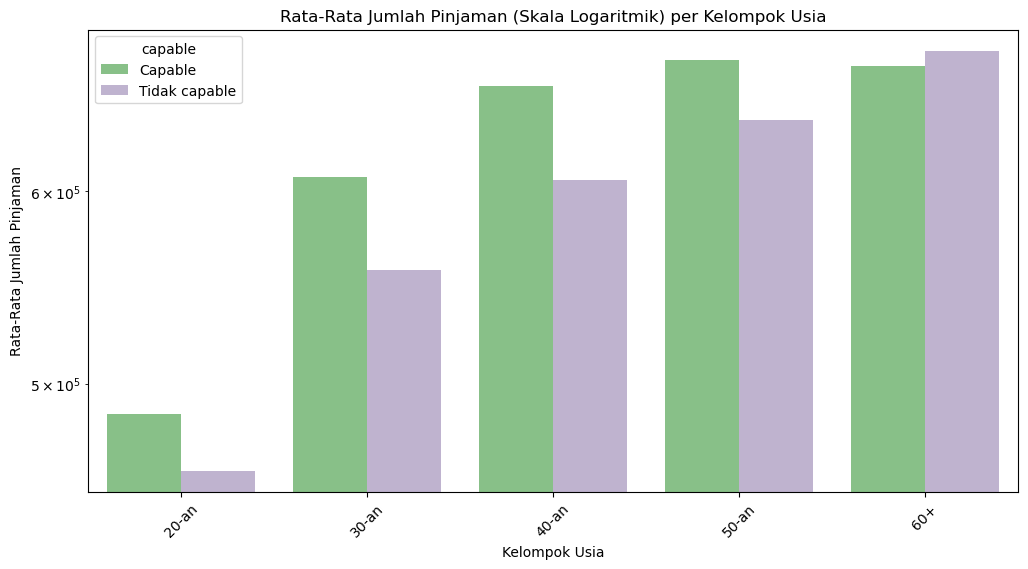

In [ ]:
# Pengelompokan usia
train['age_group'] = pd.cut(train['age_years'], bins=[20, 30, 40, 50, 60, 70], labels=['20-an', '30-an', '40-an', '50-an', '60+'])

# Menghitung rata-rata
usia_avg_credit = train.groupby(['age_group', 'capable'])['AMT_CREDIT'].mean().reset_index()

# Membuat barplot dengan skala logaritmik
plt.figure(figsize=(12, 6))
sns.barplot(data=usia_avg_credit, x='age_group', y='AMT_CREDIT', hue='capable')
plt.yscale('log')
plt.title('Rata-Rata Jumlah Pinjaman (Skala Logaritmik) per Kelompok Usia')
plt.xlabel('Kelompok Usia')
plt.ylabel('Rata-Rata Jumlah Pinjaman')
plt.xticks(rotation=45)
plt.show()

1. Kelompok usia 40-an memiliki jumlah pinjaman rata-rata tertinggi untuk peminjam yang capable. Ini menunjukkan bahwa orang di usia ini mungkin berada di puncak karir atau memiliki penghasilan yang stabil, sehingga mereka cenderung mengambil pinjaman lebih besar dibanding kelompok usia lainnya.
2. Terjadi peningkatan yang signifikan dalam rata-rata jumlah pinjaman untuk kelompok usia 30-an, terutama pada peminjam yang capable. Hal ini mungkin menunjukkan bahwa di usia 30-an, peminjam memiliki stabilitas keuangan yang lebih baik atau kepercayaan dari pemberi pinjaman lebih tinggi, sehingga mereka cenderung meminjam lebih banyak

## NAME_EDUCATION_TYPE

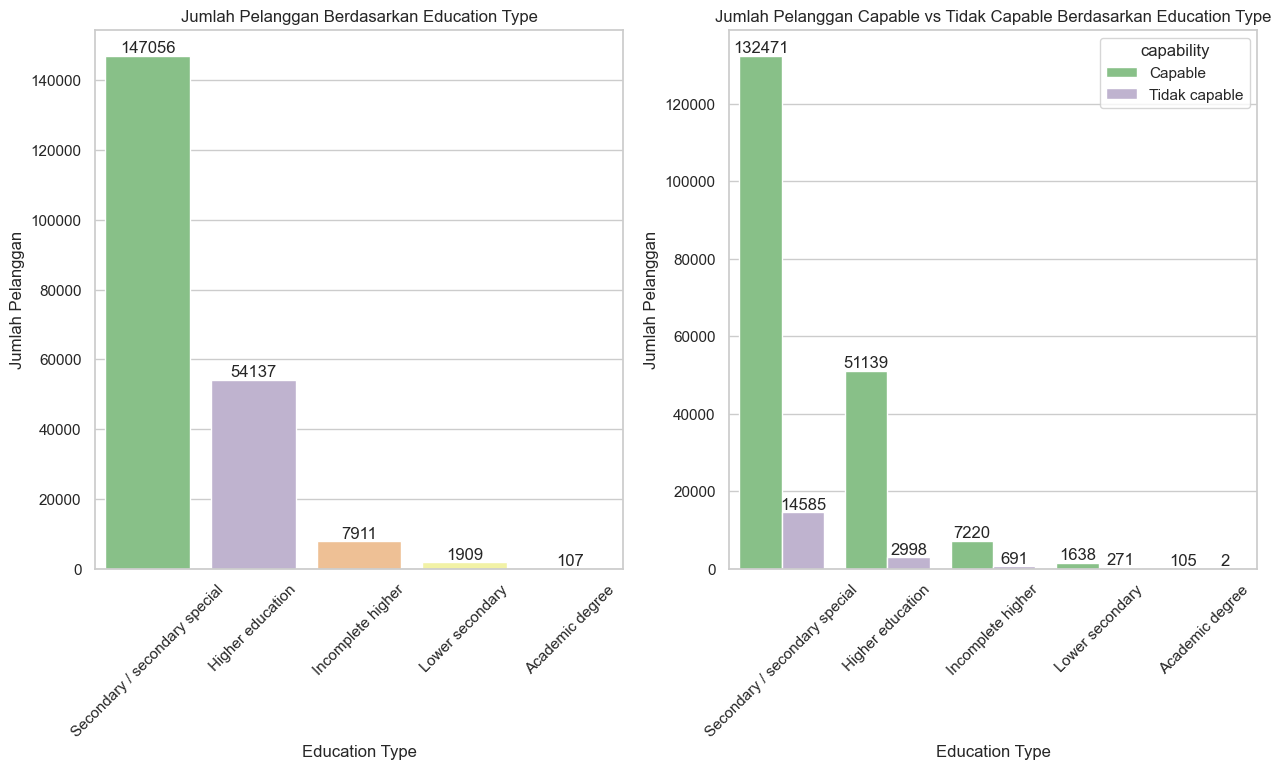

<Figure size 1000x600 with 0 Axes>

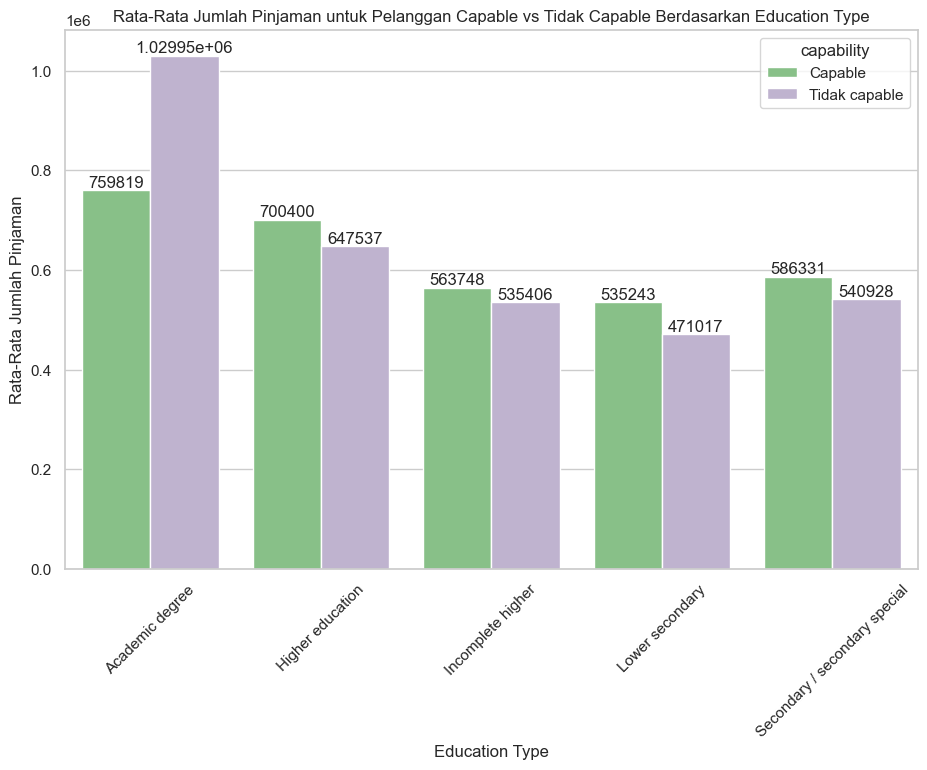

In [ ]:
# Mengatur data capability berdasarkan TARGET
train['capability'] = train['TARGET'].apply(lambda x: 'Tidak capable' if x == 1 else 'Capable')

# Mengatur tema seaborn
sns.set()

sns.set_style("whitegrid")
sns.set_palette("Accent")

# Membuat figure dan axis dengan dua subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Menghitung jumlah berdasarkan 'NAME_EDUCATION_TYPE' dan 'capability'
edu_count = train.groupby(['NAME_EDUCATION_TYPE', 'capability'])['SK_ID_CURR'].count().sort_values(ascending=False).reset_index()
edu_count.columns = ['education_type', 'capability', 'count']

# Plot pertama: Jumlah Pelanggan Berdasarkan Education Type
edu_type = train['NAME_EDUCATION_TYPE'].value_counts()
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(y=edu_type.values, x=edu_type.index, palette='Accent', ax=axes[0])
for cont in ax1.containers:
    ax1.bar_label(cont)
plt.tight_layout()
ax1.set_title('Jumlah Pelanggan Berdasarkan Education Type')
ax1.set_xlabel('Education Type')
ax1.set_ylabel('Jumlah Pelanggan')
ax1.tick_params(axis='x', rotation=45)

# Plot kedua: Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Education Type
ax2 = sns.barplot(data=edu_count, x='education_type', y='count', hue='capability', palette='Accent', ax=axes[1])

# Menambahkan label pada bar
for cont in ax2.containers:
    ax2.bar_label(cont)

# Mengatur judul dan rotasi label sumbu x pada plot kedua
ax2.set_title('Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Education Type')
ax2.set_xlabel('Education Type')
ax2.set_ylabel('Jumlah Pelanggan')
ax2.tick_params(axis='x', rotation=45)

# Mengatur tata letak agar tidak bertumpukan
plt.tight_layout()

# Menampilkan plot
plt.show()


#Rata-rata pinjaman berdasarkan Education_Type
edu_avg_credit = train.groupby(['NAME_EDUCATION_TYPE', 'capability'])['AMT_CREDIT'].mean().reset_index()

plt.figure(figsize=(11, 7))
ax2 = sns.barplot(data=edu_avg_credit, x='NAME_EDUCATION_TYPE', y='AMT_CREDIT', hue='capability', palette='Accent')
for cont in ax2.containers:
    ax2.bar_label(cont)
plt.title('Rata-Rata Jumlah Pinjaman untuk Pelanggan Capable vs Tidak Capable Berdasarkan Education Type')
plt.xticks(rotation=45)
plt.xlabel('Education Type')
plt.ylabel('Rata-Rata Jumlah Pinjaman')
plt.show()

**Jumlah Pelanggan Berdasarkan Education_Type**

Terdapat perbedaan yang signifikan antara jumlah pelanggan dengan tingkat pendidikan Secondary/Secondary Special dengan tingkat pendidikan lainnya.

**Jumlah Pelanggan Capable vs Tidak Capable Berdasarkan Education Type**

Setiap tingkat pendidikan memiliki perbandingan jumlah pelanggan capable dan tidak capable yang cukup merata, yaitu lebih dari **87,5%**.

**Rata-Rata Jumlah Pinjaman untuk Pelanggan Capable vs Tidak Capable Berdasarkan Education Type**

Mayoritas tingkat pendidikan memiliki pola yang hampir sama, yaitu jumlah pinjaman pelanggan capable sedikit lebih besar daripada jumlah pinjaman pelanggan yang tidak capable. Pengecualian untuk tingkat pendidikan Academic Degree karena hanya terdapat 3 pelanggan yang tidak capable sehingga sangat mempengaruhi rata-rata jumlah pinjaman

## BAR CHART AMT_CREDIT

Text(0.5, 1.0, 'Average Credit by Contract Type')

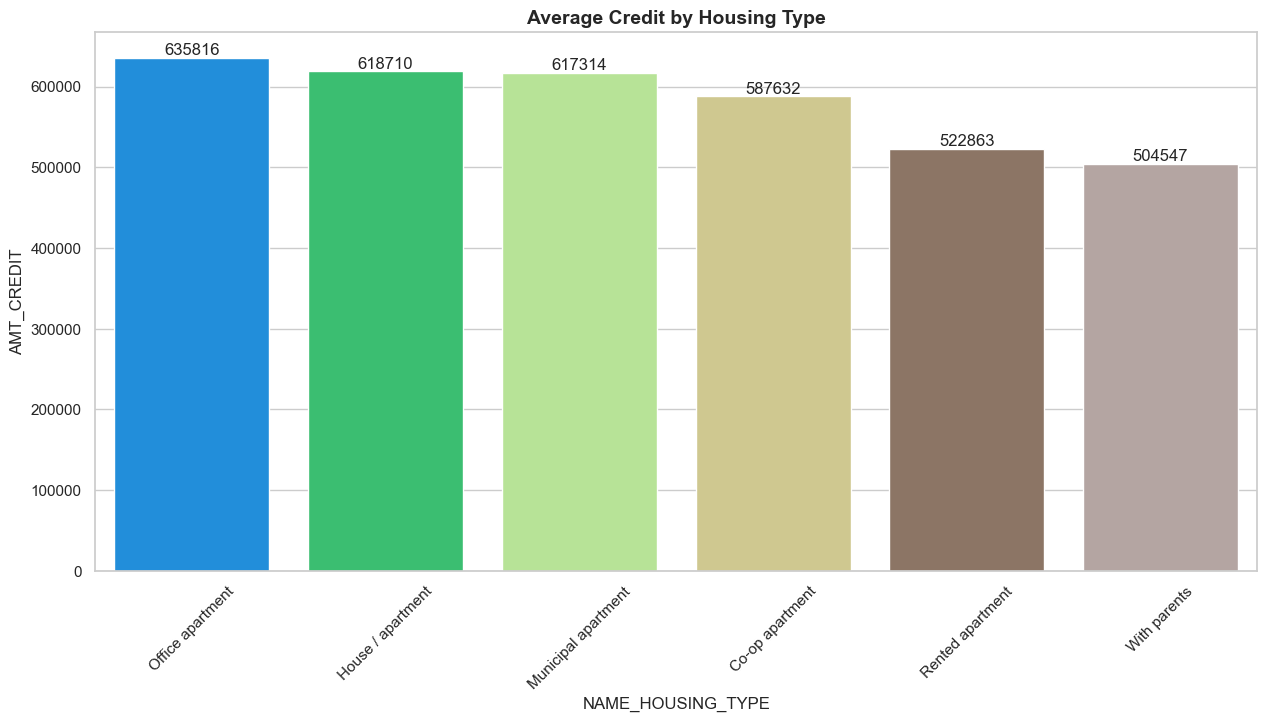

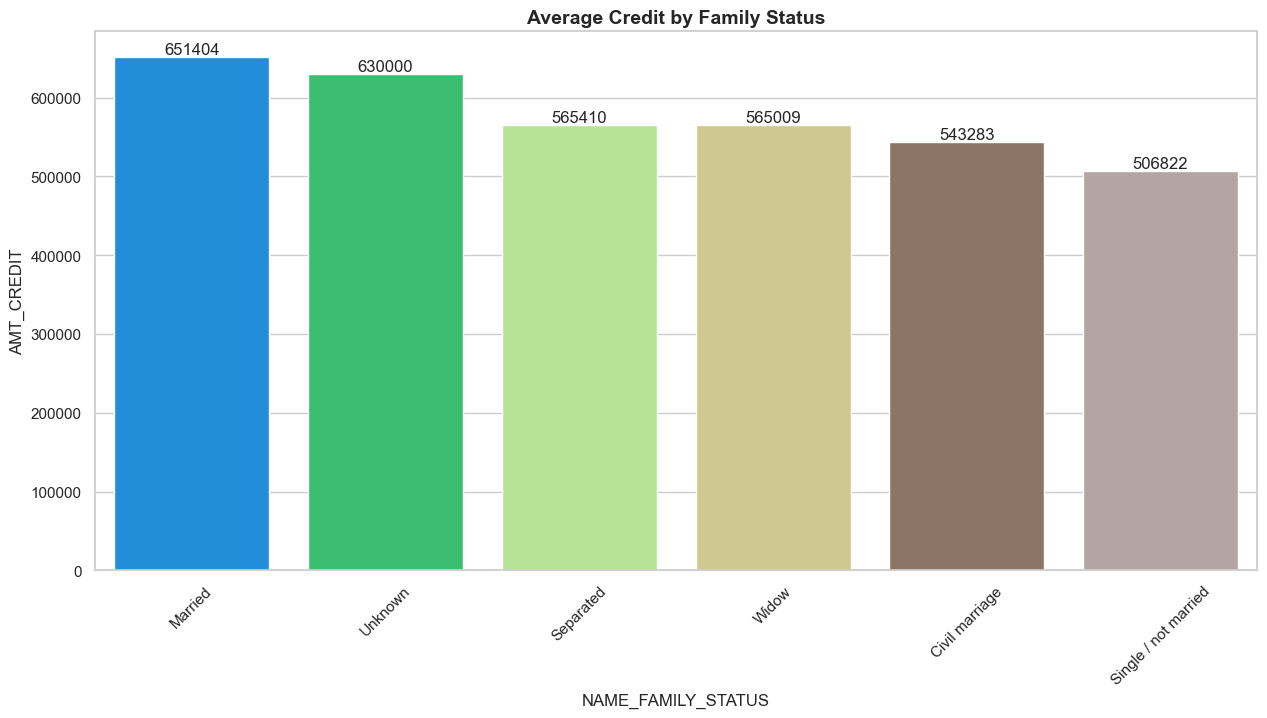

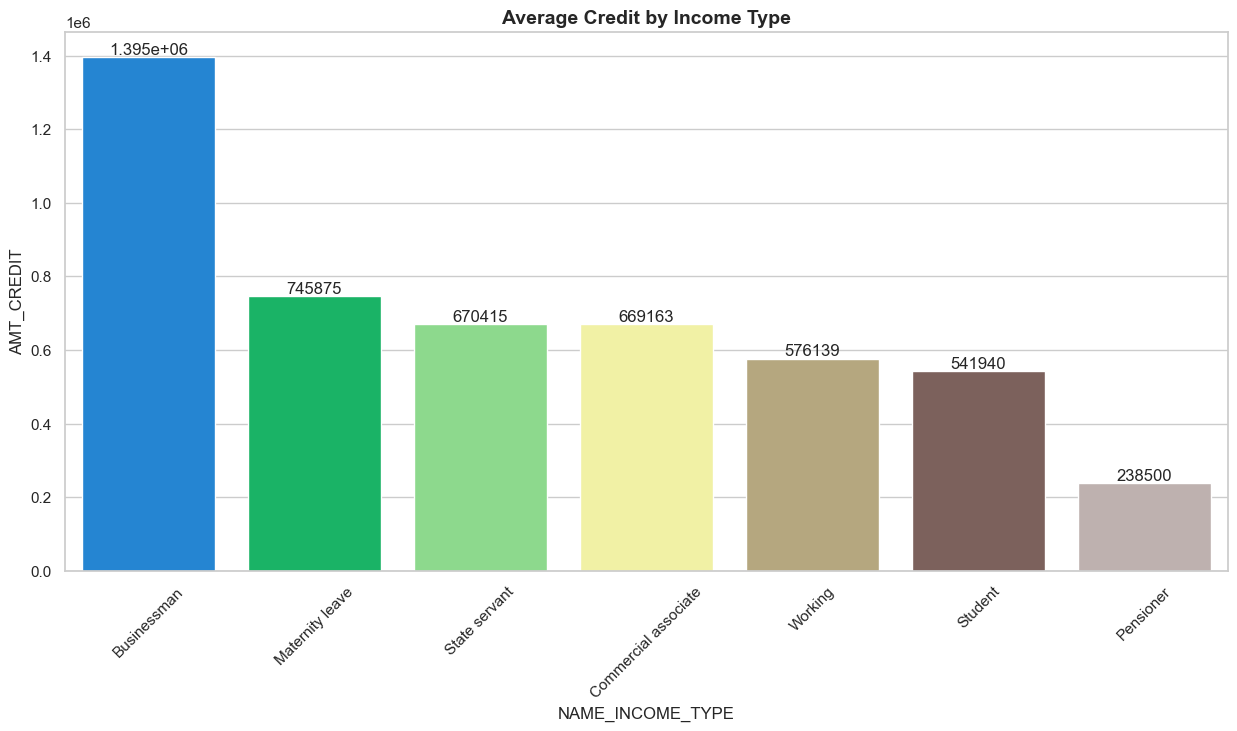

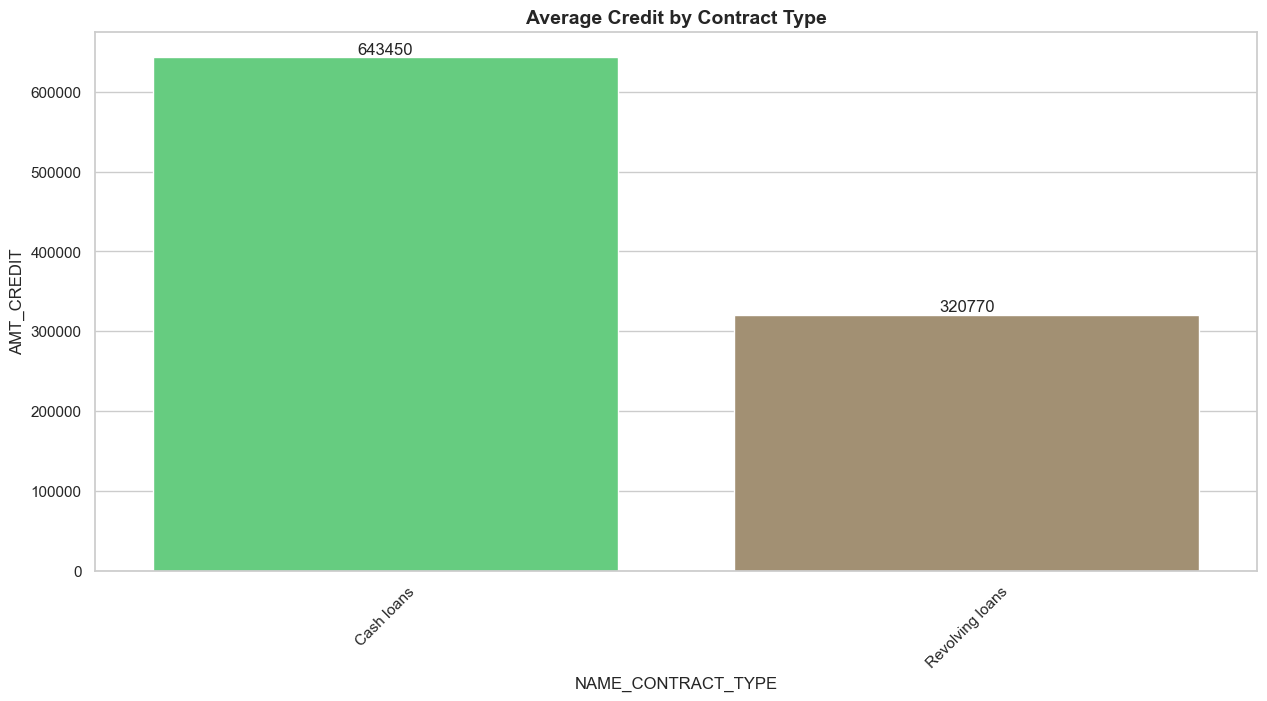

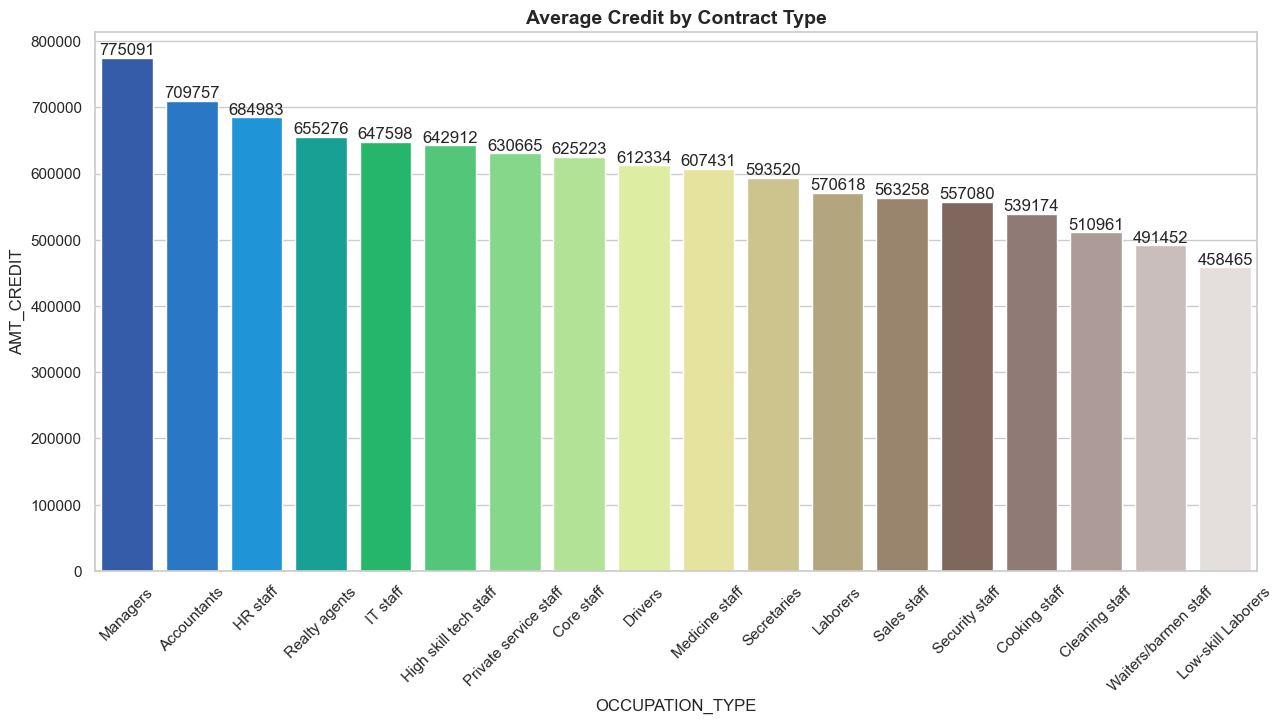

In [ ]:
house_avg_credit = train.groupby('NAME_HOUSING_TYPE')['AMT_CREDIT'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(15, 7))
ax = sns.barplot(data=house_avg_credit, x="NAME_HOUSING_TYPE", y="AMT_CREDIT", palette='terrain')
for cont in ax.containers:
    ax.bar_label(cont)
plt.xticks(rotation=45)
plt.title('Average Credit by Housing Type', fontsize=14, fontweight='bold')

family_avg_credit = train.groupby('NAME_FAMILY_STATUS')['AMT_CREDIT'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(15, 7))
ax = sns.barplot(data=family_avg_credit, x="NAME_FAMILY_STATUS", y="AMT_CREDIT", palette='terrain')
for cont in ax.containers:
    ax.bar_label(cont)
plt.xticks(rotation=45)
plt.title('Average Credit by Family Status', fontsize=14, fontweight='bold')

income_avg_credit = train.groupby('NAME_INCOME_TYPE')['AMT_CREDIT'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(15, 7))
ax = sns.barplot(data=income_avg_credit, x="NAME_INCOME_TYPE", y="AMT_CREDIT", palette='terrain')
for cont in ax.containers:
    ax.bar_label(cont)
plt.xticks(rotation=45)
plt.title('Average Credit by Income Type', fontsize=14, fontweight='bold')

contract_avg_credit = train.groupby('NAME_CONTRACT_TYPE')['AMT_CREDIT'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(15, 7))
ax = sns.barplot(data=contract_avg_credit, x="NAME_CONTRACT_TYPE", y="AMT_CREDIT", palette='terrain')
for cont in ax.containers:
    ax.bar_label(cont)
plt.xticks(rotation=45)
plt.title('Average Credit by Contract Type', fontsize=14, fontweight='bold')

occupation_avg_credit = train.groupby('OCCUPATION_TYPE')['AMT_CREDIT'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(15, 7))
ax = sns.barplot(data=occupation_avg_credit, x="OCCUPATION_TYPE", y="AMT_CREDIT", palette='terrain')
for cont in ax.containers:
    ax.bar_label(cont)
plt.xticks(rotation=45)
plt.title('Average Credit by Contract Type', fontsize=14, fontweight='bold')

**Average Credit by Housing Type**

Didominasi oleh pelanggan yang bertipe housing apartment di mana office apartment menjadi yang paling tinggi, sementara pelanggan yang tinggal bersama orangtua memiliki rata-rata credit paling rendah

**Average Credit by Family Status**

Pelanggan yang sudah menikah memiliki rata-rata credit paling tinggi, sementara yang belum menikah sama sekali memiliki rata-rata paling rendah

 **Average Credit by Income Type**

Rata-rata credit businessman sangat mendominasi dibandingkan income type lain, sedangkan pelanggan pensiunan memiliki rata-rata pinjaman yang jauh lebih rendah dibandingkan income type lain

**Average Credit by Contract Type**

Pelanggan yang menggunakan tipe kontrak cash loans memiliki rata-rata credit 2 kali lebih besar daripada revolving loans

**Average Credit by Occupation Type**

Tipe-tipe pekerjaan kantoran mendominasi dalam rata-rata credit berdasarkan jenis perkerjaan, dengan manager sebagai yang tertinggi

## DISTRIBUSI AMT_Credit

Counts of duplicate SK_ID_CURR:
Each row in the train_data has a unique SK_ID_CURR.


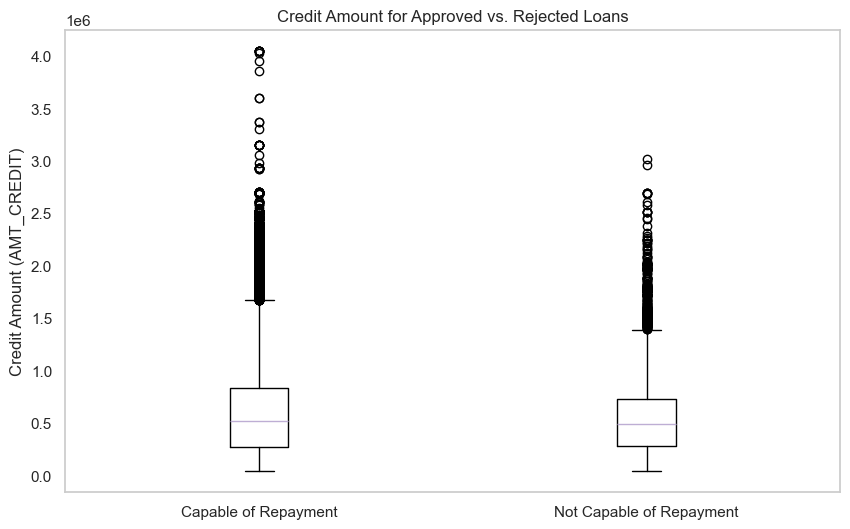

Descriptive Statistics for Approved Loans:
count    1.925730e+05
mean     6.154364e+05
std      4.107255e+05
min      4.500000e+04
25%      2.762775e+05
50%      5.212800e+05
75%      8.353800e+05
max      4.050000e+06
dtype: float64

Descriptive Statistics for Rejected Loans:
count    1.854700e+04
mean     5.569863e+05
std      3.454487e+05
min      4.500000e+04
25%      2.844000e+05
50%      4.959855e+05
75%      7.284600e+05
max      3.020760e+06
dtype: float64


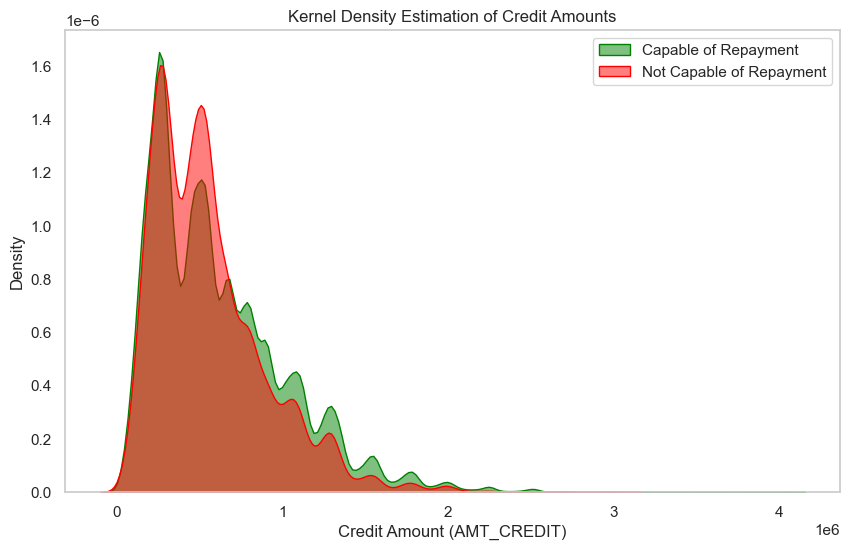


Comparison of Means:
Mean Approved Loan Credit: 615436.44
Mean Rejected Loan Credit: 556986.32

Comparison of Medians:
Median Approved Loan Credit: 521280.00
Median Rejected Loan Credit: 495985.50


In [ ]:
# Step 1: Check for duplicate SK_ID_CURR in the test_train dataset
duplicate_counts = train.groupby('SK_ID_CURR').size()

# Print the counts of duplicates
print("Counts of duplicate SK_ID_CURR:")
for count in duplicate_counts:
    if count > 1:
        print(count)

# Step 2: Check if each row in train_data has a unique SK_ID_CURR
unique_ids_train = train['SK_ID_CURR'].nunique()
total_rows_train = train.shape[0]

if unique_ids_train == total_rows_train:
    print("Each row in the train_data has a unique SK_ID_CURR.")
else:
    print(f"There are {total_rows_train - unique_ids_train} duplicate SK_ID_CURR entries in train_data.")

# Step 3: Extract credit amounts for approved and rejected loans
approved_loan_credit = train[train['TARGET'] == 0]['AMT_CREDIT'].values
rejected_loan_credit = train[train['TARGET'] == 1]['AMT_CREDIT'].values

# Step 4: Create a boxplot for visualization
plt.figure(figsize=(10, 6))
plt.boxplot([approved_loan_credit, rejected_loan_credit])

# Adding title and labels
plt.title('Credit Amount for Approved vs. Rejected Loans')
plt.xticks([1, 2], ['Capable of Repayment', 'Not Capable of Repayment'])
plt.ylabel('Credit Amount (AMT_CREDIT)')
plt.grid()

# Show the plot
plt.show()

# Step 5: Optional - Print descriptive statistics
approved_stats = pd.Series(approved_loan_credit).describe()
rejected_stats = pd.Series(rejected_loan_credit).describe()

print("Descriptive Statistics for Approved Loans:")
print(approved_stats)

print("\nDescriptive Statistics for Rejected Loans:")
print(rejected_stats)

# Step 6: Distribution Plots for Credit Amounts
plt.figure(figsize=(10, 6))
sns.kdeplot(approved_loan_credit, label="Capable of Repayment", color='green', fill=True, alpha=0.5)
sns.kdeplot(rejected_loan_credit, label="Not Capable of Repayment", color='red', fill=True, alpha=0.5)
plt.title('Kernel Density Estimation of Credit Amounts')
plt.xlabel('Credit Amount (AMT_CREDIT)')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

# Step 7: Compare Mean and Median of Credit Amounts
print("\nComparison of Means:")
print(f"Mean Approved Loan Credit: {approved_stats['mean']:.2f}")
print(f"Mean Rejected Loan Credit: {rejected_stats['mean']:.2f}")
print("\nComparison of Medians:")
print(f"Median Approved Loan Credit: {approved_stats['50%']:.2f}")
print(f"Median Rejected Loan Credit: {rejected_stats['50%']:.2f}")

Kurva hijau menunjukkan distribusi jumlah kredit untuk pinjaman yang disetujui, dan kurva merah menunjukkan distribusi untuk pinjaman yang ditolak.

Grafik tersebut menunjukkan bahwa distribusi jumlah kredit untuk pinjaman yang disetujui lebih menyebar dan memiliki ekor yang lebih panjang daripada distribusi jumlah kredit untuk pinjaman yang ditolak.
.Secara keseluruhan, grafik dan statistik menunjukkan bahwa pinjaman yang disetujui cenderung memiliki jumlah kredit yang lebih tinggi dan lebih banyak variabilitas dalam jumlah kredit dibandingkan dengan pinjaman yang ditolak.

## DISTRIBUSI Amt_Goods_Price

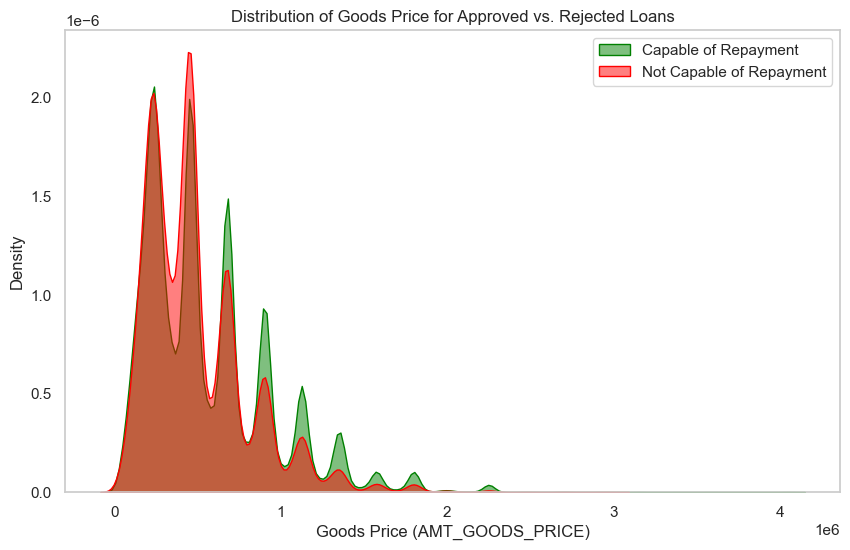

Descriptive Statistics for Goods Price (Capable of Repayment):
count    1.925730e+05
mean     5.539187e+05
std      3.770936e+05
min      4.050000e+04
25%      2.475000e+05
50%      4.500000e+05
75%      7.020000e+05
max      4.050000e+06
dtype: float64

Descriptive Statistics for Goods Price (Not Capable of Repayment):
count    1.854700e+04
mean     4.874241e+05
std      3.100448e+05
min      4.500000e+04
25%      2.385000e+05
50%      4.500000e+05
75%      6.750000e+05
max      2.961000e+06
dtype: float64


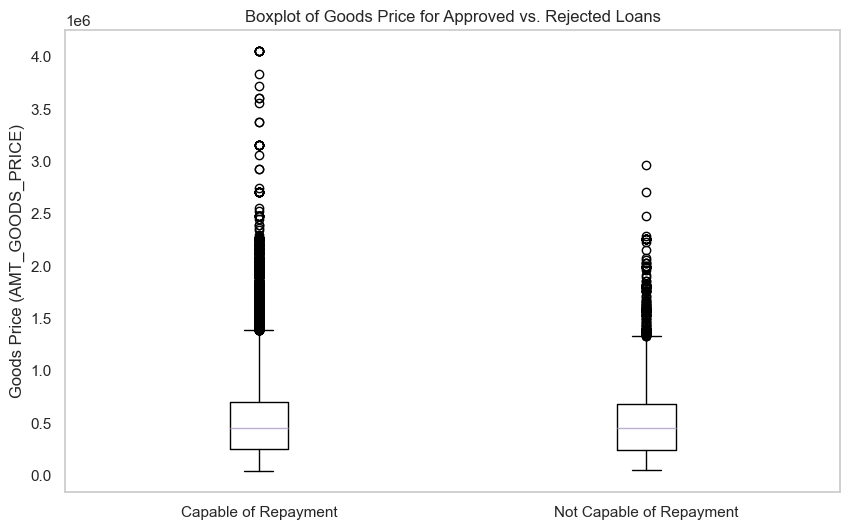

In [ ]:
# Step 1: Extract Goods Prices for Capable and Not Capable of Repayment
capable_loan_goods_price = train[train['TARGET'] == 0]['AMT_GOODS_PRICE'].values
not_capable_loan_goods_price = train[train['TARGET'] == 1]['AMT_GOODS_PRICE'].values

# Step 2: Create a Distribution Plot for Goods Prices
plt.figure(figsize=(10, 6))
sns.kdeplot(capable_loan_goods_price, label="Capable of Repayment", color='green', fill=True, alpha=0.5)
sns.kdeplot(not_capable_loan_goods_price, label="Not Capable of Repayment", color='red', fill=True, alpha=0.5)

# Step 3: Add Titles and Labels
plt.title('Distribution of Goods Price for Approved vs. Rejected Loans')
plt.xlabel('Goods Price (AMT_GOODS_PRICE)')
plt.ylabel('Density')
plt.legend()
plt.grid()

# Step 4: Show the Plot
plt.show()

# Step 5: Print Descriptive Statistics
capable_goods_price_stats = pd.Series(capable_loan_goods_price).describe()
not_capable_goods_price_stats = pd.Series(not_capable_loan_goods_price).describe()

print("Descriptive Statistics for Goods Price (Capable of Repayment):")
print(capable_goods_price_stats)

print("\nDescriptive Statistics for Goods Price (Not Capable of Repayment):")
print(not_capable_goods_price_stats)

# Step 6: Boxplot for Additional Visualization
plt.figure(figsize=(10, 6))
plt.boxplot([capable_loan_goods_price, not_capable_loan_goods_price], labels=['Capable of Repayment', 'Not Capable of Repayment'])
plt.title('Boxplot of Goods Price for Approved vs. Rejected Loans')
plt.ylabel('Goods Price (AMT_GOODS_PRICE)')
plt.grid()

# Step 7: Show the Boxplot
plt.show()

Kurva hijau menggambarkan distribusi harga barang untuk pinjaman yang mampu dilunasi, dan kurva merah menggambarkan distribusi untuk pinjaman yang tidak mampu dilunasi.
Grafik tersebut menunjukkan bahwa sebaran harga barang untuk pinjaman yang mampu dilunasi lebih menyebar dan memiliki ekor yang lebih panjang dibandingkan dengan sebaran harga barang untuk pinjaman yang mampu dilunasi
.Secara keseluruhan, grafik dan statistik menunjukkan bahwa pinjaman yang mampu dilunasi cenderung memiliki harga barang yang lebih tinggi dan lebih banyak variabilitas dalam harga barang dibandingkan dengan pinjaman yang tidak mampu dilunasi.

# Bureau dan Bureau Balance Dataset

In [ ]:
bureau.sample(5)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
716358       431968       6488379        Closed      currency 1        -2336   
1673190      149963       5740630        Active      currency 1         -311   
1616705      431183       6522709        Closed      currency 1        -1565   
1083660      216556       6219808        Closed      currency 1        -2275   
1309288      351812       5431490        Active      currency 1        -1514   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
716358                    0              -1789.0            -1819.0   
1673190                   0               1433.0                NaN   
1616705                   0               -832.0             -807.0   
1083660                   0              -1547.0            -1574.0   
1309288                   0                312.0                NaN   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
716358                      NaN                   0        202500.0   
1673190                     NaN                   0             0.0   
1616705                     NaN                   0         62806.5   
1083660                     NaN                   0        315000.0   
1309288                  9099.0                   0        504900.0   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
716358                   0.0                   0.0                     0.0   
1673190                  0.0                   0.0                     0.0   
1616705                  0.0                   0.0                     0.0   
1083660                  0.0                   0.0                     0.0   
1309288                  NaN                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
716358   Consumer credit               -1297          NaN  
1673190      Credit card                  -4          NaN  
1616705  Consumer credit                -773          NaN  
1083660  Consumer credit               -1534          NaN  
1309288  Consumer credit                 -22          NaN

In [ ]:
bureau_balance.sample(5)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
15868345       5678993             -31      X
8270991        6407733             -11      C
23584760       5143530             -35      X
19972779       5950644              -7      0
10725485       6526316             -40      C

In [ ]:
bureau.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [ ]:
numerical_bureau = bureau.select_dtypes(include=['int64', 'float64']).columns
categorical_bureau = bureau.select_dtypes(include=['object']).columns

In [ ]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [ ]:
bureau['CREDIT_TYPE'].value_counts()

CREDIT_TYPE
Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: count, dtype: int64

In [ ]:
key = ['SK_ID_BUREAU']
bureau_balance_categorical = ['STATUS']
bureau_balance_numerical = ['MONTHS_BALANCE']

In [ ]:
duplicates = bureau_balance.duplicated().any()
print (f"jumlah baris duplikat :{duplicates.sum()}")
duplicate_rows = bureau_balance[bureau_balance.duplicated()]
print(f"jumlah duplikat baris : {duplicate_rows.sum()}")

jumlah baris duplikat :0
jumlah duplikat baris : SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: object


## Univariate Analysis

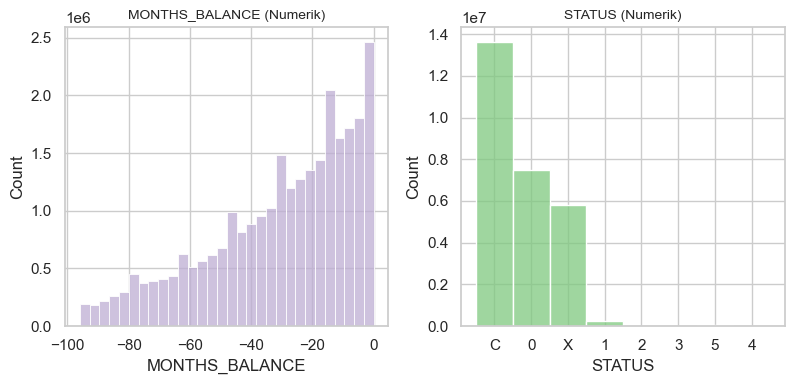

In [ ]:
# Menggabungkan semua kolom ke dalam satu daftar
all_cols = list(bureau_balance_numerical) + list(bureau_balance_categorical)

# Menghitung jumlah total fitur untuk layout
num_cols = len(all_cols)
num_rows = (num_cols // 5) + 1  # Setiap 5 kolom, buat baris baru

# Membuat palet warna Accent dari seaborn
palette = sns.color_palette("Accent", num_cols)

# Mengatur ukuran plot (disesuaikan dengan jumlah baris dan kolom)
plt.figure(figsize=(20, num_rows * 4))  # Atur ukuran plot secara dinamis

# Membuat histogram untuk setiap kolom numerik dan kategorikal
for i, col in enumerate(all_cols, 1):
    plt.subplot(num_rows, 5, i)  # Mengatur layout, misal: 5 kolom per baris
    
    if col in all_cols:
        # Jika kolom numerik
        sns.histplot(bureau_balance[col].dropna(), bins=30, color=palette[i % len(palette)], kde=False)
        plt.title(f'{col} (Numerik)', fontsize=10)
    else:
        # Jika kolom kategorikal
        sns.histplot(bureau_balance[col].dropna(), bins=30, color=palette[i % len(palette)], kde=False)
        plt.title(f'{col} (Kategorikal)', fontsize=10)

    plt.tight_layout()

# Mengatur jarak antar subplots
plt.subplots_adjust(hspace=0.6)  # Atur jarak antar histogram
plt.show()


## Deskripsi

- Tren Meningkat: Semakin mendekati nilai 0 pada sumbu X (MONTHS_BALANCE), jumlah akun yang tercatat semakin meningkat. Ini menunjukkan bahwa data yang lebih baru cenderung memiliki jumlah observasi yang lebih banyak.
- Distribusi Status: Setiap status memiliki pola distribusi yang berbeda terhadap waktu. Beberapa status mungkin lebih dominan pada periode tertentu, sementara status lainnya mungkin lebih sering muncul pada periode lain.
- Perubahan Status: Perubahan proporsi setiap status dari kiri ke kanan menunjukkan adanya peralihan status akun dari waktu ke waktu. Misalnya, jika proporsi status "C" (asumsikan status baik) semakin meningkat mendekati nilai 0, ini bisa mengindikasikan adanya peningkatan kualitas pembayaran nasabah secara keseluruhan.

## Multivariave analysis

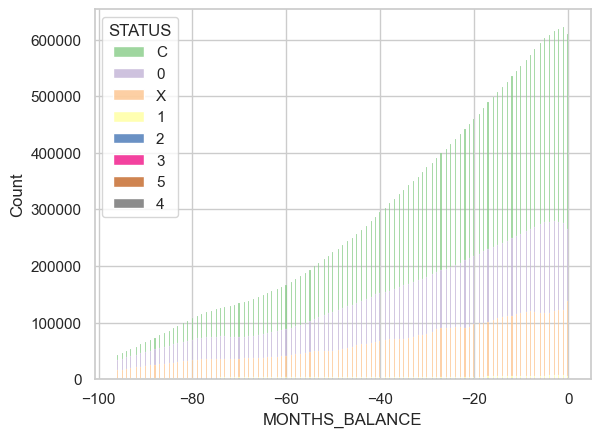

In [ ]:
sns.histplot(data=bureau_balance, x='MONTHS_BALANCE', hue='STATUS', multiple='stack')
plt.show()

## Deskripsi

**Month Balance**

Menunjukkan waktu relatif dari setiap catatan status pembayaran. Nilai-nilai di kolom ini menggambarkan jumlah bulan sebelum saat aplikasi pinjaman dilakukan di Home Credit, dengan nilai negatif yang menunjukkan berapa bulan sebelum aplikasi saat ini.

Misal :
- Nilai 0: Bulan aplikasi pinjaman di Home Credit. Ini menunjukkan bahwa status pembayaran di bulan ini adalah saat paling dekat dengan pengajuan pinjaman di Home Credit.
- Nilai -1: Satu bulan sebelum aplikasi pinjaman di Home Credit.
- Nilai -2: Dua bulan sebelum aplikasi, dan seterusnya hingga nilai terendah.

**Status**

Merepresentasikan status pembayaran dari pelanggan dalam data biro kredit (external bureau). Nilai-nilai dalam kolom STATUS menunjukkan status pembayaran pelanggan pada bulan tertentu terkait dengan pinjaman di bank lain yang datanya dilaporkan ke biro kredit.

Misal : 

- 'C': Closed – Pinjaman telah dilunasi atau rekening kredit telah ditutup.
- 'X': No DPD (Days Past Due) information – Tidak ada data mengenai keterlambatan pembayaran pada bulan ini (misalnya, data tidak tersedia atau tidak relevan untuk bulan tersebut).
- '0': No DPD – Pembayaran tepat waktu. Tidak ada keterlambatan (0 hari keterlambatan).
- '1': 1-30 days past due – Pembayaran terlambat 1-30 hari.
- '2': 31-60 days past due – Pembayaran terlambat 31-60 hari.
- '3': 61-90 days past due – Pembayaran terlambat 61-90 hari.
- '4': 91-120 days past due – Pembayaran terlambat 91-120 hari.
- '5': 120+ days past due – Pembayaran terlambat lebih dari 120 hari.

In [ ]:
bureau_key = ['SK_ID_CURR','SK_ID_BUREAU']
bureau_categorical = ['CREDIT_ACTIVE', 'CREDIT_TYPE']
bureau_numerical = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY']

## Handling Null Value

In [ ]:
# Mengidentifikasi jumlah nilai null di setiap kolom
null_counts = bureau.isnull().sum()

# Menampilkan jumlah nilai null
print(null_counts)

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64


In [ ]:
# Menghapus baris yang memiliki nilai null
bureau = bureau.dropna()
# Mengisi nilai null dengan nilai tetap
bureau= bureau.fillna(0)

## Handling duplicate

In [ ]:
# Mengidentifikasi baris yang duplikat
duplicates = bureau.duplicated()
print(f"Jumlah baris duplikat: {duplicates.sum()}")

# Menampilkan baris yang duplikat
duplicate_rows = bureau[bureau.duplicated()]
print(duplicate_rows)

# Menghapus baris yang duplikat
bureau = bureau.drop_duplicates()


Jumlah baris duplikat: 0
Empty DataFrame
Columns: [SK_ID_CURR, SK_ID_BUREAU, CREDIT_ACTIVE, CREDIT_CURRENCY, DAYS_CREDIT, CREDIT_DAY_OVERDUE, DAYS_CREDIT_ENDDATE, DAYS_ENDDATE_FACT, AMT_CREDIT_MAX_OVERDUE, CNT_CREDIT_PROLONG, AMT_CREDIT_SUM, AMT_CREDIT_SUM_DEBT, AMT_CREDIT_SUM_LIMIT, AMT_CREDIT_SUM_OVERDUE, CREDIT_TYPE, DAYS_CREDIT_UPDATE, AMT_ANNUITY]
Index: []


## Handling Outliers

In [ ]:
# Mengidentifikasi outlier menggunakan IQR
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]


# Menghapus outlier berdasarkan IQR
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

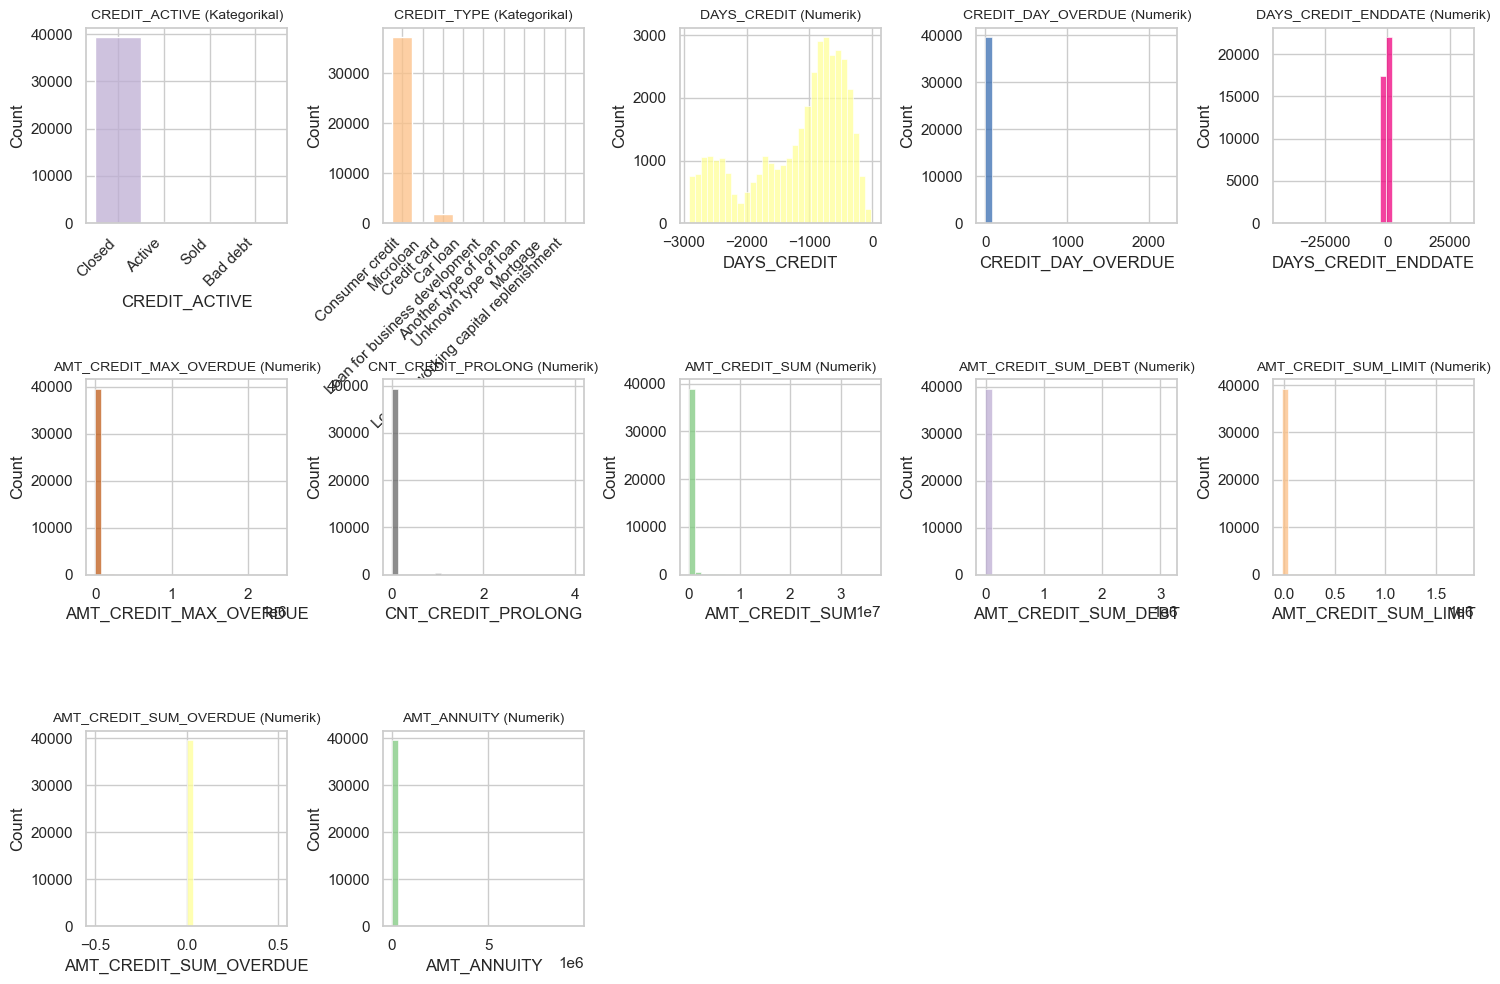

In [ ]:
# Menggabungkan kolom kategorikal dan numerik
all_cols2 = bureau_categorical + bureau_numerical

# Menghitung jumlah kolom dan baris untuk layout
num_cols2 = len(all_cols2)
num_rows2 = (num_cols2 // 5) + 1

# Membuat palet warna Accent
palette = sns.color_palette("Accent", num_cols2)

# Mengatur ukuran plot
plt.figure(figsize=(15, 10))

# Membuat histogram untuk setiap kolom
for i, col in enumerate(all_cols2, 1):
    plt.subplot(num_rows2, 5, i)

    if col in bureau_categorical:
        sns.histplot(bureau[col], color=palette[i % len(palette)])
        plt.title(f'{col} (Kategorikal)', fontsize=10)
        plt.xticks(rotation=45, ha='right')
    else:
        sns.histplot(bureau[col].dropna(), bins=30, color=palette[i % len(palette)])
        plt.title(f'{col} (Numerik)', fontsize=10)

    plt.tight_layout()

# Mengatur jarak antar subplots
plt.subplots_adjust(hspace=0.8)
plt.show()

**Variable Kategorikal**

- CREDIT_ACTIVE: Sebagian besar kredit dalam status aktif, diikuti oleh kredit yang telah ditutup. Ini menunjukkan bahwa sebagian besar nasabah masih memiliki pinjaman yang aktif.
- CREDIT_TYPE: Jenis kredit yang paling umum adalah kredit konsumen. Jenis kredit lainnya seperti kredit mobil dan pinjaman bisnis juga cukup signifikan.

**Variable Numerik**

- DAYS_CREDIT: Sebagian besar kredit diberikan dalam beberapa tahun terakhir (nilai negatif mendekati nol). Ini menunjukkan bahwa data kredit yang digunakan relatif baru.
- CREDIT_DAY_OVERDUE: Sebagian besar nasabah membayar tagihan tepat waktu atau memiliki sedikit tunggakan. Namun, ada juga sejumlah kecil nasabah dengan tunggakan yang cukup lama.
- DAYS_CREDIT_ENDDATE: Tanggal berakhirnya kredit bervariasi, namun ada kecenderungan bahwa banyak kredit memiliki jangka waktu yang relatif pendek.
- AMT_CREDIT_MAX_OVERDUE: Jumlah maksimum tunggakan pembayaran bervariasi secara signifikan, dengan sebagian besar nasabah memiliki tunggakan yang relatif kecil.
- CNT_CREDIT_PROLONG: Sebagian besar nasabah tidak memperpanjang kredit mereka.
- AMT_CREDIT_SUM: Total jumlah kredit yang diberikan bervariasi secara signifikan, menunjukkan adanya perbedaan yang besar dalam jumlah pinjaman yang diambil oleh nasabah.
- AMT_CREDIT_SUM_DEBT: Total jumlah utang yang belum terbayar juga bervariasi secara signifikan, sesuai dengan variasi dalam jumlah kredit yang diberikan.
- AMT_CREDIT_SUM_LIMIT: Batas maksimum kredit yang diberikan juga bervariasi, menunjukkan perbedaan dalam kemampuan kredit masing-masing nasabah.
- AMT_CREDIT_SUM_OVERDUE: Jumlah total tunggakan pembayaran sebagian besar kecil, namun ada beberapa nasabah dengan tunggakan yang cukup besar.
- AMT_ANNUITY: Jumlah angsuran bulanan juga bervariasi secara signifikan, menunjukkan perbedaan dalam kemampuan pembayaran nasabah.

CREDIT_ACTIVE
Closed      39398
Sold          153
Active        114
Bad debt        1
Name: count, dtype: int64


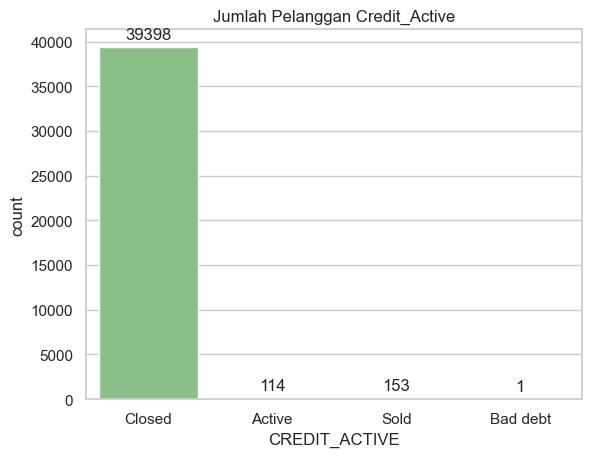

In [ ]:
# Distribusi kategori
print(bureau['CREDIT_ACTIVE'].value_counts())
sns.countplot(x='CREDIT_ACTIVE', data=bureau, palette='Accent')
ax = plt.gca()
plt.title('Jumlah Pelanggan Credit_Active')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.show()

**Observasi**

Jumlah Pelanggan yang memiliki credit closed sebanyak **39398**, yang masih aktif sebanyak **114**, kredit aktif yang di jual sebanyak **153**, sedangkan yang memiliki bad credit hanya **1**

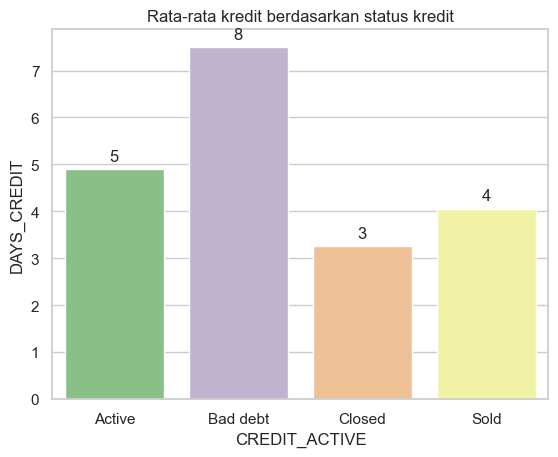

In [ ]:
# Mengonversi hari
bureau['DAYS_CREDIT'] = (bureau['DAYS_CREDIT'] / -365).round(1)

# Durasi rata-rata kredit berdasarkan status kredit
avg_duration = bureau.groupby('CREDIT_ACTIVE')['DAYS_CREDIT'].mean().reset_index()
sns.barplot(data=avg_duration, x='CREDIT_ACTIVE', y='DAYS_CREDIT', palette='Accent')
ax = plt.gca()
plt.title('Rata-rata kredit berdasarkan status kredit')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.show()

**Observasi**

Rata-rata kredit berdasarkan status kredit yaitu,
- **Active** sebanyak 5
- **Bad Credit** sebanyak 8
- **Closed** Sebanyak 3
- **Sold** sebanyak 4

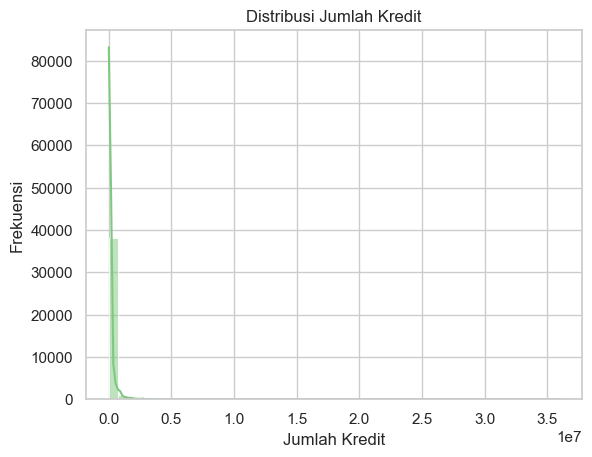

In [ ]:
# Distribusi jumlah kredit
sns.histplot(bureau['AMT_CREDIT_SUM'], bins=50, kde=True, palette='Accent')
plt.title('Distribusi Jumlah Kredit')
plt.xlabel('Jumlah Kredit')
plt.ylabel('Frekuensi')
plt.show()

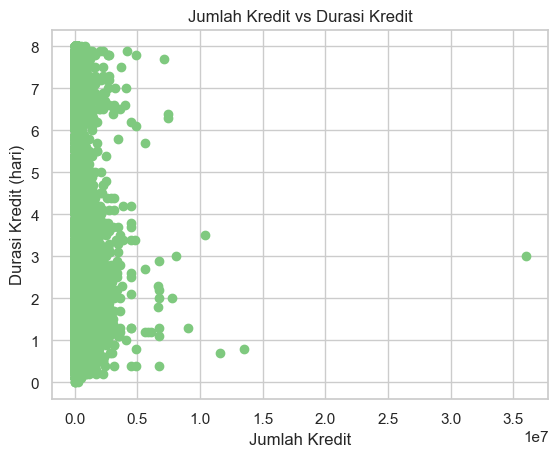

In [ ]:
# Scatter plot antara jumlah kredit dan durasi kredit
plt.scatter(bureau['AMT_CREDIT_SUM'], bureau['DAYS_CREDIT'])
plt.title('Jumlah Kredit vs Durasi Kredit')
plt.xlabel('Jumlah Kredit')
plt.ylabel('Durasi Kredit (hari)')
plt.show()

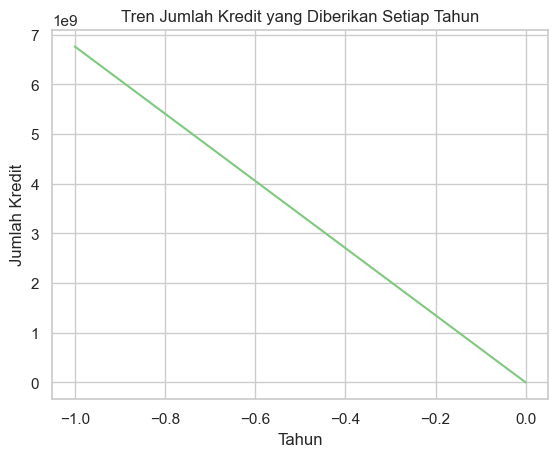

In [ ]:
# Konversi kolom 'DAYS_CREDIT' ke tahun
bureau['YEAR_CREDIT'] = bureau['DAYS_CREDIT'] // -365

# Tren jumlah kredit yang diberikan setiap tahun
credit_trend = bureau.groupby('YEAR_CREDIT')['AMT_CREDIT_SUM'].sum()
credit_trend.plot(kind='line')
plt.title('Tren Jumlah Kredit yang Diberikan Setiap Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Kredit')
plt.show()

In [ ]:
# Analisis risiko kredit
risk_analysis = bureau.groupby('CREDIT_ACTIVE')['AMT_CREDIT_SUM'].agg(['mean', 'median', 'std'])
print(risk_analysis)

                        mean    median            std
CREDIT_ACTIVE                                        
Active         224163.976974   90000.0  581601.705492
Bad debt        57550.500000   57550.5            NaN
Closed         168469.969164   81360.0  386053.192648
Sold           661363.555588  225000.0  972633.276060


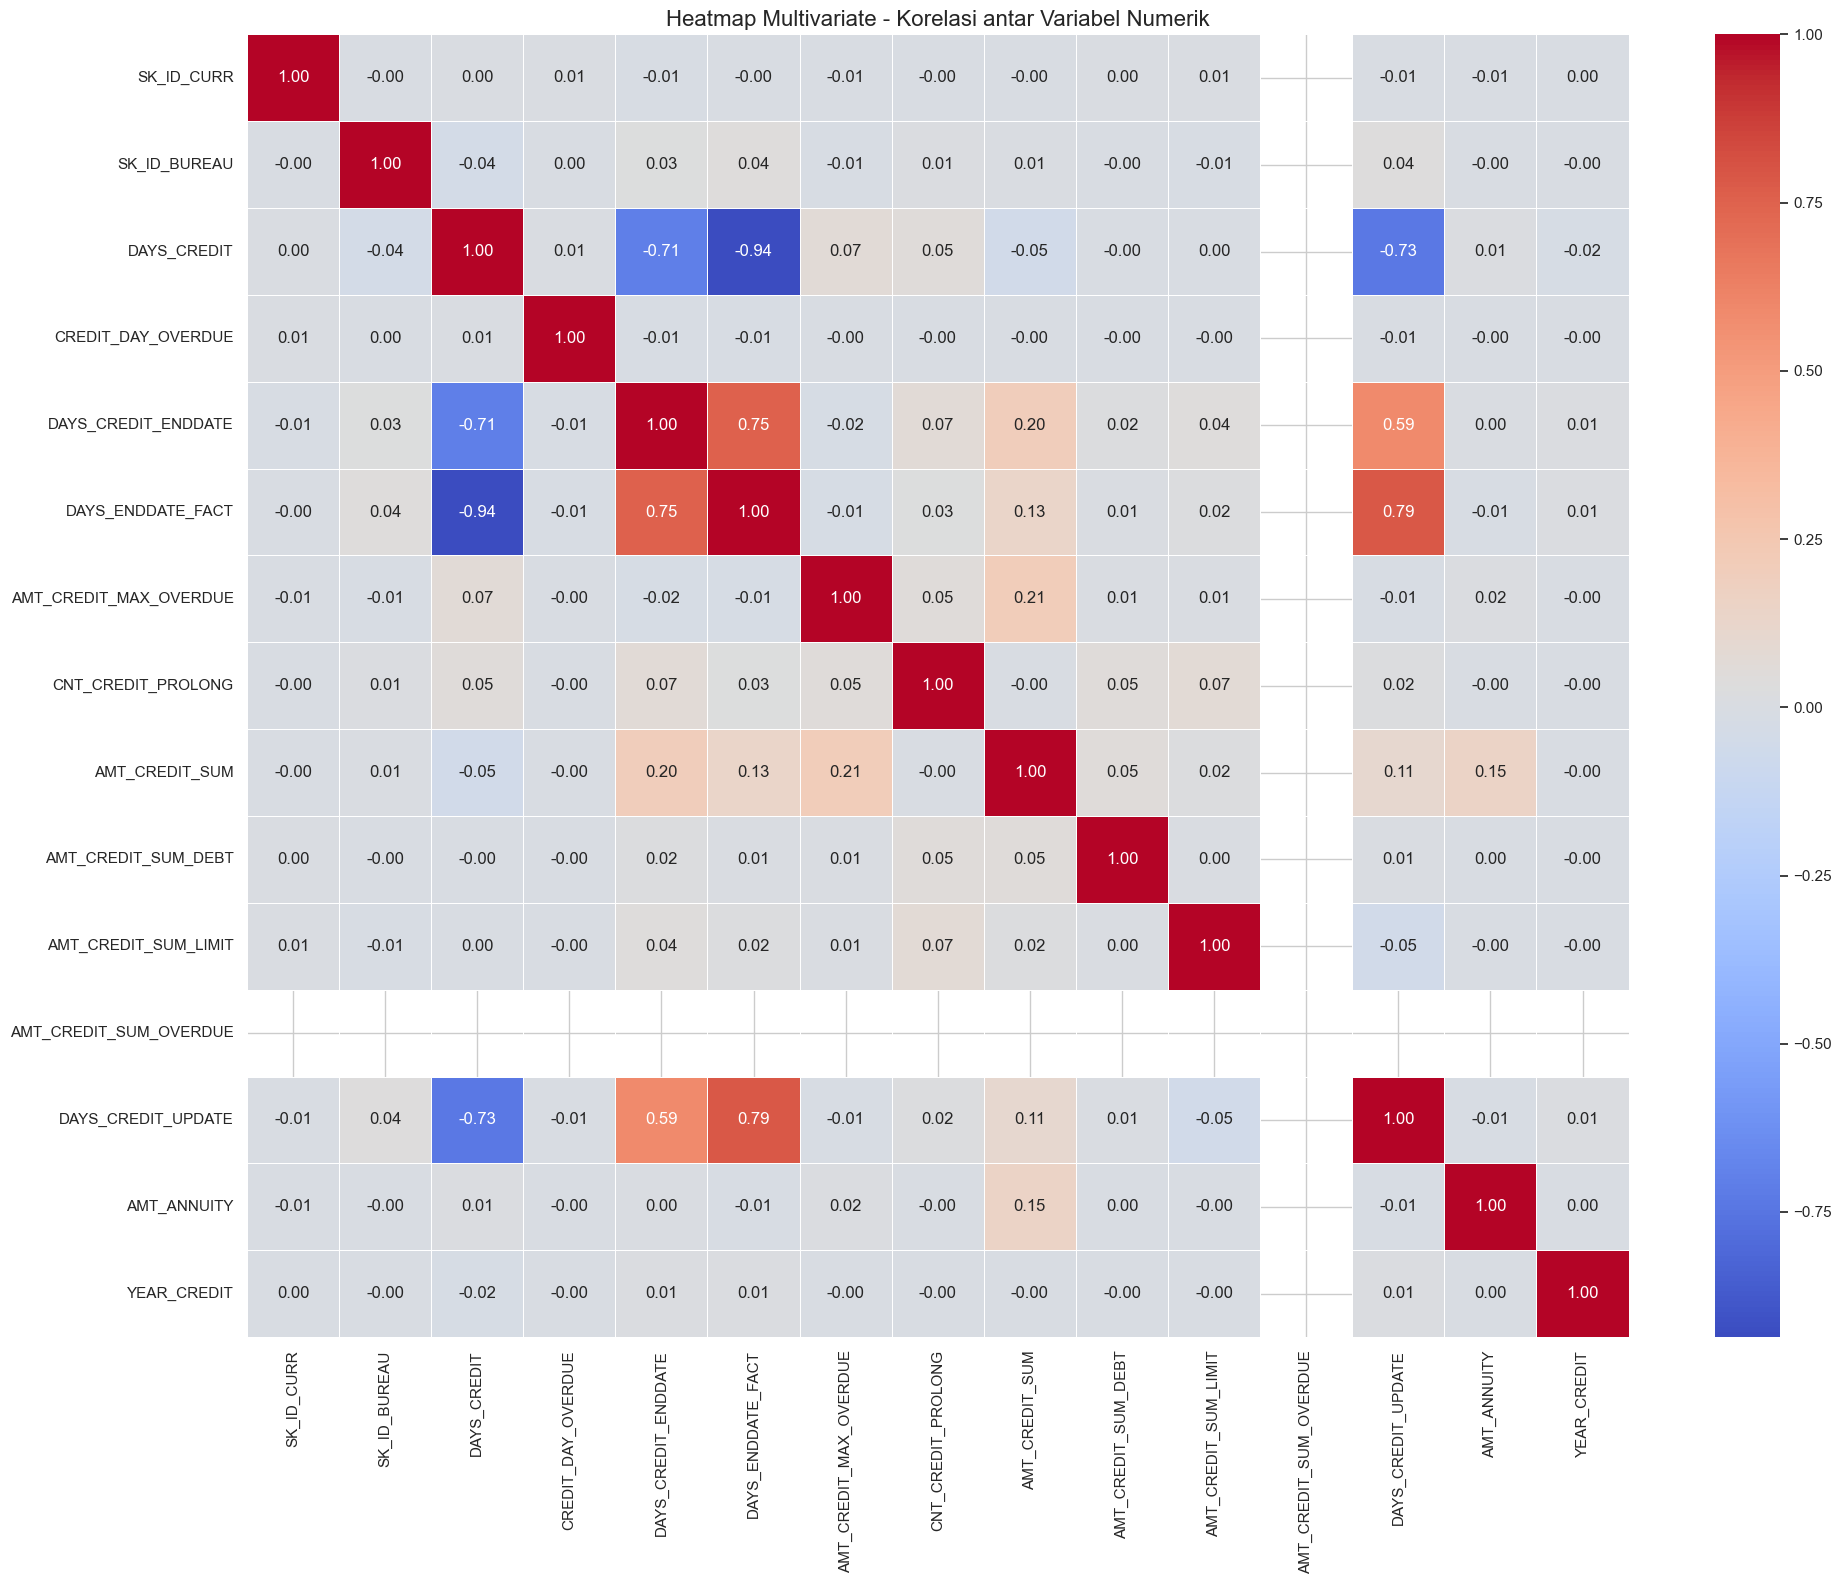

Top 10 Korelasi Tertinggi:
DAYS_ENDDATE_FACT       DAYS_CREDIT_UPDATE        0.787715
DAYS_CREDIT_UPDATE      DAYS_ENDDATE_FACT         0.787715
DAYS_CREDIT_ENDDATE     DAYS_ENDDATE_FACT         0.751312
DAYS_ENDDATE_FACT       DAYS_CREDIT_ENDDATE       0.751312
DAYS_CREDIT_ENDDATE     DAYS_CREDIT_UPDATE        0.588607
DAYS_CREDIT_UPDATE      DAYS_CREDIT_ENDDATE       0.588607
AMT_CREDIT_MAX_OVERDUE  AMT_CREDIT_SUM            0.208077
AMT_CREDIT_SUM          AMT_CREDIT_MAX_OVERDUE    0.208077
DAYS_CREDIT_ENDDATE     AMT_CREDIT_SUM            0.201869
AMT_CREDIT_SUM          DAYS_CREDIT_ENDDATE       0.201869
dtype: float64


In [ ]:
# Memilih kolom numerik
numeric_columns = bureau.select_dtypes(include=['int64', 'float64']).columns

# Menghitung korelasi
correlation_matrix = bureau[numeric_columns].corr()

# Membuat heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Heatmap Multivariate - Korelasi antar Variabel Numerik', fontsize=16)
plt.tight_layout()
plt.show()

# Menampilkan korelasi tertinggi (opsional)
print("Top 10 Korelasi Tertinggi:")
corr_unstack = correlation_matrix.unstack()
corr_unstack = corr_unstack.sort_values(kind="quicksort", ascending=False)
print(corr_unstack[corr_unstack < 1].head(10))

# Posh Cash Balance Dataset

In [ ]:
# Melihat beberapa baris pertama
print(posh_cash_balance.head())

# Melihat informasi kolom
print(posh_cash_balance.info())

# Melihat statistik deskriptif
print(posh_cash_balance.describe())

   SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1 

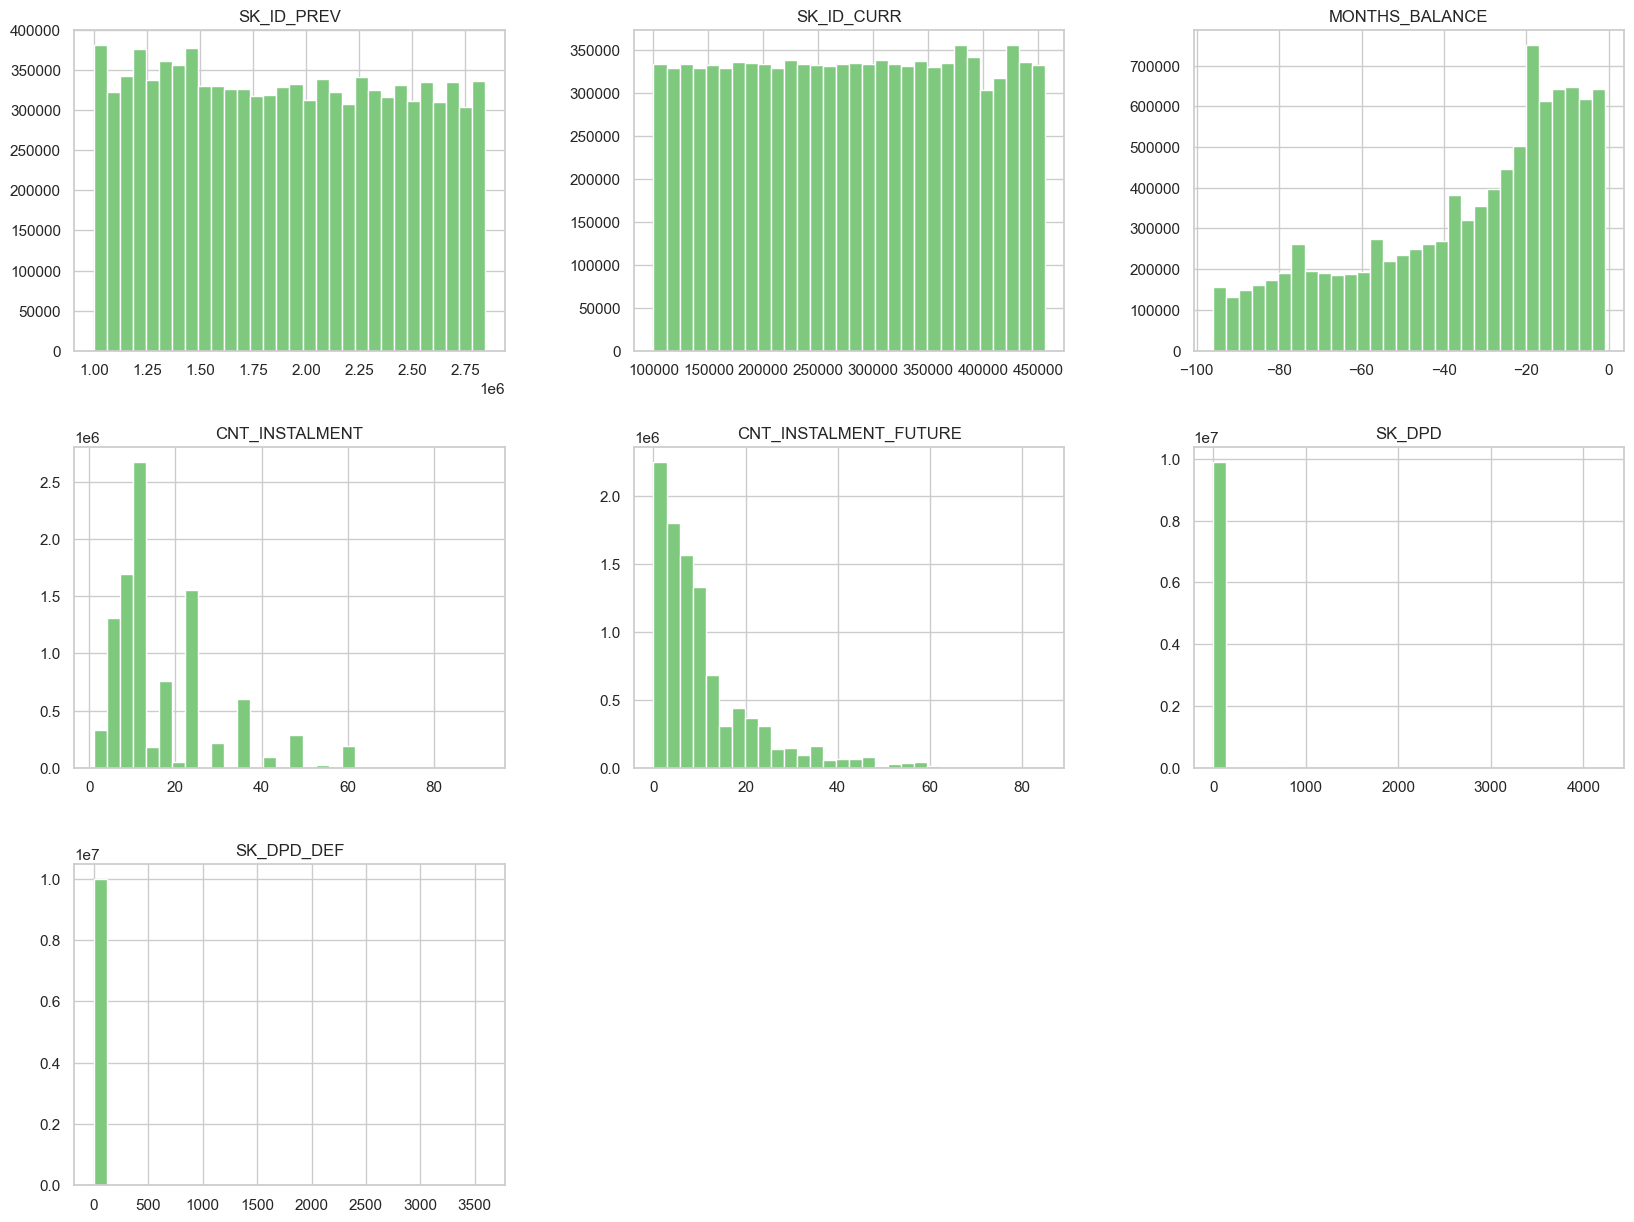

In [ ]:
# Histogram untuk setiap kolom numerik
posh_cash_balance.hist(bins=30, figsize=(20, 15))
plt.show()

NAME_CONTRACT_STATUS
Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: count, dtype: int64


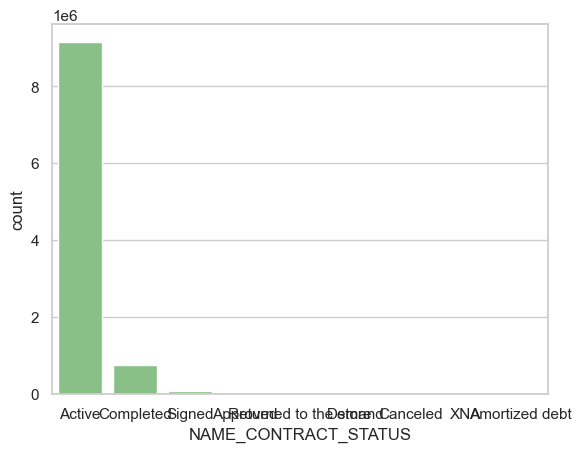

In [ ]:
# Distribusi kategori
print(posh_cash_balance['NAME_CONTRACT_STATUS'].value_counts())
sns.countplot(x='NAME_CONTRACT_STATUS', data=posh_cash_balance)
plt.show()

In [ ]:
# Distribusi status kontrak
contract_status = posh_cash_balance['NAME_CONTRACT_STATUS'].value_counts()
print(contract_status)

NAME_CONTRACT_STATUS
Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: count, dtype: int64


In [ ]:
# Rata-rata bulan pembayaran berdasarkan status kontrak
avg_months_balance = posh_cash_balance.groupby('NAME_CONTRACT_STATUS')['MONTHS_BALANCE'].mean()
print(avg_months_balance)

NAME_CONTRACT_STATUS
Active                  -35.184489
Amortized debt          -22.102201
Approved                -25.716087
Canceled                -18.533333
Completed               -32.537519
Demand                  -33.654494
Returned to the store   -37.327046
Signed                  -38.699221
XNA                     -22.500000
Name: MONTHS_BALANCE, dtype: float64


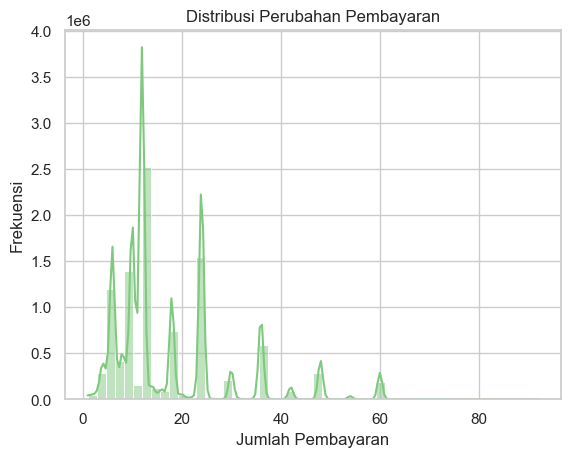

In [ ]:
# Distribusi perubahan pembayaran
sns.histplot(posh_cash_balance['CNT_INSTALMENT'], bins=50, kde=True)
plt.title('Distribusi Perubahan Pembayaran')
plt.xlabel('Jumlah Pembayaran')
plt.ylabel('Frekuensi')
plt.show()

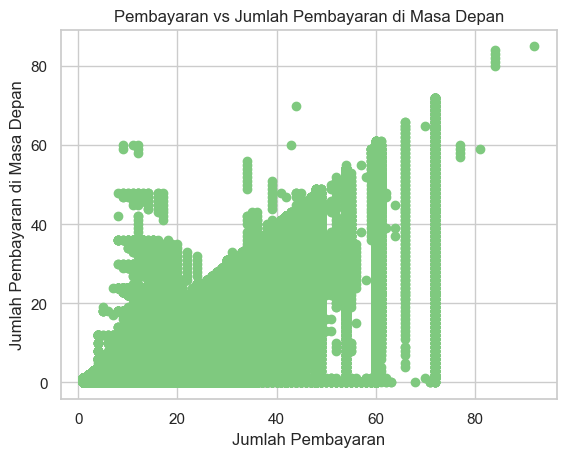

In [ ]:
# Scatter plot antara pembayaran dan jumlah pembayaran
plt.scatter(posh_cash_balance['CNT_INSTALMENT'], posh_cash_balance['CNT_INSTALMENT_FUTURE'])
plt.title('Pembayaran vs Jumlah Pembayaran di Masa Depan')
plt.xlabel('Jumlah Pembayaran')
plt.ylabel('Jumlah Pembayaran di Masa Depan')
plt.show()

In [ ]:
# Analisis risiko pembayaran terlambat
late_payments = posh_cash_balance[posh_cash_balance['SK_DPD'] > 0]
print(late_payments.describe())

         SK_ID_PREV     SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
count  2.952270e+05  295227.000000   295227.000000   295227.000000   
mean   1.903304e+06  279723.201923      -51.127536       12.812971   
std    5.349025e+05  102321.017736       25.644137        8.731599   
min    1.000053e+06  100001.000000      -96.000000        1.000000   
25%    1.434748e+06  191907.000000      -72.000000        8.000000   
50%    1.894589e+06  279523.000000      -54.000000       10.000000   
75%    2.369311e+06  368297.000000      -30.000000       12.000000   
max    2.843490e+06  456255.000000       -1.000000       72.000000   

       CNT_INSTALMENT_FUTURE         SK_DPD     SK_DPD_DEF  
count          295227.000000  295227.000000  295227.000000  
mean                4.102209     393.206058      22.171322  
std                 7.338072     668.302135     189.435505  
min                 0.000000       1.000000       0.000000  
25%                 0.000000       5.000000       0.000000  
50%

## Handling Null Value

In [ ]:
# Mengidentifikasi jumlah nilai null di setiap kolom
null_counts = posh_cash_balance.isnull().sum()

# Menampilkan jumlah nilai null di setiap kolom
print(null_counts)

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64


In [ ]:
# Menghapus baris yang memiliki nilai null
posh_cash_balance_dropped_rows = posh_cash_balance.dropna()

# Memeriksa kembali jumlah nilai null
print(posh_cash_balance_dropped_rows.isnull().sum())

SK_ID_PREV               0
SK_ID_CURR               0
MONTHS_BALANCE           0
CNT_INSTALMENT           0
CNT_INSTALMENT_FUTURE    0
NAME_CONTRACT_STATUS     0
SK_DPD                   0
SK_DPD_DEF               0
dtype: int64


In [ ]:
# Menghapus baris yang mengandung nilai null
posh_cash_balance_dropped_rows = posh_cash_balance.dropna()

# Menghapus kolom yang mengandung nilai null
posh_cash_balance_dropped_columns = posh_cash_balance.dropna(axis=1)


Handling Duplicate

In [ ]:
# Mengidentifikasi baris yang duplikat
duplicates = posh_cash_balance.duplicated()

# Menampilkan baris yang duplikat
print(posh_cash_balance[duplicates])

# Menampilkan jumlah baris yang duplikat
print(f"Jumlah baris duplikat: {duplicates.sum()}")

Empty DataFrame
Columns: [SK_ID_PREV, SK_ID_CURR, MONTHS_BALANCE, CNT_INSTALMENT, CNT_INSTALMENT_FUTURE, NAME_CONTRACT_STATUS, SK_DPD, SK_DPD_DEF]
Index: []
Jumlah baris duplikat: 0


In [ ]:
# Menghapus baris yang duplikat
posh_cash_balance_no_duplicates = posh_cash_balance.drop_duplicates()

# Memeriksa kembali apakah ada duplikasi
print(posh_cash_balance_no_duplicates.duplicated().sum())

0


Handling Outliers

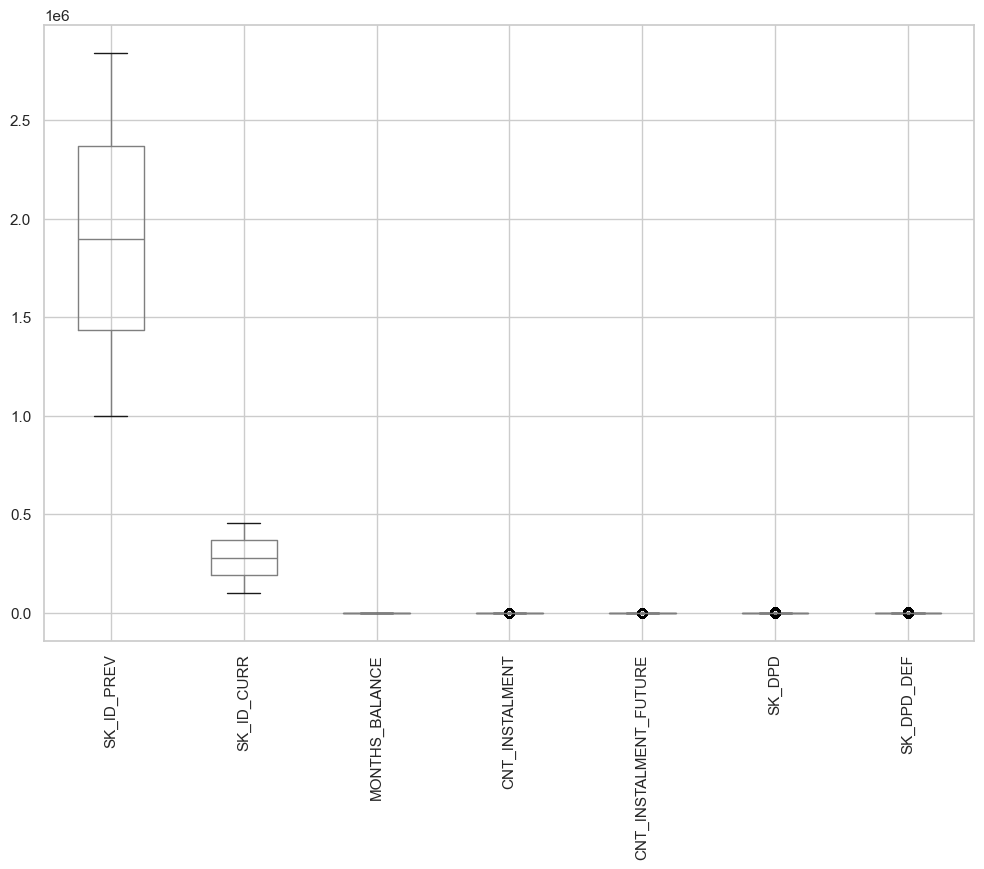

In [ ]:


# Membuat box plot untuk setiap kolom numerik
posh_cash_balance.boxplot(figsize=(12, 8))
plt.xticks(rotation=90)
plt.show()

In [ ]:
from scipy import stats

# Menghitung z-score
z_scores = stats.zscore(posh_cash_balance.select_dtypes(include=['float64', 'int64']))

# Menentukan threshold untuk z-score
threshold = 3

# Mengidentifikasi outliers
outliers = (abs(z_scores) > threshold).any(axis=1)

# Menampilkan outliers
print(posh_cash_balance[outliers])

          SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
2252         2562793      287880             -46             7.0   
5234         1526249      275666             -39            12.0   
5787         1473810      167948             -40            12.0   
5788         2749600      365698             -35            12.0   
6692         1526249      275666             -32            12.0   
...              ...         ...             ...             ...   
10001352     2700641      448867             -19             6.0   
10001353     2448283      226558             -20             6.0   
10001354     1717234      141565             -19            12.0   
10001355     1283126      315695             -21            10.0   
10001356     1082516      450255             -22            12.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
2252                        0.0               Active    1105           0  
5234                        0.0  

In [ ]:
# Menghapus outliers
posh_cash_balance_no_outliers = posh_cash_balance[~outliers]

# Menampilkan dataset tanpa outliers
print(posh_cash_balance_no_outliers)


          SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0            1803195      182943             -31            48.0   
1            1715348      367990             -33            36.0   
2            1784872      397406             -32            12.0   
3            1903291      269225             -35            48.0   
4            2341044      334279             -35            36.0   
...              ...         ...             ...             ...   
10001343     1816071      383432             -23             6.0   
10001345     1773550      412155             -18             6.0   
10001347     1522999      385297             -21            12.0   
10001350     2593362      198894             -20            12.0   
10001357     1259607      174278             -52            16.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                          45.0               Active       0           0  
1                          35.0  

Statistics Descriptive

In [ ]:
# Mendapatkan statistik deskriptif untuk semua kolom
descriptive_stats_all = posh_cash_balance.describe(include='all')

# Menampilkan statistik deskriptif untuk semua kolom
print(descriptive_stats_all)

          SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
count   1.000136e+07  1.000136e+07    1.000136e+07    9.975287e+06   
unique           NaN           NaN             NaN             NaN   
top              NaN           NaN             NaN             NaN   
freq             NaN           NaN             NaN             NaN   
mean    1.903217e+06  2.784039e+05   -3.501259e+01    1.708965e+01   
std     5.358465e+05  1.027637e+05    2.606657e+01    1.199506e+01   
min     1.000001e+06  1.000010e+05   -9.600000e+01    1.000000e+00   
25%     1.434405e+06  1.895500e+05   -5.400000e+01    1.000000e+01   
50%     1.896565e+06  2.786540e+05   -2.800000e+01    1.200000e+01   
75%     2.368963e+06  3.674290e+05   -1.300000e+01    2.400000e+01   
max     2.843499e+06  4.562550e+05   -1.000000e+00    9.200000e+01   

        CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS        SK_DPD    SK_DPD_DEF  
count            9.975271e+06             10001358  1.000136e+07  1.000136e+07

Grafik ini menunjukan tren saldo kas tersedia di Pos Over Time.Grafik ini menunjukan bahwa saldo kas telah meningkat secara signifikan pada hari-hari tertentu,dan telah menurun pada hari-hari lainya.terdapat pola musiman dalam data ,dengan saldo kas cenderung meningkat pada akhir bulan dan menurun pada awak bulan.

# Credit Card Balance

In [ ]:
ccb.sample(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
2807455     2200089      228063             -26   288459.495   
783382      2127596      348427             -13        0.000   
1355957     1465522      129728             -17        0.000   
3674298     1886693      296656             -54        0.000   
1069908     1721244      247551              -8    45612.405   

         AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
2807455                   270000                    1800.0   
783382                    180000                       0.0   
1355957                        0                       0.0   
3674298                        0                       0.0   
1069908                    45000                       0.0   

         AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
2807455                1800.0                         0.0   
783382                    0.0                         0.0   
1355957                   0.0                         0.0   
3674298                   0.0                         0.0   
1069908                4292.1                         0.0   

         AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  \
2807455                       0.0                  13500.0  ...   
783382                        0.0                      0.0  ...   
1355957                       0.0                      0.0  ...   
3674298                       0.0                      0.0  ...   
1069908                    4292.1                      0.0  ...   

         AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  \
2807455     286218.495            286218.495                       2.0   
783382           0.000                 0.000                       0.0   
1355957          0.000                 0.000                       0.0   
3674298          0.000                 0.000                       0.0   
1069908      44821.800             44821.800                       0.0   

         CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
2807455                     2                         0.0   
783382                      0                         0.0   
1355957                     0                         0.0   
3674298                     0                         0.0   
1069908                     5                         0.0   

         CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  \
2807455                       0.0                        9.0   
783382                        0.0                       69.0   
1355957                       0.0                        4.0   
3674298                       0.0                        5.0   
1069908                       5.0                        0.0   

         NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
2807455                Active       0           0  
783382                 Active       0           0  
1355957                Active       0           0  
3674298                Active       0           0  
1069908                Active       0           0  

[5 rows x 23 columns]

In [ ]:
ccb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [ ]:
ccb.describe()

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE   AMT_BALANCE  \
count  3.840312e+06  3.840312e+06    3.840312e+06  3.840312e+06   
mean   1.904504e+06  2.783242e+05   -3.452192e+01  5.830016e+04   
std    5.364695e+05  1.027045e+05    2.666775e+01  1.063070e+05   
min    1.000018e+06  1.000060e+05   -9.600000e+01 -4.202502e+05   
25%    1.434385e+06  1.895170e+05   -5.500000e+01  0.000000e+00   
50%    1.897122e+06  2.783960e+05   -2.800000e+01  0.000000e+00   
75%    2.369328e+06  3.675800e+05   -1.100000e+01  8.904669e+04   
max    2.843496e+06  4.562500e+05   -1.000000e+00  1.505902e+06   

       AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
count             3.840312e+06              3.090496e+06   
mean              1.538080e+05              5.961325e+03   
std               1.651457e+05              2.822569e+04   
min               0.000000e+00             -6.827310e+03   
25%               4.500000e+04              0.000000e+00   
50%               1.125000e+05              0.000000e+00   
75%               1.800000e+05              0.000000e+00   
max               1.350000e+06              2.115000e+06   

       AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
count          3.840312e+06                3.090496e+06   
mean           7.433388e+03                2.881696e+02   
std            3.384608e+04                8.201989e+03   
min           -6.211620e+03                0.000000e+00   
25%            0.000000e+00                0.000000e+00   
50%            0.000000e+00                0.000000e+00   
75%            0.000000e+00                0.000000e+00   
max            2.287098e+06                1.529847e+06   

       AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  \
count              3.090496e+06             3.535076e+06  ...   
mean               2.968805e+03             3.540204e+03  ...   
std                2.079689e+04             5.600154e+03  ...   
min                0.000000e+00             0.000000e+00  ...   
25%                0.000000e+00             0.000000e+00  ...   
50%                0.000000e+00             0.000000e+00  ...   
75%                0.000000e+00             6.633911e+03  ...   
max                2.239274e+06             2.028820e+05  ...   

       AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
count              3.840312e+06   3.840312e+06          3.840312e+06   
mean               5.596588e+04   5.808881e+04          5.809829e+04   
std                1.025336e+05   1.059654e+05          1.059718e+05   
min               -4.233058e+05  -4.202502e+05         -4.202502e+05   
25%                0.000000e+00   0.000000e+00          0.000000e+00   
50%                0.000000e+00   0.000000e+00          0.000000e+00   
75%                8.535924e+04   8.889949e+04          8.891451e+04   
max                1.472317e+06   1.493338e+06          1.493338e+06   

       CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count              3.090496e+06          3.840312e+06   
mean               3.094490e-01          7.031439e-01   
std                1.100401e+00          3.190347e+00   
min                0.000000e+00          0.000000e+00   
25%                0.000000e+00          0.000000e+00   
50%                0.000000e+00          0.000000e+00   
75%                0.000000e+00          0.000000e+00   
max                5.100000e+01          1.650000e+02   

       CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
count                3.090496e+06              3.090496e+06   
mean                 4.812496e-03              5.594791e-01   
std                  8.263861e-02              3.240649e+00   
min                  0.000000e+00              0.000000e+00   
25%                  0.000000e+00              0.000000e+00   
50%                  0.000000e+00              0.000000e+00   
75%                  0.000000e+00              0.000000e+00   
max                  1.200000e+01              1.650000e+02   

       CNT_INST

In [ ]:
ccb['AMT_BALANCE'].sort_values()

2132913    -420250.185
429463     -261471.015
3714021    -259848.945
3792936    -240305.985
1713554    -223224.210
              ...     
1857769    1329264.630
3810379    1347979.500
1059989    1354613.265
3044117    1354829.265
961174     1505902.185
Name: AMT_BALANCE, Length: 3840312, dtype: float64

In [ ]:
ccb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [ ]:
# Memisahkan fitur numerikal
num = ccb.select_dtypes(include=['int64', 'float64'])

# Memisahkan fitur kategorikal
cat = ccb.select_dtypes(include=['object', 'category'])


## HANDLING DUPLICATE

In [ ]:
# memeriksa duplicate
ccb.duplicated().sum()

0

## HANDLING NULL VALUE

In [ ]:
# Memeriksa missing value atau Null (dalam %)
missing_features = ccb.isna().mean().round(3).mul(100)
missing_features[missing_features > 0]

AMT_DRAWINGS_ATM_CURRENT      19.5
AMT_DRAWINGS_OTHER_CURRENT    19.5
AMT_DRAWINGS_POS_CURRENT      19.5
AMT_INST_MIN_REGULARITY        7.9
AMT_PAYMENT_CURRENT           20.0
CNT_DRAWINGS_ATM_CURRENT      19.5
CNT_DRAWINGS_OTHER_CURRENT    19.5
CNT_DRAWINGS_POS_CURRENT      19.5
CNT_INSTALMENT_MATURE_CUM      7.9
dtype: float64

In [ ]:
num.fillna(num.median(), inplace=True)

In [ ]:
num.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  \
0                 1700.325  ...                     0.000          0.000   
1                 2250.000  ...                 60175.080      64875.555   
2                 2250.000  ...                 26926.425      31460.085   
3                11795.760  ...                224949.285     233048.970   
4                22924.890  ...                443044.395     453919.455   

   AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
0                 0.000                       0.0                     1   
1             64875.555                       1.0                     1   
2             31460.085                       0.0                     0   
3            233048.970                       1.0                     1   
4            453919.455                       0.0                     1   

   CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
0                         0.0                       1.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                       1.0   

   CNT_INSTALMENT_MATURE_CUM  SK_DPD  SK_DPD_DEF  
0                       35.0       0           0  
1                       69.0       0           0  
2                       30.0       0           0  
3                       10.0       0           0  
4                      101.0       0           0  

[5 rows x 22 columns]

## MULTIVARIATE ANALYSIS

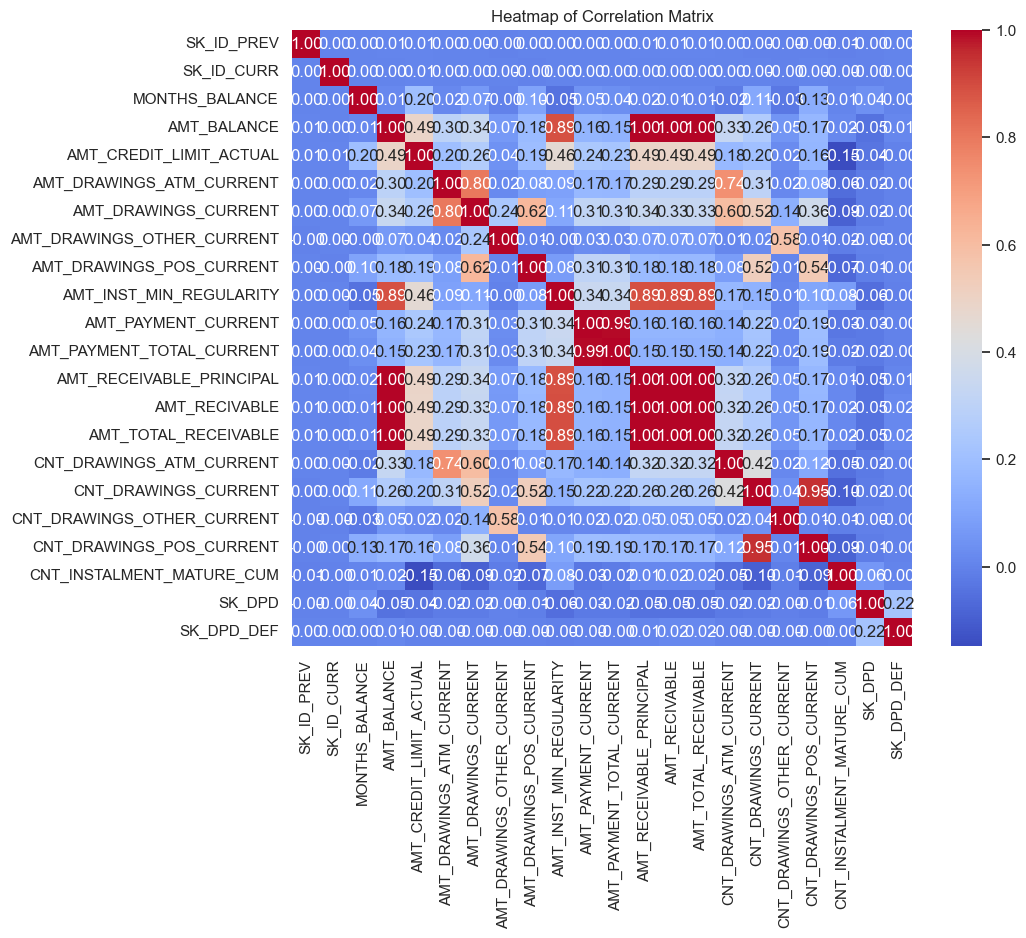

In [ ]:
korelasi = num.corr()
# Membuat heatmap
plt.figure(figsize=(10, 8))  # Menentukan ukuran figure
sns.heatmap(korelasi, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [ ]:
# Membuat dataset baru berdasarkan analysis manual
selected_columns = ['SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_PAYMENT_CURRENT','AMT_PAYMENT_TOTAL_CURRENT','AMT_DRAWINGS_ATM_CURRENT','AMT_DRAWINGS_OTHER_CURRENT','SK_DPD','SK_DPD_DEF']
new_d = num[selected_columns]
# Menampilkan dataset baru
print(new_d)

         SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  AMT_PAYMENT_CURRENT  \
0            378907              -6       56.970              1800.00   
1            363914              -1    63975.555              2250.00   
2            371185              -7    31815.225              2250.00   
3            337855              -4   236572.110             11925.00   
4            126868              -1   453919.455             27000.00   
...             ...             ...          ...                  ...   
3840307      328243              -9        0.000              2702.70   
3840308      347207              -9        0.000              1879.11   
3840309      215757              -9   275784.975            375750.00   
3840310      430337             -10        0.000              2702.70   
3840311      236760             -10        0.000                 0.00   

         AMT_PAYMENT_TOTAL_CURRENT  AMT_DRAWINGS_ATM_CURRENT  \
0                         1800.000                       0.

## UNIVARIATE ANALYSIS

## SK_DPD, SK_DPD_DEF

Fitur-fitur ini secara langsung menunjukkan riwayat keterlambatan pembayaran nasabah. Ini adalah indikator yang sangat kuat untuk memprediksi gagal bayar di masa depan

### Membuat pie chart proporsi customer yang default vs tidak

In [ ]:
new_d['SK_DPD_DEF']

0          0
1          0
2          0
3          0
4          0
          ..
3840307    0
3840308    0
3840309    0
3840310    0
3840311    0
Name: SK_DPD_DEF, Length: 3840312, dtype: int64

In [ ]:
# Membuat fitur baru dengan nama 'flag_default'
new_d.loc[:, 'flag_default'] = np.where(new_d['SK_DPD_DEF'] > 0, 1, 0)

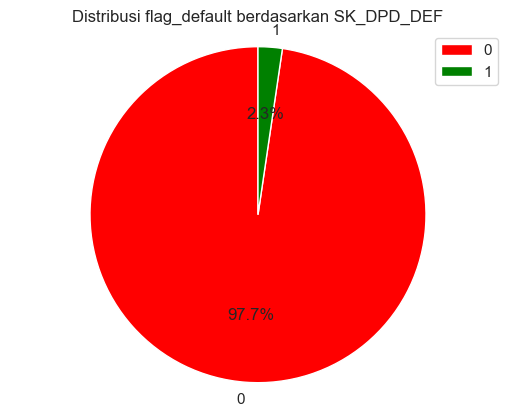

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'flag_default' has values 0 (capable) and 1 (non capable)
data_to_plot = new_d['flag_default'].value_counts()
colors = ['red', 'green']  # Define colors for non-capable and capable

# Create pie chart with custom colors
plt.pie(data_to_plot, labels=data_to_plot.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Add title and legend (optional)
plt.title('Distribusi flag_default berdasarkan SK_DPD_DEF')
plt.legend(data_to_plot.index, loc="best")  # Legend with labels and colors
plt.axis('equal')
plt.show()

In [ ]:
# Membuat fitur baru dengan nama 'flag_default'
new_d.loc[:, 'flag_default_1'] = np.where(new_d['SK_DPD'] > 0, 1, 0)

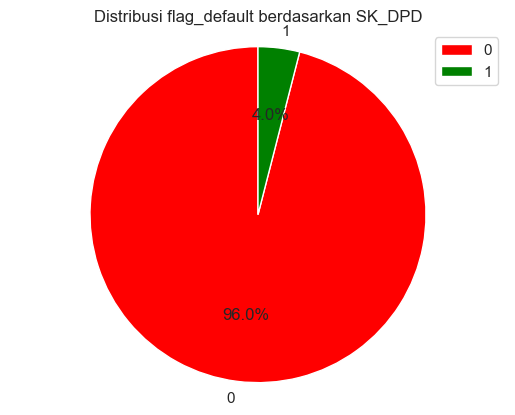

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'flag_default' has values 0 (capable) and 1 (non capable)
data_to_plot = new_d['flag_default_1'].value_counts()
colors = ['red', 'green']  # Define colors for non-capable and capable

# Create pie chart with custom colors
plt.pie(data_to_plot, labels=data_to_plot.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Add title and legend (optional)
plt.title('Distribusi flag_default berdasarkan SK_DPD')
plt.legend(data_to_plot.index, loc="best")  # Legend with labels and colors
plt.axis('equal')
plt.show()

In [ ]:
# Membuat fitur baru dengan nama 'flag_default'
new_d.loc[:, 'flag_default_2'] = np.where(new_d['flag_default'] + new_d['flag_default_1'] > 1, 1, 0)

### AMT_BALANCE 

In [ ]:
# Menambahkan kolom yang menunjukkan apakah pelanggan capable atau tidak
new_d['capability'] = new_d['flag_default'].map({0: 'Capable', 1: 'Tidak capable'})

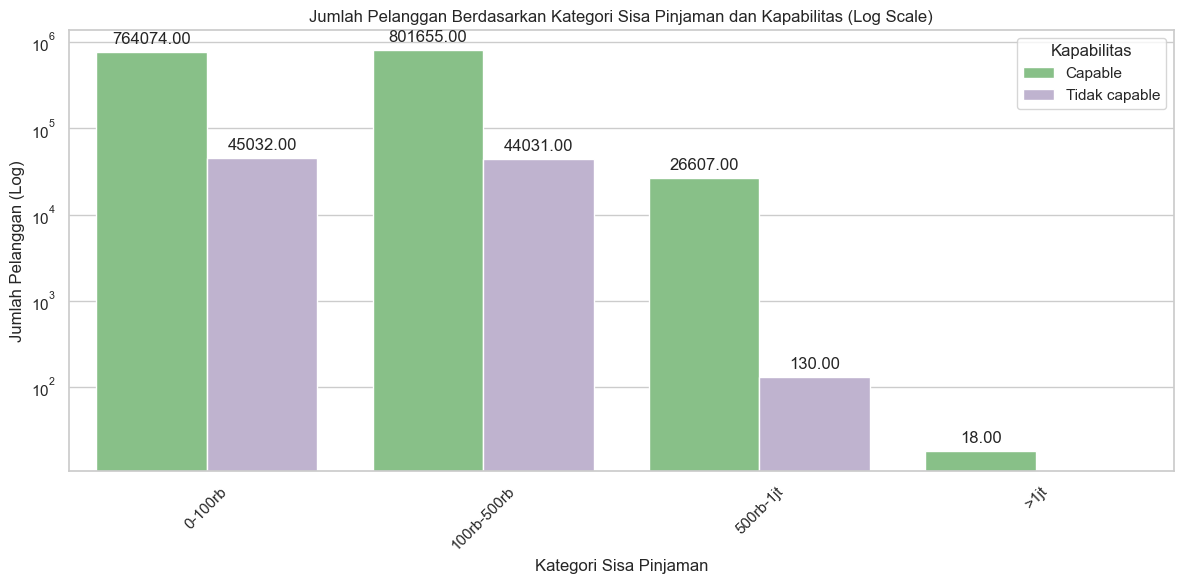

In [ ]:

# Mengelompokkan data berdasarkan AMT_BALANCE dan capability
sisa_count = new_d.groupby(['AMT_BALANCE', 'capability']).size().reset_index(name='count')

# Membuat kategori untuk AMT_BALANCE
sisa_count['sisa_pinjaman_kategori'] = pd.cut(sisa_count['AMT_BALANCE'],
                                               bins=[0, 100000, 500000, 1000000, float('inf')],
                                               labels=['0-100rb', '100rb-500rb', '500rb-1jt', '>1jt'])

# Mengelompokkan data berdasarkan kategori sisa pinjaman dan capability
sisa_pinjaman_kategori_count = sisa_count.groupby(['sisa_pinjaman_kategori', 'capability']).agg({'count': 'sum'}).reset_index()

# Membuat barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=sisa_pinjaman_kategori_count, x='sisa_pinjaman_kategori', y='count', hue='capability')

# Menggunakan skala logaritmik pada sumbu Y
plt.yscale('log')

# Menambahkan anotasi nilai pada setiap bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), textcoords = 'offset points')

# Label dan judul
plt.title('Jumlah Pelanggan Berdasarkan Kategori Sisa Pinjaman dan Kapabilitas (Log Scale)')
plt.xlabel('Kategori Sisa Pinjaman')
plt.ylabel('Jumlah Pelanggan (Log)')
plt.legend(title='Kapabilitas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
sisa_pinjaman_kategori_count

sisa_pinjaman_kategori     capability   count
0                0-100rb        Capable  764074
1                0-100rb  Tidak capable   45032
2            100rb-500rb        Capable  801655
3            100rb-500rb  Tidak capable   44031
4              500rb-1jt        Capable   26607
5              500rb-1jt  Tidak capable     130
6                   >1jt        Capable      18
7                   >1jt  Tidak capable       0

# Installment

In [ ]:
ip.sample(5)

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
6925210      2162867      282524                     0.0   
10267735     1973220      333279                     1.0   
6297917      2115708      262039                     2.0   
10359567     1141297      326999                     1.0   
7433868      1056713      279339                     1.0   

          NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
6925210                      11          -1100.0             -1094.0   
10267735                      7          -2074.0             -2091.0   
6297917                       7          -1989.0             -2012.0   
10359567                      8           -282.0              -309.0   
7433868                      11           -207.0              -217.0   

          AMT_INSTALMENT  AMT_PAYMENT  
6925210         4622.220     4622.220  
10267735        7714.080     7714.080  
6297917        23757.345    23757.345  
10359567       41144.580      185.940  
7433868         6818.265     6818.265

In [ ]:
# Checking values in every features
for i in ip.columns:
    print(f"{[i]} \n {ip[i].unique()} \n")

['SK_ID_PREV'] 
 [1054186 1330831 2085231 ... 1984920 1946334 1276288] 

['SK_ID_CURR'] 
 [161674 151639 193053 ... 413433 434445 405063] 

['NUM_INSTALMENT_VERSION'] 
 [  1.   0.   2.   4.   3.   5.   7.   8.   6.  13.   9.  21.  22.  12.
  17.  18.  11.  14.  34.  33.  19.  16.  15.  10.  26.  27.  20.  25.
  23.  24.  31.  32.  28.  35.  29.  30.  43.  39.  40.  36.  41.  42.
  37.  38.  68.  44.  45.  46. 178.  52.  51.  53.  54.  49.  50.  58.
  57.  55.  56.  48.  47.  72.  59.  73.  61.] 

['NUM_INSTALMENT_NUMBER'] 
 [  6  34   1   3   2  12  11   4  14   8  20  56   7  23  38 116   5  46
 106   9 105  88  30  16  65  19  15  57  10  41  84  49  59 107  17  94
  64  28  24 140  43  99  69  13  22  85  29  83  73 139  39  18  26  25
  21  44  27  31  37  63  45  78  53  92 112  36  93 114  58  32  67  47
  68  40  81  61 117  60  75 149  35  48  82  79  71  51  72  80 156  42
  50 148  33  55 103  54 180  86 113  87  62 102 115 142 164 162 101  91
  96 100 104 121  66 123  52  89

In [ ]:
ip['default'] = ip['DAYS_INSTALMENT'] + ip['DAYS_ENTRY_PAYMENT']

In [ ]:
ip.sort_values(by='default', ascending=False)

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
9270043      1079838      309667                     0.0   
13545386     1887853      410746                     0.0   
3101602      2745943      119913                     0.0   
5916734      1389738      241858                     1.0   
9540684      1184849      349145                     0.0   
...              ...         ...                     ...   
13605396     2186857      428057                     0.0   
13605397     1310347      414406                     0.0   
13605398     1308766      402199                     0.0   
13605399     1062206      409297                     0.0   
13605400     2448869      434321                     1.0   

          NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
9270043                      31             -1.0                -1.0   
13545386                     53             -1.0                -1.0   
3101602                      11             -2.0                -2.0   
5916734                      17             -2.0                -2.0   
9540684                      27             -2.0                -2.0   
...                         ...              ...                 ...   
13605396                     66          -1624.0                 NaN   
13605397                     47          -1539.0                 NaN   
13605398                     43             -7.0                 NaN   
13605399                     43          -1986.0                 NaN   
13605400                     19            -27.0                 NaN   

          AMT_INSTALMENT  AMT_PAYMENT  default  
9270043        65835.000    65835.000     -2.0  
13545386       11250.000    11250.000     -2.0  
3101602          327.735      327.735     -4.0  
5916734        13972.860    13972.860     -4.0  
9540684          333.000      333.000     -4.0  
...                  ...          ...      ...  
13605396          67.500          NaN      NaN  
13605397          67.500          NaN      NaN  
13605398       43737.435          NaN      NaN  
13605399          67.500          NaN      NaN  
13605400       11504.250          NaN      NaN  

[13605401 rows x 9 columns]

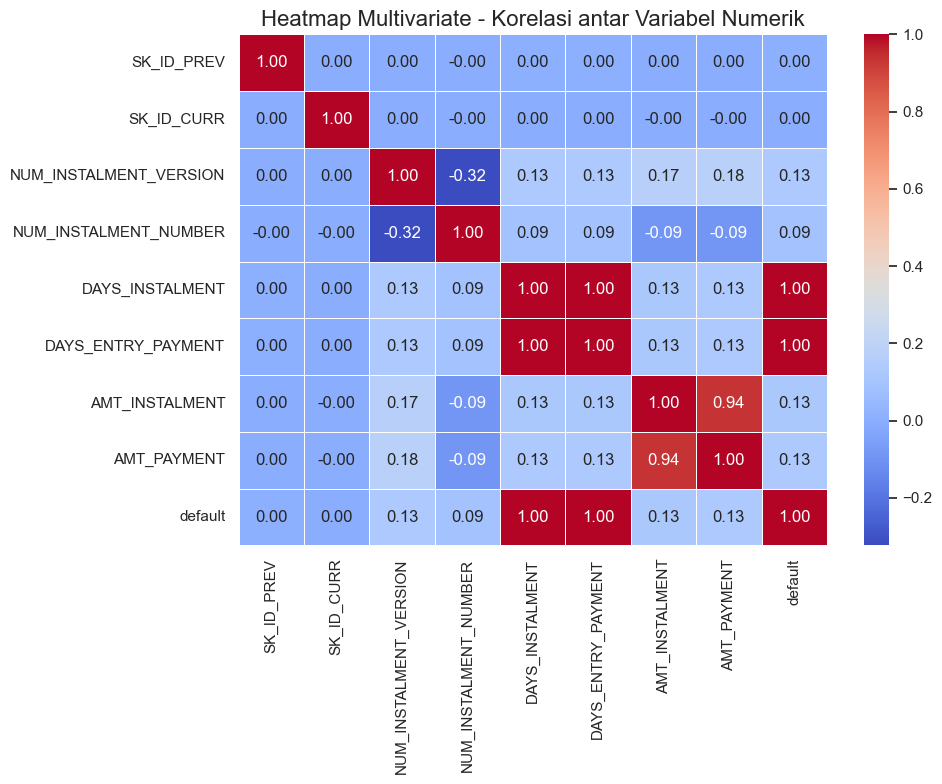

Top 10 Korelasi Tertinggi:
default                 DAYS_INSTALMENT           0.999873
DAYS_INSTALMENT         default                   0.999873
default                 DAYS_ENTRY_PAYMENT        0.999873
DAYS_ENTRY_PAYMENT      default                   0.999873
                        DAYS_INSTALMENT           0.999491
DAYS_INSTALMENT         DAYS_ENTRY_PAYMENT        0.999491
AMT_INSTALMENT          AMT_PAYMENT               0.937191
AMT_PAYMENT             AMT_INSTALMENT            0.937191
                        NUM_INSTALMENT_VERSION    0.177176
NUM_INSTALMENT_VERSION  AMT_PAYMENT               0.177176
dtype: float64


In [ ]:
# Memilih kolom numerik
numeric_columns = ip.select_dtypes(include=['int64', 'float64']).columns

# Menghitung korelasi
correlation_matrix = ip[numeric_columns].corr()

# Membuat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Heatmap Multivariate - Korelasi antar Variabel Numerik', fontsize=16)
plt.tight_layout()
plt.show()

# Menampilkan korelasi tertinggi (opsional)
print("Top 10 Korelasi Tertinggi:")
corr_unstack = correlation_matrix.unstack()
corr_unstack = corr_unstack.sort_values(kind="quicksort", ascending=False)
print(corr_unstack[corr_unstack < 1].head(10))

Berdasarkan heatmap korelasi antar variabel numerik yang ditampilkan, berikut adalah beberapa observasi penting:
1. Korelasi Sempurna (1.00):
- DAYS_INSTALMENT, DAYS_ENTRY_PAYMENT, dan default memiliki korelasi sempurna positif (1.00). Ini menunjukkan bahwa ketiga variabel ini sangat terkait erat dan mungkin memberikan informasi yang redundan.
- AMT_INSTALMENT dan AMT_PAYMENT memiliki korelasi sangat tinggi (0.94), menunjukkan hubungan yang sangat kuat antara jumlah cicilan dan jumlah pembayaran.


2. Korelasi Moderat:
- NUM_INSTALMENT_VERSION dan NUM_INSTALMENT_NUMBER memiliki korelasi negatif moderat (-0.32), menunjukkan bahwa semakin tinggi versi cicilan, semakin rendah jumlah cicilan, atau sebaliknya.

3. Korelasi Rendah:
- NUM_INSTALMENT_VERSION memiliki korelasi positif rendah dengan AMT_INSTALMENT (0.17) dan AMT_PAYMENT (0.18), menunjukkan sedikit hubungan antara versi cicilan dan jumlah pembayaran.

4. Tidak Ada Korelasi:
- SK_ID_PREV dan SK_ID_CURR tidak memiliki korelasi yang signifikan dengan variabel lain, menunjukkan bahwa ID-ID ini mungkin hanya berfungsi sebagai pengidentifikasi unik dan tidak mempengaruhi variabel lainnya.

5. Korelasi dengan Default:
Variabel 'default' memiliki korelasi sempurna dengan DAYS_INSTALMENT dan DAYS_ENTRY_PAYMENT, menunjukkan bahwa status default sangat terkait dengan waktu pembayaran cicilan.

6. AMT_INSTALMENT vs AMT_PAYMENT:
- Korelasi tinggi (0.94) antara kedua variabel ini menunjukkan bahwa jumlah cicilan yang dijadwalkan sangat dekat dengan jumlah pembayaran aktual.

7. Implikasi untuk analisis:

- Perlu berhati-hati dalam menggunakan DAYS_INSTALMENT, DAYS_ENTRY_PAYMENT, dan default dalam model yang sama karena redundansi.
- AMT_INSTALMENT dan AMT_PAYMENT mungkin bisa digabung atau salah satunya dihilangkan untuk mengurangi redundansi.
- SK_ID_PREV dan SK_ID_CURR mungkin tidak perlu dimasukkan dalam analisis prediktif karena kurangnya korelasi dengan variabel lain.
- Hubungan antara NUM_INSTALMENT_VERSION dan NUM_INSTALMENT_NUMBER mungkin perlu diselidiki lebih lanjut untuk memahami dinamika struktur cicilan.

# Previous Application Dataset

### 6.1. Basic Overview of the Train Data

In [ ]:
# Mengimpor dataset previous_application dan mengurangi penggunaan memori
previous_application = pd.read_csv('previous_application.csv')

# Menampilkan jumlah data dan fitur
print('Jumlah data: ', previous_application.shape[0])
print('Jumlah fitur: ', previous_application.shape[1])

# Menampilkan lima baris pertama dari data
previous_application.head()


Jumlah data:  1670214
Jumlah fitur:  37


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [ ]:
# Menampilkan daftar nama kolom pada dataset previous_application dalam bentuk tabel
columns_df = pd.DataFrame(previous_application.columns, columns=['Nama Kolom'])
print('Nama-nama kolom pada dataset previous_application:')
columns_df

Nama-nama kolom pada dataset previous_application:


Nama Kolom
0                    SK_ID_PREV
1                    SK_ID_CURR
2            NAME_CONTRACT_TYPE
3                   AMT_ANNUITY
4               AMT_APPLICATION
5                    AMT_CREDIT
6              AMT_DOWN_PAYMENT
7               AMT_GOODS_PRICE
8    WEEKDAY_APPR_PROCESS_START
9       HOUR_APPR_PROCESS_START
10  FLAG_LAST_APPL_PER_CONTRACT
11       NFLAG_LAST_APPL_IN_DAY
12            RATE_DOWN_PAYMENT
13        RATE_INTEREST_PRIMARY
14     RATE_INTEREST_PRIVILEGED
15       NAME_CASH_LOAN_PURPOSE
16         NAME_CONTRACT_STATUS
17                DAYS_DECISION
18            NAME_PAYMENT_TYPE
19           CODE_REJECT_REASON
20              NAME_TYPE_SUITE
21             NAME_CLIENT_TYPE
22          NAME_GOODS_CATEGORY
23               NAME_PORTFOLIO
24            NAME_PRODUCT_TYPE
25                 CHANNEL_TYPE
26             SELLERPLACE_AREA
27         NAME_SELLER_INDUSTRY
28                  CNT_PAYMENT
29             NAME_YIELD_GROUP
30          PRODUCT_COMBINATION
31           DAYS_FIRST_DRAWING
32               DAYS_FIRST_DUE
33    DAYS_LAST_DUE_1ST_VERSION
34                DAYS_LAST_DUE
35             DAYS_TERMINATION
36    NFLAG_INSURED_ON_APPROVAL

### 6.2. Previous Application Data Analysis

### 6.2.1. Univariate Analysis: Name_Cash_Loan_Purpose

In [ ]:
application_loan_purpose = Counter()  # Membuat objek counter untuk menyimpan tujuan pinjaman
for purpose in previous_application['NAME_CASH_LOAN_PURPOSE'].values:
    # Mengupdate counter dengan memisahkan setiap tujuan berdasarkan koma
    application_loan_purpose.update(purpose.split(','))

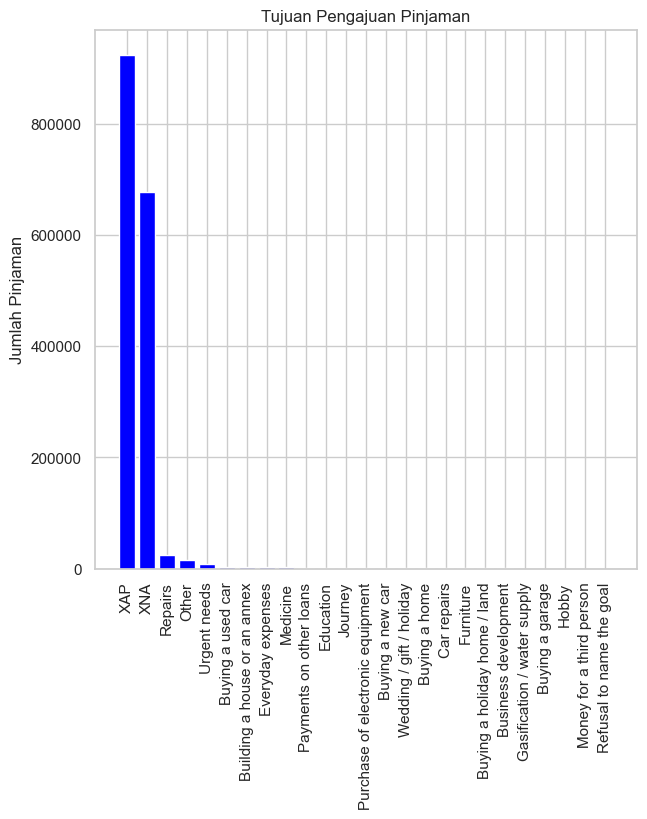

In [ ]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
purpose_dict = dict(application_loan_purpose)  # Mengubah counter menjadi dictionary
sorted_purpose_dict = dict(sorted(purpose_dict.items(), key=lambda kv: kv[1], reverse=True))  # Mengurutkan dictionary berdasarkan nilai (frekuensi)

# Membuat plot batang untuk menampilkan jumlah pinjaman berdasarkan tujuan
ind_4 = np.arange(len(sorted_purpose_dict))  # Membuat urutan indeks sesuai panjang data
plt.figure(figsize=(7,7))  # Mengatur ukuran figure
p1 = plt.bar(ind_4, list(sorted_purpose_dict.values()), color='blue')  # Membuat plot batang

# Menambahkan label dan judul pada grafik
plt.ylabel('Jumlah Pinjaman')  # Mengubah label sumbu Y menjadi bahasa Indonesia
plt.title('Tujuan Pengajuan Pinjaman')  # Mengubah judul grafik menjadi bahasa Indonesia
plt.xticks(ind_4, list(sorted_purpose_dict.keys()), rotation=90)  # Menambahkan label pada sumbu X dengan rotasi 90 derajat
plt.show()  # Menampilkan grafik


**Observasi:**

1. **XAP** dan **XNA** mendominasi tujuan pengajuan pinjaman dalam jumlah yang sangat besar dibandingkan kategori lainnya.
   - Kedua kategori ini mungkin mewakili pengajuan pinjaman dengan tujuan yang tidak dijelaskan atau kode khusus yang tidak diberi keterangan lebih lanjut.
   
2. **Tujuan umum pengajuan pinjaman**:
   - Setelah XAP dan XNA, kategori seperti **perbaikan (Repairs)**, **kebutuhan mendesak (Urgent needs)**, dan **pembelian mobil bekas (Buying a used car)** juga muncul, tetapi dalam jumlah yang jauh lebih kecil.

3. **Kesimpulan**:
   - Sebagian besar pengajuan pinjaman tampaknya tidak mengungkapkan secara jelas tujuan pinjaman (karena dominasi XAP dan XNA).
   - Beberapa tujuan yang lebih spesifik seperti **perbaikan rumah** dan **pembelian mobil** lebih jarang ditemukan di dalam dataset.

### 6.2.2 Univariate Analysis: Name_Contract_Status

In [ ]:
# Menghitung jumlah status kontrak pinjaman
application_contract_status = Counter()

# Mengiterasi setiap nilai dalam kolom 'NAME_CONTRACT_STATUS' pada 'previous_application'
for status in previous_application['NAME_CONTRACT_STATUS'].values:
    # Memperbarui Counter untuk menghitung frekuensi setiap status
    application_contract_status.update(status.split(','))


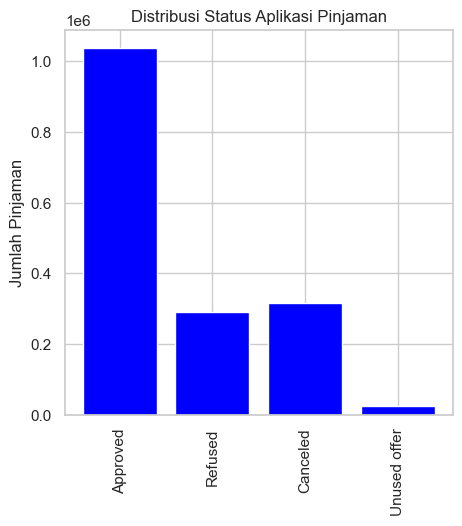

In [ ]:
# Mengubah Counter menjadi dictionary
contract_status_dict = dict(application_contract_status)

# Mengurutkan dictionary berdasarkan nilai (frekuensi) secara menurun (descending)
sorted_contract_status_dict = dict(sorted(contract_status_dict.items(), \
                                          key=lambda kv: kv[1], reverse=True))

# Membuat urutan indeks sesuai dengan panjang data
ind_5 = np.arange(len(contract_status_dict))

# Mengatur ukuran figure
plt.figure(figsize=(5,5))

# Membuat plot batang untuk distribusi status aplikasi
p1 = plt.bar(ind_5, list(contract_status_dict.values()), color='blue')

# Menambahkan label sumbu Y dan judul grafik dalam bahasa Indonesia
plt.ylabel('Jumlah Pinjaman')  # Label sumbu Y
plt.title('Distribusi Status Aplikasi Pinjaman')  # Judul grafik

# Menambahkan label pada sumbu X dengan rotasi 90 derajat
plt.xticks(ind_5, list(contract_status_dict.keys()), rotation=90)

# Menampilkan grafik
plt.show()


**Observasi**:

1. **Approved**: Sebagian besar aplikasi pinjaman disetujui, dengan jumlah yang mendekati 1 juta pinjaman.
2. **Refused dan Canceled**: Jumlah aplikasi yang ditolak dan dibatalkan relatif seimbang, keduanya berada di kisaran 200.000 hingga 300.000.
3. **Unused Offer**: Terdapat sedikit sekali penawaran yang tidak digunakan, dengan jumlah yang sangat kecil dibandingkan status lainnya.

Kesimpulannya, sebagian besar aplikasi pinjaman cenderung disetujui, sementara hanya sebagian kecil yang ditolak, dibatalkan, atau tidak digunakan.

### 6.2.3 Univariate Analysis: Name_Payment_Type

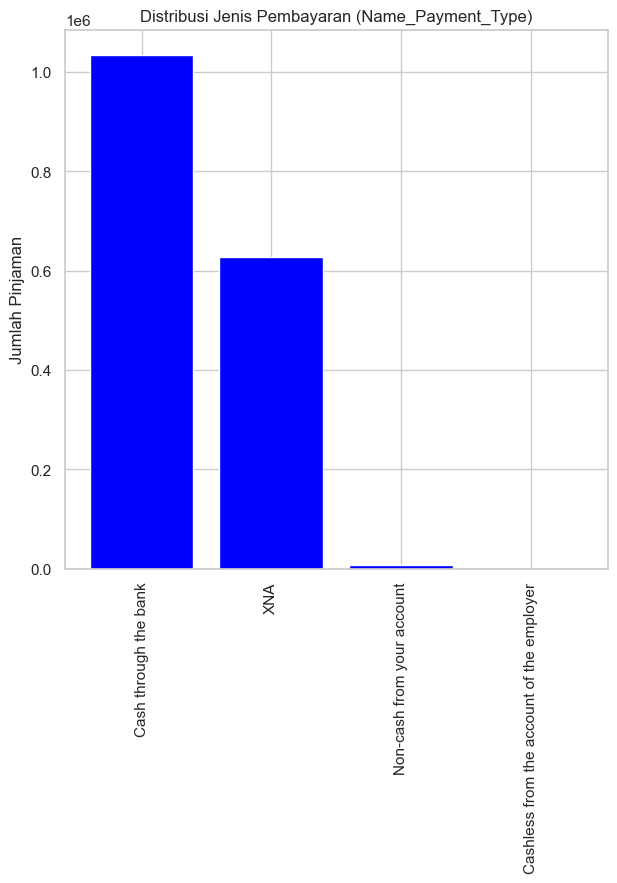

In [ ]:
# Menghitung jumlah setiap jenis pembayaran
application_payment_type = Counter()
for payment_type in previous_application['NAME_PAYMENT_TYPE'].values:
    application_payment_type.update(payment_type.split(','))

# Mengurutkan dictionary berdasarkan frekuensi
payment_type_dict = dict(application_payment_type)
sorted_payment_type_dict = dict(sorted(payment_type_dict.items(), key=lambda kv: kv[1], reverse=True))

# Membuat plot batang untuk menampilkan distribusi jenis pembayaran
ind_6 = np.arange(len(payment_type_dict))
plt.figure(figsize=(7, 7))
p1 = plt.bar(ind_6, list(sorted_payment_type_dict.values()), color='blue')

# Menambahkan label dan judul pada grafik
plt.ylabel('Jumlah Pinjaman')
plt.title('Distribusi Jenis Pembayaran (Name_Payment_Type)')
plt.xticks(ind_6, list(sorted_payment_type_dict.keys()), rotation=90)
plt.show()


**Observasi:**

- Sebagian besar pinjaman dibayar melalui **Cash through the bank**, yang merupakan metode pembayaran paling umum dengan jumlah yang jauh lebih besar dibandingkan metode lainnya.
- Kategori **XNA** memiliki jumlah pinjaman yang signifikan, meskipun artinya tidak jelas dalam konteks dataset ini.
- Metode pembayaran seperti **Non-cash from your account** dan **Cashless from the account of the employer** hanya digunakan pada jumlah pinjaman yang sangat sedikit.
- Distribusi ini menunjukkan bahwa pembayaran tunai melalui bank adalah pilihan dominan untuk pinjaman.

### 6.2.4 Univariate Analysis: Code_Reject_Reason

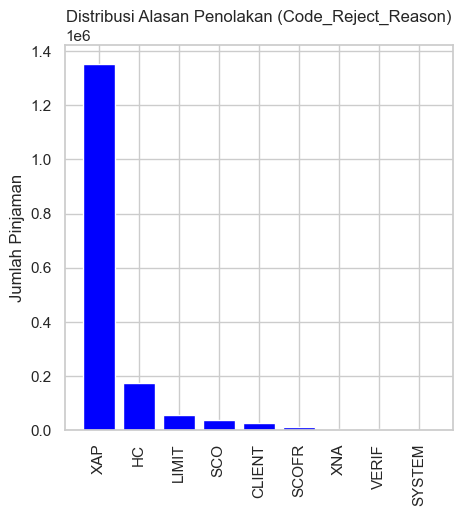

In [ ]:
# Menghitung jumlah alasan penolakan dari dataset
application_code_reject_reason = Counter()
for reason in previous_application['CODE_REJECT_REASON'].values:
    application_code_reject_reason.update(reason.split(','))

# Mengurutkan dictionary berdasarkan nilai (jumlah alasan penolakan)
code_reject_reason_dict = dict(application_code_reject_reason)
sorted_code_reject_reason_dict = dict(sorted(code_reject_reason_dict.items(), key=lambda kv: kv[1], reverse=True))

# Membuat plot batang untuk menampilkan distribusi alasan penolakan
ind_7 = np.arange(len(sorted_code_reject_reason_dict))  # Membuat urutan indeks sesuai panjang data
plt.figure(figsize=(5,5))  # Mengatur ukuran figure
p1 = plt.bar(ind_7, list(sorted_code_reject_reason_dict.values()), color='blue')  # Membuat plot batang

# Menambahkan label dan judul pada grafik
plt.ylabel('Jumlah Pinjaman')  # Label sumbu Y
plt.title('Distribusi Alasan Penolakan (Code_Reject_Reason)')  # Judul grafik
plt.xticks(ind_7, list(sorted_code_reject_reason_dict.keys()), rotation=90)  # Label sumbu X dengan rotasi 90 derajat
plt.show()  # Menampilkan grafik

**Observasi:**

1. **Alasan Penolakan Paling Umum**:
   - Sebagian besar penolakan aplikasi pinjaman ditandai dengan kode "XAP". Kode ini muncul jauh lebih sering daripada alasan lainnya, menunjukkan bahwa alasan ini merupakan yang paling umum dalam dataset.

2. **Alasan Lain yang Relatif Sedikit**:
   - Alasan penolakan lain seperti "HC" (mungkin terkait dengan kapasitas pinjaman) muncul dengan frekuensi yang jauh lebih rendah.
   - Alasan seperti "LIMIT", "CLIENT", dan "SCOFR" juga terlihat, namun jumlahnya sangat sedikit jika dibandingkan dengan "XAP".

3. **Distribusi yang Sangat Tidak Merata**:
   - Sebagian besar aplikasi yang ditolak disebabkan oleh satu alasan utama (XAP), sementara alasan lainnya berjumlah kecil dan tersebar secara merata.

### 6.2.5 Univariate Analysis: Name_Client_Type

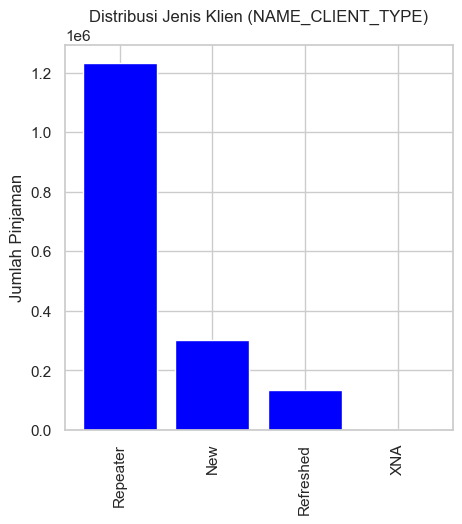

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Menghitung frekuensi setiap jenis client berdasarkan kolom NAME_CLIENT_TYPE
application_client_type = Counter()
for type in previous_application['NAME_CLIENT_TYPE'].values:
    application_client_type.update(type.split(','))

# Mengurutkan dictionary berdasarkan nilai (frekuensi)
client_type_dict = dict(application_client_type)
sorted_client_type_dict = dict(sorted(client_type_dict.items(), key=lambda kv: kv[1], reverse=True))

# Membuat plot batang untuk distribusi jenis client
ind_8 = np.arange(len(client_type_dict))  # Indeks untuk sumbu X
plt.figure(figsize=(5,5))  # Ukuran grafik
p1 = plt.bar(ind_8, list(client_type_dict.values()), color='blue')  # Membuat plot batang

# Menambahkan label dan judul pada grafik
plt.ylabel('Jumlah Pinjaman')  # Label sumbu Y
plt.title('Distribusi Jenis Klien (NAME_CLIENT_TYPE)')  # Judul grafik
plt.xticks(ind_8, list(client_type_dict.keys()), rotation=90)  # Label sumbu X dengan rotasi 90 derajat
plt.show()  # Menampilkan grafik


**Observasi:**

1. **Repeater** merupakan jenis klien yang paling banyak mengajukan pinjaman. Ini berarti banyak klien yang telah meminjam sebelumnya dan kembali untuk mengajukan pinjaman baru.
2. **New** klien, atau klien yang baru pertama kali mengajukan pinjaman, berada di urutan kedua, meskipun jumlahnya jauh lebih sedikit dibandingkan dengan klien **Repeater**.
3. **Refreshed** klien juga tercatat dalam jumlah kecil, artinya ada beberapa klien yang memperbarui aplikasi pinjaman mereka.
4. **XNA** hampir tidak terlihat dalam distribusi ini, menandakan jumlah yang sangat kecil atau kategori yang mungkin tidak jelas.

Dari distribusi ini, dapat dilihat bahwa klien yang telah berulang kali mengajukan pinjaman (Repeater) sangat mendominasi dibandingkan dengan klien baru dan klien lainnya.

### 6.2.6 Univariate Analysis: Name_Goods_Category

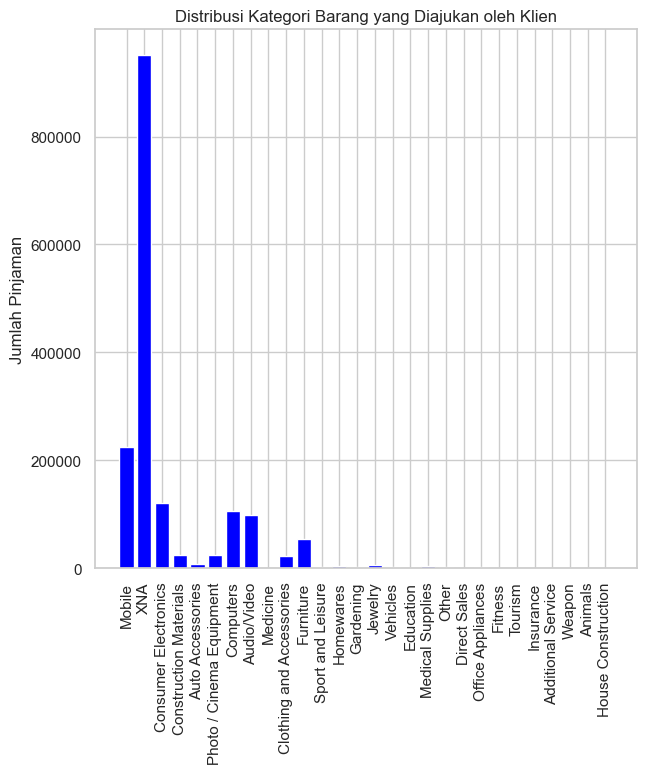

In [ ]:
# Menghitung kategori barang yang diajukan oleh klien dalam aplikasi pinjaman
application_goods_category = Counter()
for category in previous_application['NAME_GOODS_CATEGORY'].values:
    application_goods_category.update(category.split(','))

# Mengubah counter menjadi dictionary dan mengurutkan berdasarkan nilai tertinggi
goods_category_dict = dict(application_goods_category)
sorted_goods_category = dict(sorted(goods_category_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

# Membuat plot untuk menampilkan distribusi kategori barang
ind_9 = np.arange(len(goods_category_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_9, list(goods_category_dict.values()),color='blue')

# Menambahkan label dan judul
plt.ylabel('Jumlah Pinjaman')
plt.title('Distribusi Kategori Barang yang Diajukan oleh Klien')
plt.xticks(ind_9, list(goods_category_dict.keys()),rotation=90)
plt.show()


### Observasi:

1. **Kategori barang yang paling sering diajukan**:
   - Sebagian besar klien mengajukan pinjaman untuk kategori **Mobile**. Ini menunjukkan bahwa pinjaman untuk barang-barang elektronik, khususnya telepon genggam, adalah yang paling banyak diajukan.
   - Kategori **Consumer Electronics** dan **XNA** juga cukup tinggi, meskipun definisi dari XNA tidak dijelaskan dalam dataset ini.

2. **Kategori barang lainnya**:
   - Kategori **Construction Materials**, **Auto Accessories**, dan **Computers** adalah beberapa kategori lain yang cukup sering muncul, menunjukkan adanya kebutuhan untuk barang-barang yang terkait dengan perbaikan atau peningkatan rumah, aksesori mobil, dan perangkat komputer.
   - Kategori lain seperti **Medical supplies**, **Jewelry**, dan **Furniture** relatif jarang diajukan oleh klien.

3. **Kesimpulan**:
   - Pinjaman untuk barang-barang elektronik, terutama telepon genggam dan elektronik konsumen lainnya, sangat dominan dalam aplikasi pinjaman. Ini menunjukkan preferensi atau kebutuhan utama klien dalam membeli barang-barang tersebut dengan menggunakan pinjaman.

### 6.2.7 Univariate Analysis: Name_Portfolio

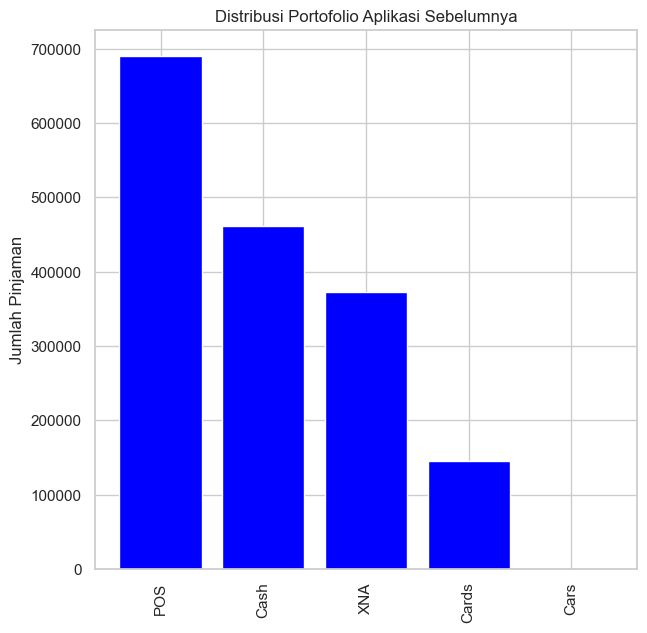

In [ ]:
# Menghitung jumlah tiap nama portofolio dalam dataset previous_application
application_name_portfolio = Counter()
for name in previous_application['NAME_PORTFOLIO'].values:
    application_name_portfolio.update(name.split(','))

# Mengurutkan dictionary berdasarkan frekuensi nilai (jumlah portofolio)
application_name_dict = dict(application_name_portfolio)
sorted_name_portfolio = dict(sorted(application_name_dict.items(), \
                                        key=lambda kv: kv[1], reverse=True))

# Membuat plot batang untuk menampilkan distribusi portofolio aplikasi sebelumnya
ind_10 = np.arange(len(application_name_dict))
plt.figure(figsize=(7,7))
p1 = plt.bar(ind_10, list(application_name_dict.values()),color='blue')

# Menambahkan label dan judul pada grafik
plt.ylabel('Jumlah Pinjaman')  # Label sumbu Y dalam bahasa Indonesia
plt.title('Distribusi Portofolio Aplikasi Sebelumnya')  # Judul dalam bahasa Indonesia
plt.xticks(ind_10, list(application_name_dict.keys()),rotation=90)  # Menambahkan label sumbu X dengan rotasi 90 derajat
plt.show()


### Observasi:

1. **POS** (Point of Sale) adalah kategori portofolio aplikasi sebelumnya yang paling banyak digunakan, dengan jumlah pinjaman yang disetujui mendekati 700.000.
2. **Cash** (Tunai) berada di posisi kedua dengan jumlah pinjaman yang disetujui sekitar 500.000.
3. **XNA** muncul sebagai kategori yang kurang jelas, namun jumlah pinjaman yang disetujui untuk kategori ini juga signifikan, sekitar 400.000.
4. **Cards** (Kartu) dan **Cars** (Mobil) memiliki jumlah pinjaman yang relatif lebih sedikit dibandingkan kategori lainnya, masing-masing di bawah 200.000 pinjaman.

Kesimpulan yang dapat diambil adalah bahwa portofolio **POS** dan **Cash** mendominasi dalam aplikasi pinjaman sebelumnya, menunjukkan bahwa kebanyakan pelanggan lebih memilih jenis pinjaman ini.

### 6.2.8 Univariate Analysis: Channel_Type

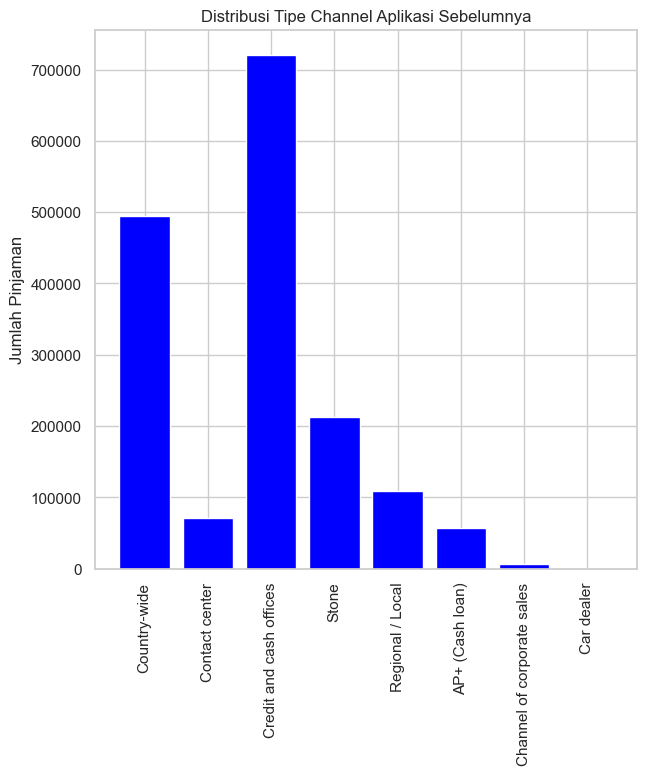

In [ ]:
# Menghitung frekuensi setiap tipe channel dalam dataset aplikasi sebelumnya
application_channel_type = Counter()
for type in previous_application['CHANNEL_TYPE'].values:
    application_channel_type.update(type.split(','))

# Mengurutkan dictionary berdasarkan nilai (frekuensi) secara menurun
channel_type_dict = dict(application_channel_type)
sorted_channel_type = dict(sorted(channel_type_dict.items(), key=lambda kv: kv[1], reverse=True))

# Membuat plot batang untuk distribusi tipe channel
ind_11 = np.arange(len(channel_type_dict))  # Membuat urutan indeks sesuai panjang data
plt.figure(figsize=(7,7))  # Mengatur ukuran grafik
p1 = plt.bar(ind_11, list(channel_type_dict.values()), color='blue')  # Membuat plot batang

# Menambahkan label dan judul pada grafik
plt.ylabel('Jumlah Pinjaman')  # Menambahkan label sumbu Y
plt.title('Distribusi Tipe Channel Aplikasi Sebelumnya')  # Menambahkan judul grafik
plt.xticks(ind_11, list(channel_type_dict.keys()), rotation=90)  # Menambahkan label pada sumbu X dengan rotasi 90 derajat
plt.show()  # Menampilkan grafik


### Observasi:

1. **Distribusi Tipe Channel Aplikasi Pinjaman:**
   - Sebagian besar aplikasi pinjaman diajukan melalui **kantor kredit dan kas** (Credit and cash offices), yang menunjukkan bahwa banyak peminjam lebih memilih untuk mengajukan pinjaman secara langsung di lokasi fisik.
   - Tipe channel lain yang signifikan adalah **Country-wide** dan **Store**, yang juga menunjukkan bahwa pengajuan pinjaman dilakukan secara langsung di banyak cabang atau toko di seluruh negara.
   - Channel seperti **Contact center**, **Regional/Local**, dan **AP+ (Cash loan)** memiliki jumlah aplikasi yang lebih sedikit dibandingkan dengan channel lainnya.
   - Channel dengan frekuensi terendah adalah **Car dealer** dan **Channel of corporate sales**, yang menandakan bahwa hanya sedikit aplikasi yang diajukan melalui dealer mobil atau channel penjualan korporat.

2. **Implikasi:**
   - Banyak peminjam masih mengandalkan pengajuan pinjaman secara fisik melalui kantor kredit dan kas. Ini bisa menjadi indikasi bahwa mereka lebih percaya pada pengajuan pinjaman secara langsung dibandingkan dengan cara lain yang lebih digital atau jarak jauh.
   - Channel dengan frekuensi rendah mungkin dapat dieksplorasi lebih lanjut untuk memahami apakah ada peluang untuk meningkatkan penggunaan channel tersebut di masa depan.

### 6.2.9 Univariate Analysis: Nflag_Insured_on_Approval

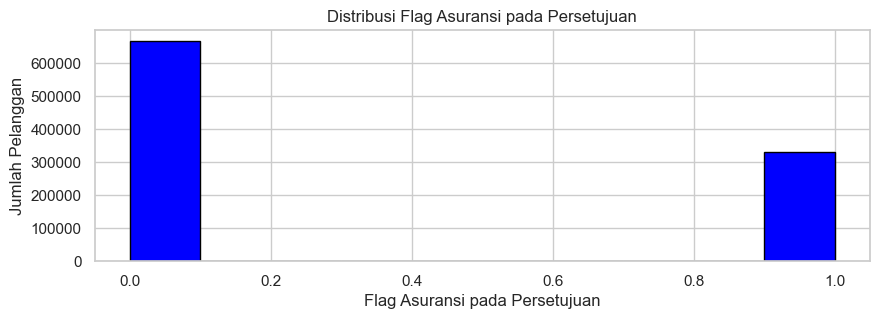

In [ ]:
# Plotting histogram for NFLAG_INSURED_ON_APPROVAL
plt.figure(figsize=(10, 3))  # Mengatur ukuran figure
plt.hist(previous_application['NFLAG_INSURED_ON_APPROVAL'].values, bins=10, \
         edgecolor='black', color='blue')  # Membuat histogram dengan batas bin dan warna biru
plt.title('Distribusi Flag Asuransi pada Persetujuan')  # Menambahkan judul dalam bahasa Indonesia
plt.xlabel('Flag Asuransi pada Persetujuan')  # Menambahkan label sumbu X dalam bahasa Indonesia
plt.ylabel('Jumlah Pelanggan')  # Menambahkan label sumbu Y dalam bahasa Indonesia
plt.show()  # Menampilkan grafik


**Observasi:**

- Sebagian besar pelanggan tidak memiliki asuransi pada saat persetujuan, yang terlihat dari banyaknya flag di nilai **0**.
- Sebagian kecil pelanggan memiliki asuransi pada saat persetujuan, dengan flag **1** yang jauh lebih rendah jumlahnya dibandingkan flag **0**.
- Hal ini menunjukkan bahwa mayoritas pelanggan tidak diasuransikan pada saat mereka mengajukan pinjaman.

Kesimpulan ini dapat menjadi dasar untuk analisis lebih lanjut terkait hubungan antara asuransi pada saat persetujuan dengan tingkat persetujuan pinjaman atau risiko pinjaman.

### 6.3 Dealing with Null Values and Outliers

Kami tidak akan bisa menemukan outlier untuk fitur yang berkaitan dengan Jumlah dan Uang Tunai, kecuali bahwa nilai-nilai ini tidak boleh negatif. Selain itu, kita akan mencoba menangani fitur-fitur lainnya.

### 6.3.1 Days_Decision

Fitur ini pada dasarnya merujuk pada jumlah hari relatif terhadap aplikasi saat ini di mana keputusan dibuat terkait dengan aplikasi sebelumnya.

### 6.3.2 Days_First_Drawing

Fitur ini berarti bahwa relatif terhadap tanggal aplikasi saat ini, kapan pencairan pertama dari aplikasi sebelumnya dilakukan.

In [ ]:
# Menampilkan statistik deskriptif untuk kolom 'DAYS_FIRST_DRAWING'
print("Statistik deskriptif untuk kolom 'DAYS_FIRST_DRAWING':")
previous_application['DAYS_FIRST_DRAWING'].describe()


Statistik deskriptif untuk kolom 'DAYS_FIRST_DRAWING':


count    997149.000000
mean     342209.855039
std       88916.115834
min       -2922.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: DAYS_FIRST_DRAWING, dtype: float64

In [ ]:
# Menampilkan jumlah maksimum dan minimum 'Days_First_Drawing' (dalam tahun) dari semua aplikasi
print("Jumlah maksimum Days_First_Drawing (dalam tahun) dari semua aplikasi = ",\
       max(previous_application['DAYS_FIRST_DRAWING'].values)/365)

print("Jumlah minimum Days_First_Drawing (dalam tahun) dari semua aplikasi = ",\
       min(previous_application['DAYS_FIRST_DRAWING'].values)/365)


Jumlah maksimum Days_First_Drawing (dalam tahun) dari semua aplikasi =  1000.6657534246575
Jumlah minimum Days_First_Drawing (dalam tahun) dari semua aplikasi =  -8.005479452054795


**Catatan:**

Ini menunjukkan bahwa nilai maksimum **Days_First_Drawing** dalam tabel berada 1000 tahun sebelum aplikasi saat ini, yang jelas tidak masuk akal. Selain itu, karena nilai persentil ke-25, ke-50, dan ke-75 untuk fitur ini sama dengan nilai maksimum, langkah pertama yang akan dilakukan adalah menghapus nilai maksimum tersebut.

In [ ]:
# Mengganti nilai maksimum pada kolom 'DAYS_FIRST_DRAWING' dengan nilai NaN
previous_application['DAYS_FIRST_DRAWING'].replace(max(previous_application['DAYS_FIRST_DRAWING'].values), np.nan, inplace=True)

# Menampilkan ringkasan statistik kolom 'DAYS_FIRST_DRAWING'
previous_application['DAYS_FIRST_DRAWING'].describe()


count    62705.000000
mean     -1035.246791
std        922.710316
min      -2922.000000
25%      -1721.000000
50%       -621.000000
75%       -303.000000
max         -2.000000
Name: DAYS_FIRST_DRAWING, dtype: float64

**Observasi:**

- Berdasarkan data pada kolom **DAYS_FIRST_DRAWING**, kita dapat melihat bahwa nilai minimum (-2922 hari) dan maksimum (-2 hari) dapat diterima. Kedua nilai ini negatif karena mengacu pada waktu relatif terhadap aplikasi saat ini.
- Nilai tengah (median) adalah -621 hari, yang menunjukkan bahwa sebagian besar aplikasi sebelumnya terjadi lebih dari satu tahun yang lalu.
- Rentang interkuartil (IQR) adalah antara -1721 hingga -303 hari, yang mencakup sebagian besar data tanpa adanya outlier yang signifikan.

### 6.3.3 Days_First_Due

**Days_First_Due** berarti kapan seharusnya jatuh tempo pertama dari aplikasi sebelumnya terjadi relatif terhadap tanggal aplikasi dari aplikasi saat ini.

In [ ]:
# Menampilkan deskripsi statistik dari kolom 'DAYS_FIRST_DUE'
previous_application['DAYS_FIRST_DUE'].describe()

count    997149.000000
mean      13826.269337
std       72444.869708
min       -2892.000000
25%       -1628.000000
50%        -831.000000
75%        -411.000000
max      365243.000000
Name: DAYS_FIRST_DUE, dtype: float64

In [ ]:
# Mengganti nilai NaN menjadi 0 untuk sementara
previous_application['DAYS_FIRST_DUE'].replace(np.nan, 0, inplace=True)

# Mencetak nilai minimum DAYS_FIRST_DUE (dalam tahun) dari semua aplikasi
print("Nilai minimum Days_First_Due (dalam tahun) dari semua aplikasi = ",\
       min(previous_application['DAYS_FIRST_DUE'].values)/365)

# Mencetak nilai maksimum DAYS_FIRST_DUE (dalam tahun) dari semua aplikasi
print("Nilai maksimum Days_First_Due (dalam tahun) dari semua aplikasi = ",\
       max(previous_application['DAYS_FIRST_DUE'].values)/365)

# Mengembalikan nilai 0 menjadi NaN setelah perhitungan
previous_application['DAYS_FIRST_DUE'].replace(0, np.nan, inplace=True)


Nilai minimum Days_First_Due (dalam tahun) dari semua aplikasi =  -7.923287671232877
Nilai maksimum Days_First_Due (dalam tahun) dari semua aplikasi =  1000.6657534246575


**Catatan:**

Ini berarti bahwa nilai maksimum **Days_First_Due** dalam tabel adalah 1000 tahun sebelum aplikasi saat ini, yang jelas tidak mungkin. Oleh karena itu, langkah pertama yang akan kita lakukan adalah menghapus nilai maksimum ini pada fitur tersebut.

In [ ]:
# Mengganti nilai maksimum pada kolom 'DAYS_FIRST_DUE' dengan nilai NaN
previous_application['DAYS_FIRST_DUE'].replace(max(previous_application['DAYS_FIRST_DUE'].values), np.nan, inplace=True)

# Menampilkan deskripsi statistik kolom 'DAYS_FIRST_DUE'
previous_application['DAYS_FIRST_DUE'].describe()


**Observasi:**

- Kita dapat melihat bahwa nilai minimum dan maksimum untuk **Days_First_Due** pada tabel ini masuk akal dan dapat diterima. Kedua nilai ini bersifat negatif, yang berarti bahwa jatuh tempo pertama dari aplikasi sebelumnya terjadi pada tanggal sebelum aplikasi saat ini. Hal ini menunjukkan bahwa tidak ada outlier yang signifikan pada kolom ini setelah nilai maksimum yang tidak masuk akal dihapus.

### 6.3.4 Days_Last_Due_1st_Version

Fitur ini berarti bahwa, relatif terhadap tanggal aplikasi dari aplikasi saat ini, kapan jatuh tempo pertama dari aplikasi sebelumnya seharusnya terjadi.

In [ ]:
# Menampilkan deskripsi statistik untuk kolom 'DAYS_LAST_DUE_1ST_VERSION'
print("Deskripsi statistik untuk kolom 'DAYS_LAST_DUE_1ST_VERSION':")
previous_application['DAYS_LAST_DUE_1ST_VERSION'].describe()


Deskripsi statistik untuk kolom 'DAYS_LAST_DUE_1ST_VERSION':


count    997149.000000
mean      33767.774054
std      106857.034789
min       -2801.000000
25%       -1242.000000
50%        -361.000000
75%         129.000000
max      365243.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64

In [ ]:
# Mengganti nilai NaN dengan 0 pada kolom 'DAYS_LAST_DUE_1ST_VERSION'
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(np.nan, 0, inplace=True)

# Menampilkan nilai minimum 'Days_Last_Due_1st_Version' dalam tahun di seluruh aplikasi
print("Nilai minimum Days_Last_Due_1st_Version (dalam tahun) di seluruh aplikasi = ",\
       np.round(min(previous_application['DAYS_LAST_DUE_1ST_VERSION'].values)/365, 3))

# Menampilkan nilai maksimum 'Days_Last_Due_1st_Version' dalam tahun di seluruh aplikasi
print("Nilai maksimum Days_Last_Due_1st_Version (dalam tahun) di seluruh aplikasi = ",\
       np.round(max(previous_application['DAYS_LAST_DUE_1ST_VERSION'].values)/365, 3))

# Mengembalikan nilai 0 menjadi NaN pada kolom 'DAYS_LAST_DUE_1ST_VERSION'
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(0, np.nan, inplace=True)


Nilai minimum Days_Last_Due_1st_Version (dalam tahun) di seluruh aplikasi =  -7.674
Nilai maksimum Days_Last_Due_1st_Version (dalam tahun) di seluruh aplikasi =  1000.666


<h4> Catatan </h4>

Sekali lagi, ini berarti bahwa nilai maksimum **Days_Last_Due_1st_Version** di tabel adalah 1000 tahun sebelum aplikasi saat ini, yang jelas tidak mungkin. Oleh karena itu, kita akan mengatasi hal ini terlebih dahulu dengan menghapus nilai maksimum pada fitur ini.

In [ ]:
# Mengganti nilai maksimum pada kolom 'DAYS_LAST_DUE_1ST_VERSION' dengan NaN
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(max(previous_application['DAYS_LAST_DUE_1ST_VERSION'].values),
                                                  np.nan, inplace=True)

# Menampilkan deskripsi statistik dari kolom 'DAYS_LAST_DUE_1ST_VERSION'
previous_application['DAYS_LAST_DUE_1ST_VERSION'].describe()


count    902580.000000
mean       -677.687099
std         923.767799
min       -2801.000000
25%       -1360.000000
50%        -481.000000
75%          -2.000000
max        2389.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64

**Observasi**:

- Berdasarkan hasil deskripsi statistik, kita dapat melihat bahwa nilai minimum dan maksimum pada kolom **Days_Last_Due_1st_Version** dapat diterima. Kedua nilai tersebut negatif dan berhubungan dengan waktu relatif terhadap aplikasi saat ini. Ini menunjukkan bahwa data pada kolom ini tidak memiliki outlier atau anomali signifikan setelah penggantian nilai maksimum yang tidak realistis.

### 6.3.5 Days_Last_Due

**Days_Last_Due** berarti bahwa relatif terhadap tanggal aplikasi dari aplikasi saat ini, kapan tanggal jatuh tempo terakhir dari aplikasi sebelumnya.

In [ ]:
# Menampilkan deskripsi statistik dari kolom 'DAYS_LAST_DUE'
previous_application['DAYS_LAST_DUE'].describe()


count    997149.000000
mean      76582.403064
std      149647.415123
min       -2889.000000
25%       -1314.000000
50%        -537.000000
75%         -74.000000
max      365243.000000
Name: DAYS_LAST_DUE, dtype: float64

In [ ]:
# Mengganti nilai NaN dengan 0 dalam kolom 'DAYS_LAST_DUE'
previous_application['DAYS_LAST_DUE'].replace(np.nan, 0, inplace=True)

# Menampilkan nilai minimum dari 'DAYS_LAST_DUE' (dalam tahun)
print("Hari terakhir jatuh tempo (dalam tahun) terkecil di seluruh aplikasi = ",\
       np.round(min(previous_application['DAYS_LAST_DUE'].values)/365, 3))

# Menampilkan nilai maksimum dari 'DAYS_LAST_DUE' (dalam tahun)
print("Hari terakhir jatuh tempo (dalam tahun) terbesar di seluruh aplikasi = ",\
       np.round(max(previous_application['DAYS_LAST_DUE'].values)/365, 3))

# Mengganti kembali nilai 0 dengan NaN dalam kolom 'DAYS_LAST_DUE'
previous_application['DAYS_LAST_DUE'].replace(0, np.nan, inplace=True)


Hari terakhir jatuh tempo (dalam tahun) terkecil di seluruh aplikasi =  -7.915
Hari terakhir jatuh tempo (dalam tahun) terbesar di seluruh aplikasi =  1000.666


**Catatan:**

Nilai maksimum **Days_Last_Due** yang ditampilkan dalam tabel adalah 1000 tahun sebelum aplikasi saat ini, yang secara logika tidak mungkin. Oleh karena itu, langkah pertama yang perlu dilakukan adalah menghilangkan nilai maksimum yang tidak masuk akal pada fitur ini untuk analisis lebih lanjut.

In [ ]:
# Mengganti nilai maksimum pada kolom DAYS_LAST_DUE dengan NaN
previous_application['DAYS_LAST_DUE'].replace(max(previous_application['DAYS_LAST_DUE'].values),\
                                                  np.nan, inplace=True)

# Menampilkan deskripsi statistik dari kolom DAYS_LAST_DUE setelah penggantian nilai maksimum
print("Deskripsi statistik setelah penggantian nilai maksimum dengan NaN pada kolom 'DAYS_LAST_DUE':")
previous_application['DAYS_LAST_DUE'].describe()


Deskripsi statistik setelah penggantian nilai maksimum dengan NaN pada kolom 'DAYS_LAST_DUE':


count    785928.000000
mean       -996.179128
std         752.703178
min       -2889.000000
25%       -1566.000000
50%        -801.000000
75%        -353.000000
max          -2.000000
Name: DAYS_LAST_DUE, dtype: float64